# P14 O. biroi snRNAseq Analysis

antman environment

In [88]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Bio.SeqIO as SeqIO
import sys
from tqdm import tqdm
import re
from pygenomeviz import GenomeViz
import scipy.stats as stats
from matplotlib.lines import Line2D
import seaborn as sns
from scipy.stats import ttest_rel
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
import math
sys.path.append('../')
from transcriptomics import *
from plotting import * 
white_plotting()

In [89]:
tr = load_transcriptome_object("../raw-data/OBir/transcriptome/biroi_transcriptome.pkl")

In [90]:
sc.set_figure_params(dpi=300, color_map="rocket_r")
sc.settings.verbosity = 0 

In [91]:
# set pd max columns to 100 and max rows to 10 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)
# Set default font size to 6 
plt.rcParams.update({'font.size': 6})
# Set default title font size to 6
plt.rcParams.update({'axes.titlesize': 6})

## Load Data

In [92]:
# Load P14
data_path_p14 = '../raw-data/OBir/snRNAseq/p14_neurons.h5ad'
adata = sc.read_h5ad(data_path_p14)
print(f"Number of cells: {adata.n_obs}, number of genes: {adata.n_vars}")

# QC
sc.pp.calculate_qc_metrics(adata, inplace=True)

# Filter genes and cells
sc.pp.filter_genes(adata, min_cells=3)  # Remove genes expressed in fewer than 3 cells
print(f"Number of cells: {adata.n_obs}, number of genes: {adata.n_vars} after filtering genes")

sc.pp.filter_cells(adata, min_genes=200)  # Remove cells with fewer than 200 genes expressed
print(f"Number of cells: {adata.n_obs}, number of genes: {adata.n_vars} after filtering cells")

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4) 
print("Normalizing total counts per cell")
sc.pp.log1p(adata)  # Log-transform
print("Log-transforming data")

# Identify highly variable genes - unnecessary 
sc.pp.highly_variable_genes(adata, min_mean=0.001, max_mean=5, min_disp=0.5)
print(f"Number of highly variable genes: {sum(adata.var['highly_variable'])}")


Number of cells: 12045, number of genes: 14167
Number of cells: 12045, number of genes: 12359 after filtering genes
Number of cells: 12045, number of genes: 12359 after filtering cells
Normalizing total counts per cell
Log-transforming data
Number of highly variable genes: 1535


In [93]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
print("Computed neighborhood graph")

sc.tl.umap(adata)
print("Computed UMAP")

sc.tl.leiden(adata, resolution=0.5)
print("Performed Leiden clustering")

Computed neighborhood graph
Computed UMAP
Performed Leiden clustering


<Axes: title={'center': 'Leiden clusters'}, xlabel='UMAP1', ylabel='UMAP2'>

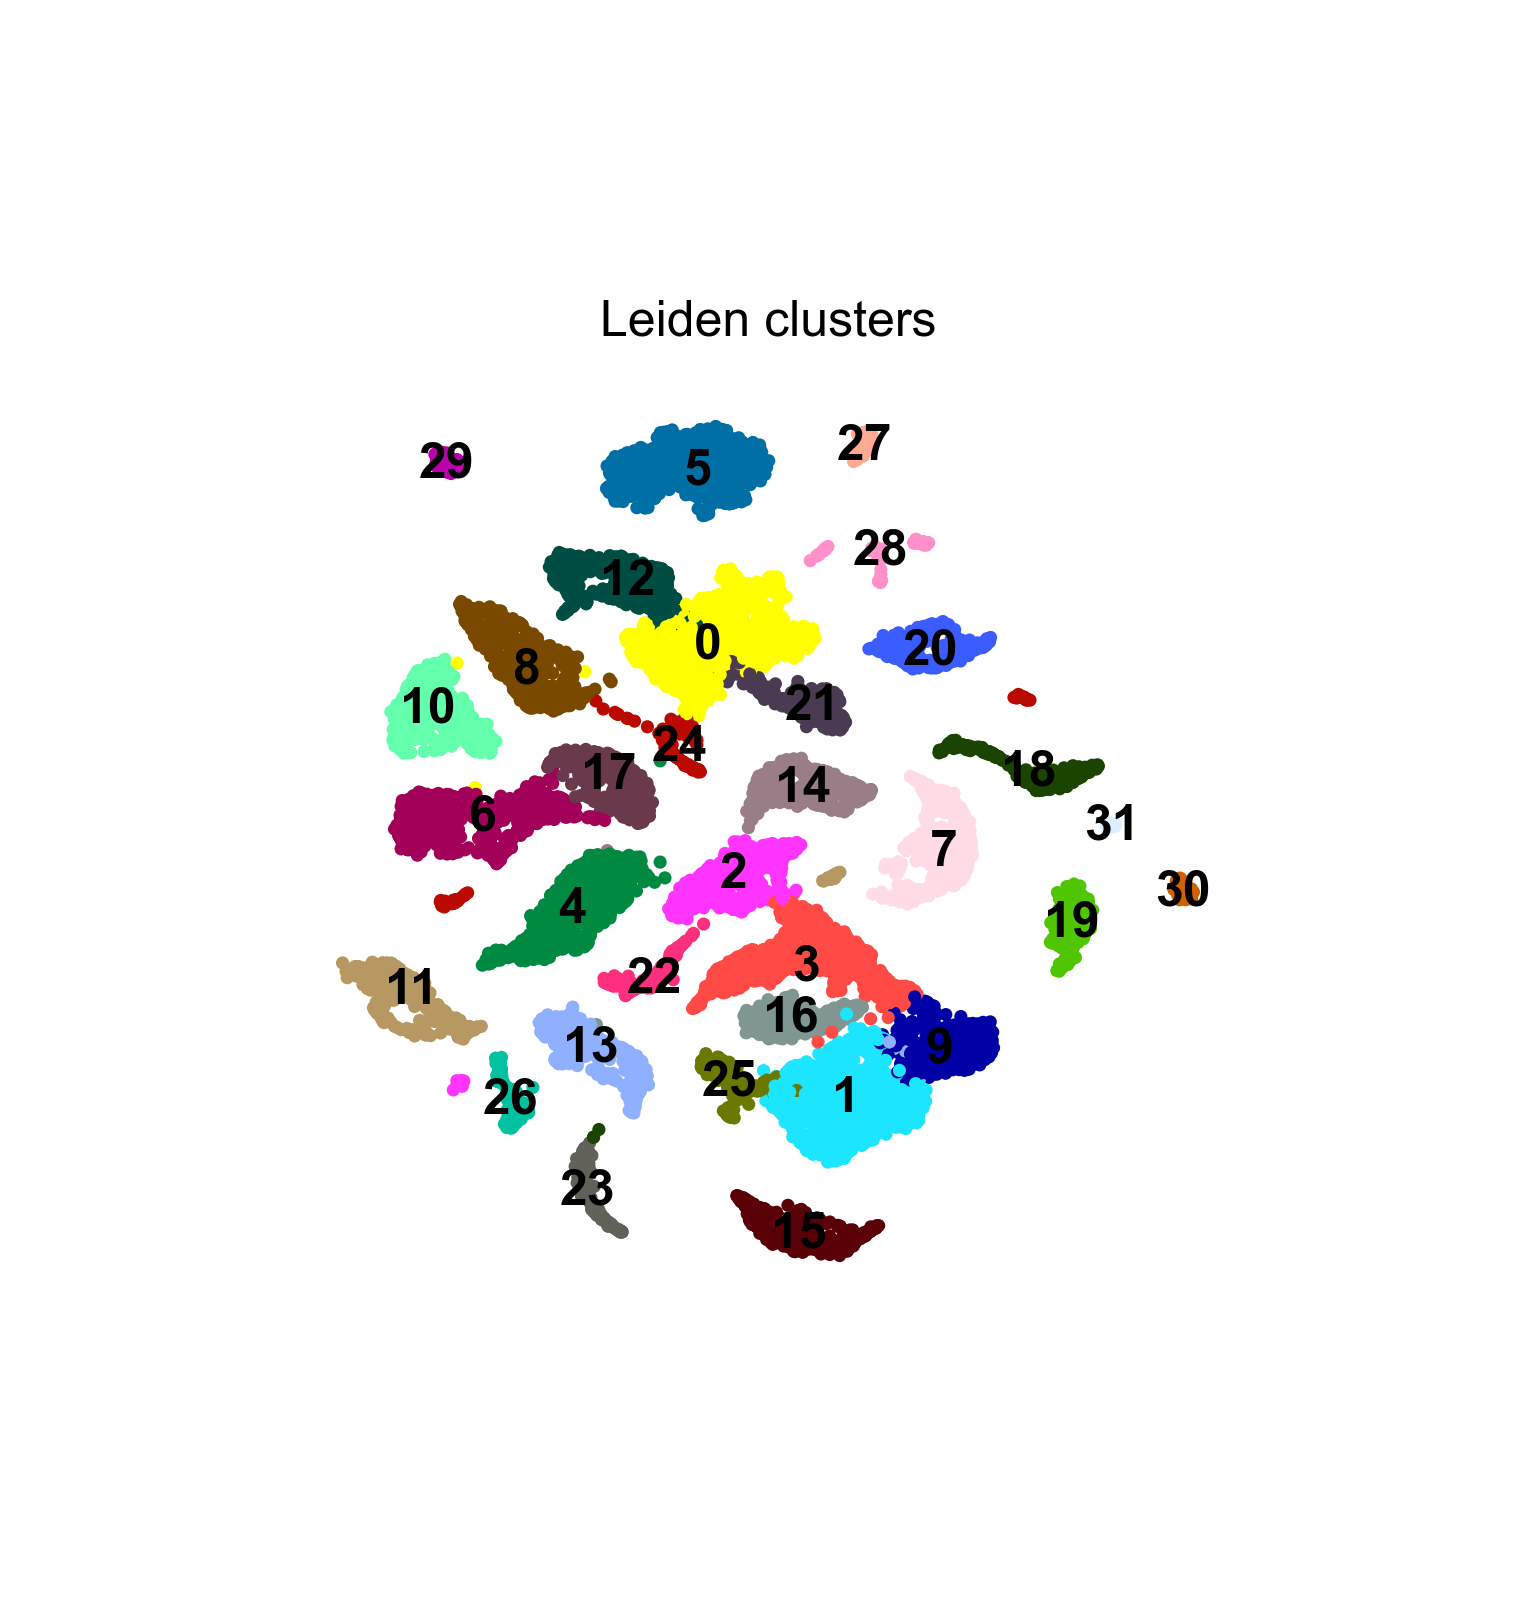

In [94]:
# UMAP of leiden clusters
f, ax = plt.subplots(figsize=(2, 2))
sc.pl.umap(adata, color=['leiden'], frameon=False, legend_loc='on data', title='Leiden clusters', show=False, ax=ax)

## OR DB 

In [95]:
# Load or_db
or_db = pd.read_excel('../raw-data/OBir/ORs/OR List.xlsx') 
or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

In [96]:
# iterate through each row of or_db 
for i, row in or_db.iterrows(): 
    gene = tr.get_gene(row.gene_name) 
    transcript = gene.get_transcript_longest_bounds()
    bounds = transcript.get_bounds()
    or_db.at[i,'start'] = bounds[0]
    or_db.at[i,'end'] = bounds[1] 
    or_db.at[i,'strand'] = transcript.strand 
    or_db.at[i, 'chr'] = transcript.chromosome
    or_db.at[i,'n_exons'] = len(transcript.exons)
    or_db.at[i,'nine_exon'] = "9E" in row['gene_name']
    or_db.at[i,'ta_size'] = or_db.loc[or_db.tandem_array == row['tandem_array']].shape[0]
or_db['start'] = or_db['start'].astype(int)
or_db['end'] = or_db['end'].astype(int)
or_db['ta_size'] = or_db['ta_size'].astype(int)
or_db['ta_index'] = or_db.groupby('tandem_array')['start'].rank(method='first', ascending=True).astype(int)

or_db.head(5)

chromosome gene_name  tandem_array  rank orientation     start       end  \
0           1    Or5-R2            70     1         3'    6504395   6510987   
1           1    Or5-Q1            70     2          5'   6511625   6514800   
2           1  Or5-Orco            72     3         NaN  10910490  10919026   
3           1    Or5-Q2            72     4         NaN  10934666  10938750   
4           1   Or5-9E1            73     5         NaN  10980671  10984094   

  strand   chr  n_exons nine_exon  ta_size  ta_index  
0      -  Chr1      8.0     False        2         1  
1      -  Chr1      7.0     False        2         2  
2      +  Chr1      9.0     False        2         1  
3      +  Chr1      6.0     False        2         2  
4      +  Chr1      6.0      True        1         1

In [97]:
# Set ta_strand to the mode of the strand of the ORs in the tandem array
or_db['ta_strand_mode'] = or_db.apply(lambda x: or_db.loc[or_db.tandem_array == x.tandem_array].strand.mode()[0], axis=1)

In [98]:
# print number of TAs 
print(f"Number of tandem arrays: {or_db.tandem_array.nunique()}")

Number of tandem arrays: 74


In [99]:
or_db['in_data'] = or_db.gene_name.isin(adata.var_names)
print(f"Number of ORs in data: {or_db.in_data.sum()}")
or_db = or_db.loc[or_db.in_data].reset_index(drop=True)

Number of ORs in data: 502


In [100]:
# Make a dataframe with cell ID in a column and individual columns for each OR 
cell_or_expression = pd.DataFrame(index=adata.obs.index, columns=or_db.gene_name)
for i, row in or_db.iterrows(): 
    cell_or_expression[row.gene_name] = adata[:,row['gene_name']].X.toarray().flatten()

In [101]:
# Get valence ORs 
cell_ids, valence_ORs, valence_OR_expression = cell_or_expression.index, cell_or_expression.idxmax(axis=1).values.tolist(), cell_or_expression.max(axis=1).values

# Get the number of cells with valence_OR_expression > 1 
print(f"Number of cells with valence OR expression >= 1: {sum(valence_OR_expression >= 1)}")
print(f"Number of cells with valence OR expression < 1: {sum(valence_OR_expression < 1)}")

# Remove cells from adata that have valence_OR_expression < 1
adata = adata[valence_OR_expression >= 1].copy()

Number of cells with valence OR expression >= 1: 12001
Number of cells with valence OR expression < 1: 44


In [102]:
# Make a dataframe with cell ID in a column and individual columns for each OR 
cell_or_expression = pd.DataFrame(index=adata.obs.index, columns=or_db.gene_name)
for i, row in or_db.iterrows(): 
    cell_or_expression[row.gene_name] = adata[:,row['gene_name']].X.toarray().flatten()

In [103]:
# Get valence ORs 
cell_ids, valence_ORs, valence_OR_expression = cell_or_expression.index, cell_or_expression.idxmax(axis=1).values.tolist(), cell_or_expression.max(axis=1).values

# Get the number of cells with valence_OR_expression > 1 
print(f"Number of cells with valence OR expression >= 1: {sum(valence_OR_expression >= 1)}")
print(f"Number of cells with valence OR expression < 1: {sum(valence_OR_expression < 1)}")

Number of cells with valence OR expression >= 1: 12001
Number of cells with valence OR expression < 1: 0


In [104]:
valence_TAs = np.array([str(or_db.loc[or_db.gene_name == x, 'tandem_array'].values[0]) for x in valence_ORs]).astype(str)
adata.obs['valence_TA'] = valence_TAs 
adata.obs['valence_OR'] = valence_ORs

## T35 Ladder Figure

In [105]:
# Tandem array based assignment
tandem_array_matrix = pd.DataFrame(0, index=adata.obs_names, columns=or_db['tandem_array'].unique().astype(str))
for array in or_db['tandem_array'].unique():
    tandem_array_matrix[array] = adata[:, or_db[or_db['tandem_array'] == array]['gene_name']].X.sum(axis=1)

# Add the tandem array matrix to the data 
adata.obsm['tandem_array'] = tandem_array_matrix.values

# Assign clusters to cells based on the tandem array with the highest expression
adata.obs['tandem_array_cluster'] = tandem_array_matrix.idxmax(axis=1).values.astype(str) 

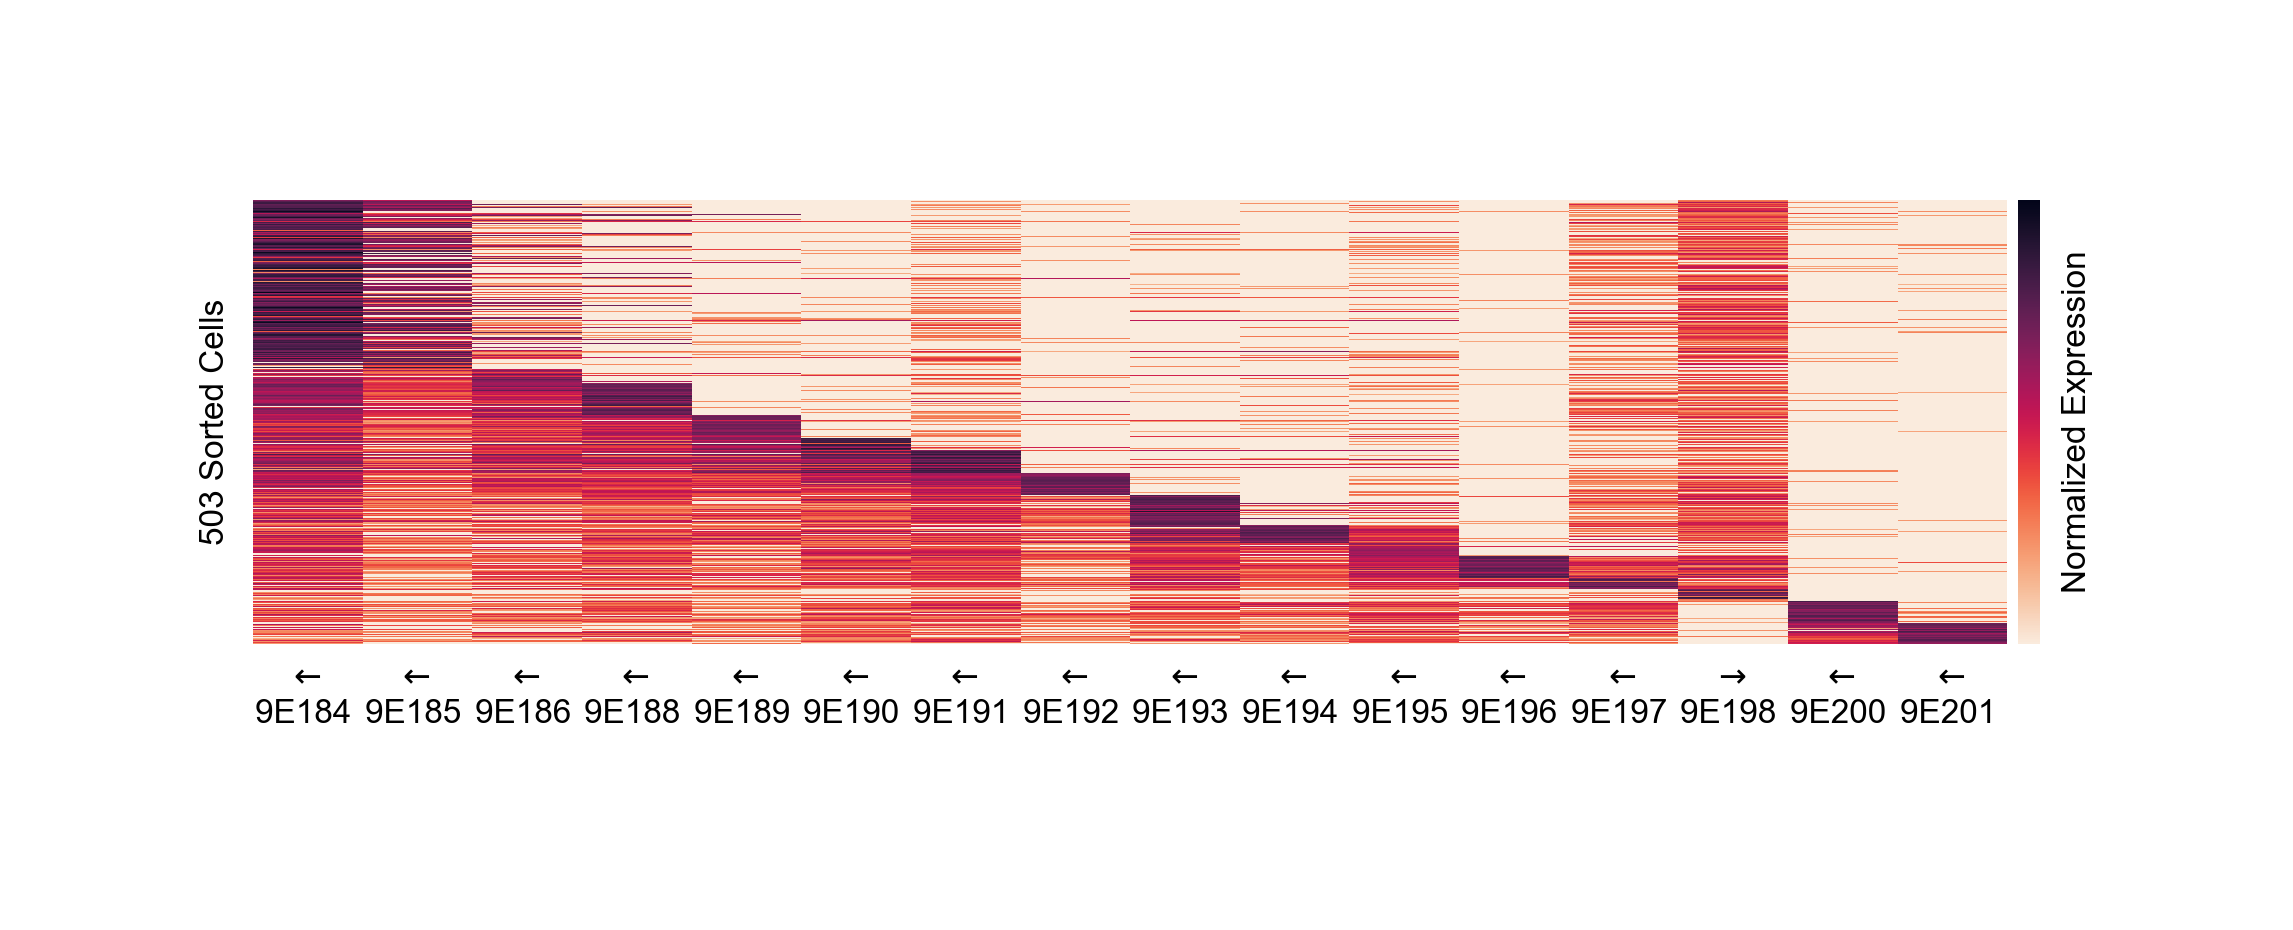

In [106]:
ta_ = 35 
subset = or_db[or_db.tandem_array == ta_]
genes = subset.gene_name.values
cells = adata[adata.obs['valence_TA'] == str(ta_)]
# Only take cells with avg expression of genes > 1 
cells = cells[cells[:, genes].X.mean(axis=1) > 0]
expression = pd.DataFrame(cells[:, genes].X.toarray(), columns=genes, index=cells.obs_names)
expression['top_or'] = expression.idxmax(axis=1)
expression['top_or'] = pd.Categorical(expression['top_or'], categories=genes, ordered=True)
expression = expression.sort_values('top_or', ascending=True)

# Plot a heatmap of the expression data, with or_db gene order on the x axis and expression on the y axis
white_plotting()
fig, ax = plt.subplots(1, 1, figsize=(5.5, 1.5), dpi=200)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
sns.heatmap(expression.iloc[:, :-1], 
            cmap=sns.color_palette("rocket_r", as_cmap=True), 
            ax=ax, 
            xticklabels=True, 
            yticklabels=False, 
            cbar_kws={'pad': 0.005},
            linewidths=0,
            )

cbar = ax.collections[0].colorbar
cbar.set_ticks([])
cbar.set_label('Normalized Expression', fontsize=6) 
# Increase cbar width

ax.set_ylabel(f'{cells.shape[0]} Sorted Cells', fontsize=6)
ax.set_xlabel('')
#ax.set_title(f'Tandem Array {ta_} Expression', fontsize=8)

# Modify the x-tick labels: Remove Or5- prefix and add orientation
xticks = ax.get_xticks()
xticklabels = [x.get_text() for x in ax.get_xticklabels()]
xticklabels = [f"{tr.get_gene(x).strand} \n{x} " for x in xticklabels]
xticklabels = [re.sub('Or5-','',x) for x in xticklabels]
xticklabels = [re.sub(r'(-)', r'$\\leftarrow$', x) for x in xticklabels]
xticklabels = [re.sub(r'(\+)', r'$\\rightarrow$', x) for x in xticklabels]
ax.set_xticklabels(xticklabels, fontsize=6, rotation=0)
ax.tick_params(axis='x', length=0)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"../figures/t35-staircase.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

In [107]:
# Distance from 9E184 to 9E201 
e201_start = or_db.loc[or_db.gene_name == 'Or5-9E201', 'start'].values[0]
e184_start = or_db.loc[or_db.gene_name == 'Or5-9E184', 'start'].values[0]
print(f"Distance from 9E184 to 9E201: {abs(e201_start - e184_start)}")

Distance from 9E184 to 9E201: 122103


## T51 Ladder 

In [108]:
# Make an obs called L_subfamily with the sum of expression of all L subfamily genes (tandem array 3) 
t51 = or_db[or_db.tandem_array == 51].gene_name
adata.obs['t51'] = adata[:, t51].X.mean(axis=1)

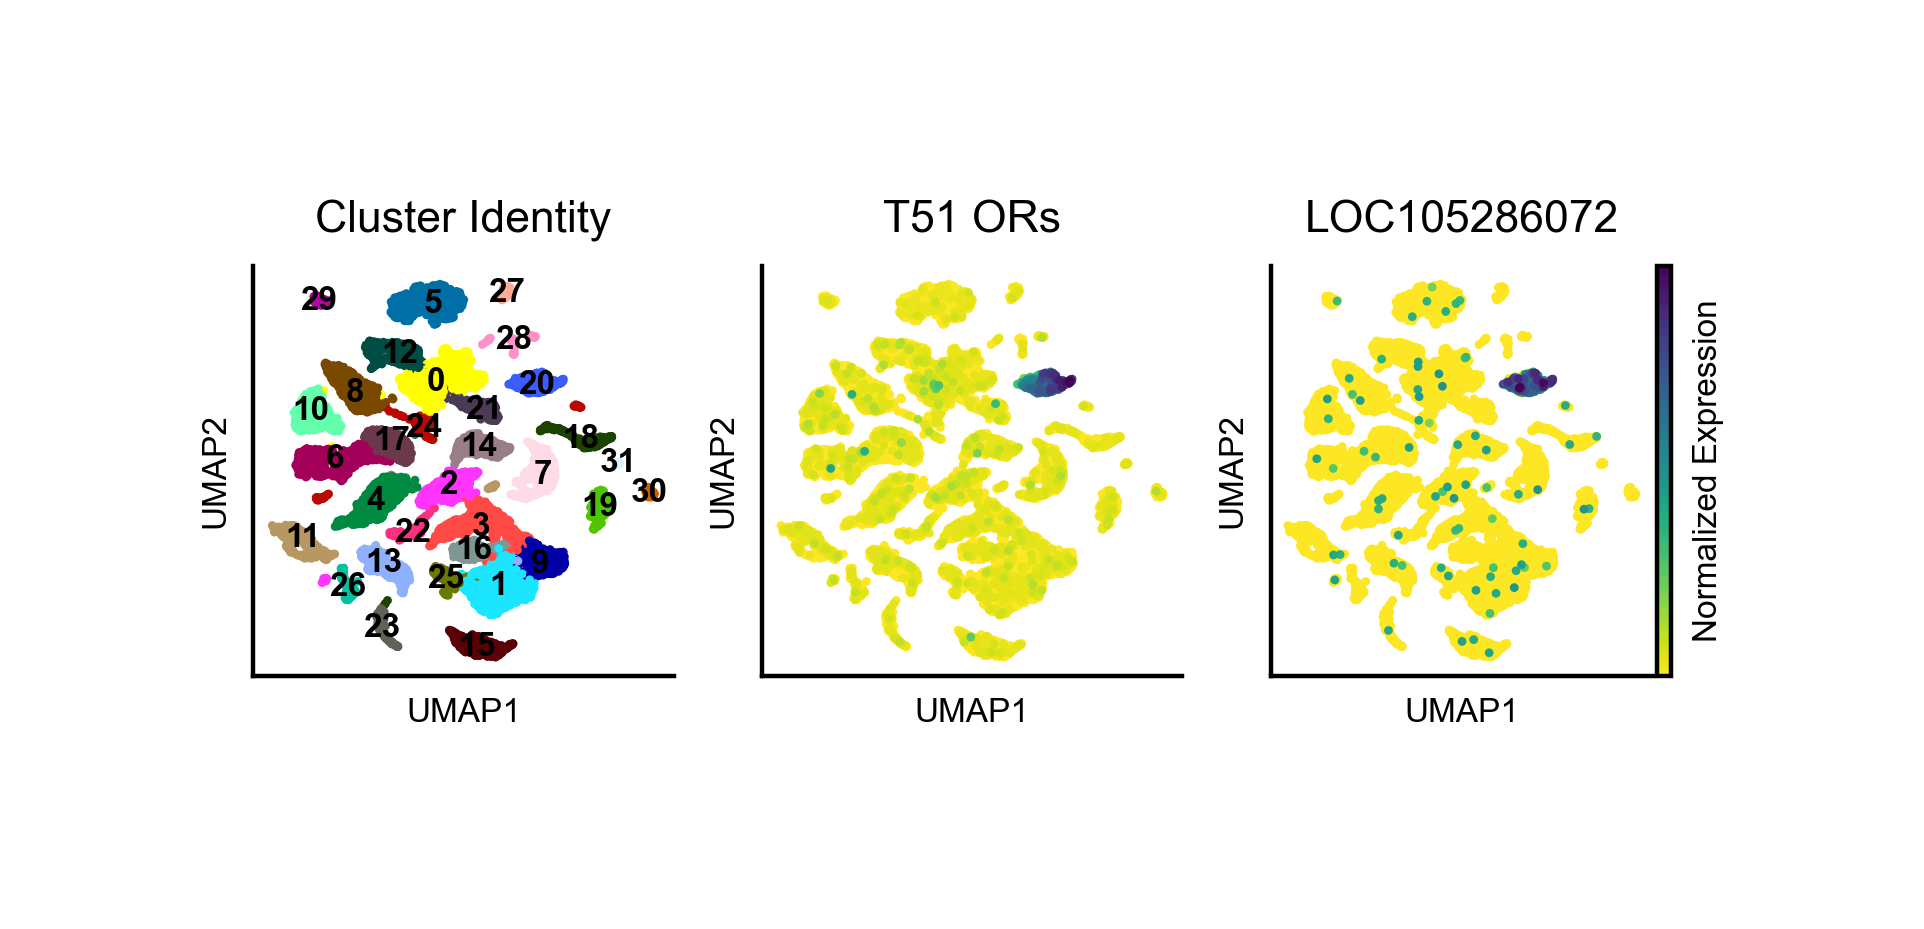

In [109]:
white_plotting()
# Plot 3 UMAPs: cluster identity, T3 expression, and aquaporin expression 
fig, ax = plt.subplots(1, 3, figsize=(4, 1.5), dpi=200)
sc.pl.umap(adata, color='leiden', ax=ax[0], show=False, legend_loc='on data', legend_fontsize=6)
sc.pl.umap(adata, color='t51', ax=ax[1], show=False, color_map='viridis_r')
sc.pl.umap(adata, color='LOC105286072', ax=ax[2], show=False, color_map='viridis_r')

# Titles 
ax[0].set_title('Cluster Identity', fontsize=8)
ax[1].set_title('T51 ORs', fontsize=8)
ax[2].set_title('LOC105286072', fontsize=8)

# Hide bar on ax 1
ax[1].collections[0].colorbar.remove()

# Label cbar on ax 2 
cbar = ax[2].collections[0].colorbar
cbar.set_label('Normalized Expression', fontsize=6)
cbar.set_ticks([])


for i in range(3):
    ax[i].set_xlabel('UMAP1', fontsize=6)
    ax[i].set_ylabel('UMAP2', fontsize=6)
    ax[i].tick_params(axis='both', length=0)
    ax[i].grid(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig(f"../figures/t51-LOC105286072-clusters.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

In [110]:
# Distance from 9E99 to LOC105286072
print(f"Distance from 9E99 to LOC105286072: {abs(tr.get_gene('Or5-9E99').get_transcript_longest_bounds().get_bounds()[0] - tr.get_gene('LOC105286072').get_transcript_longest_bounds().get_bounds()[0])}")

Distance from 9E99 to LOC105286072: 51454


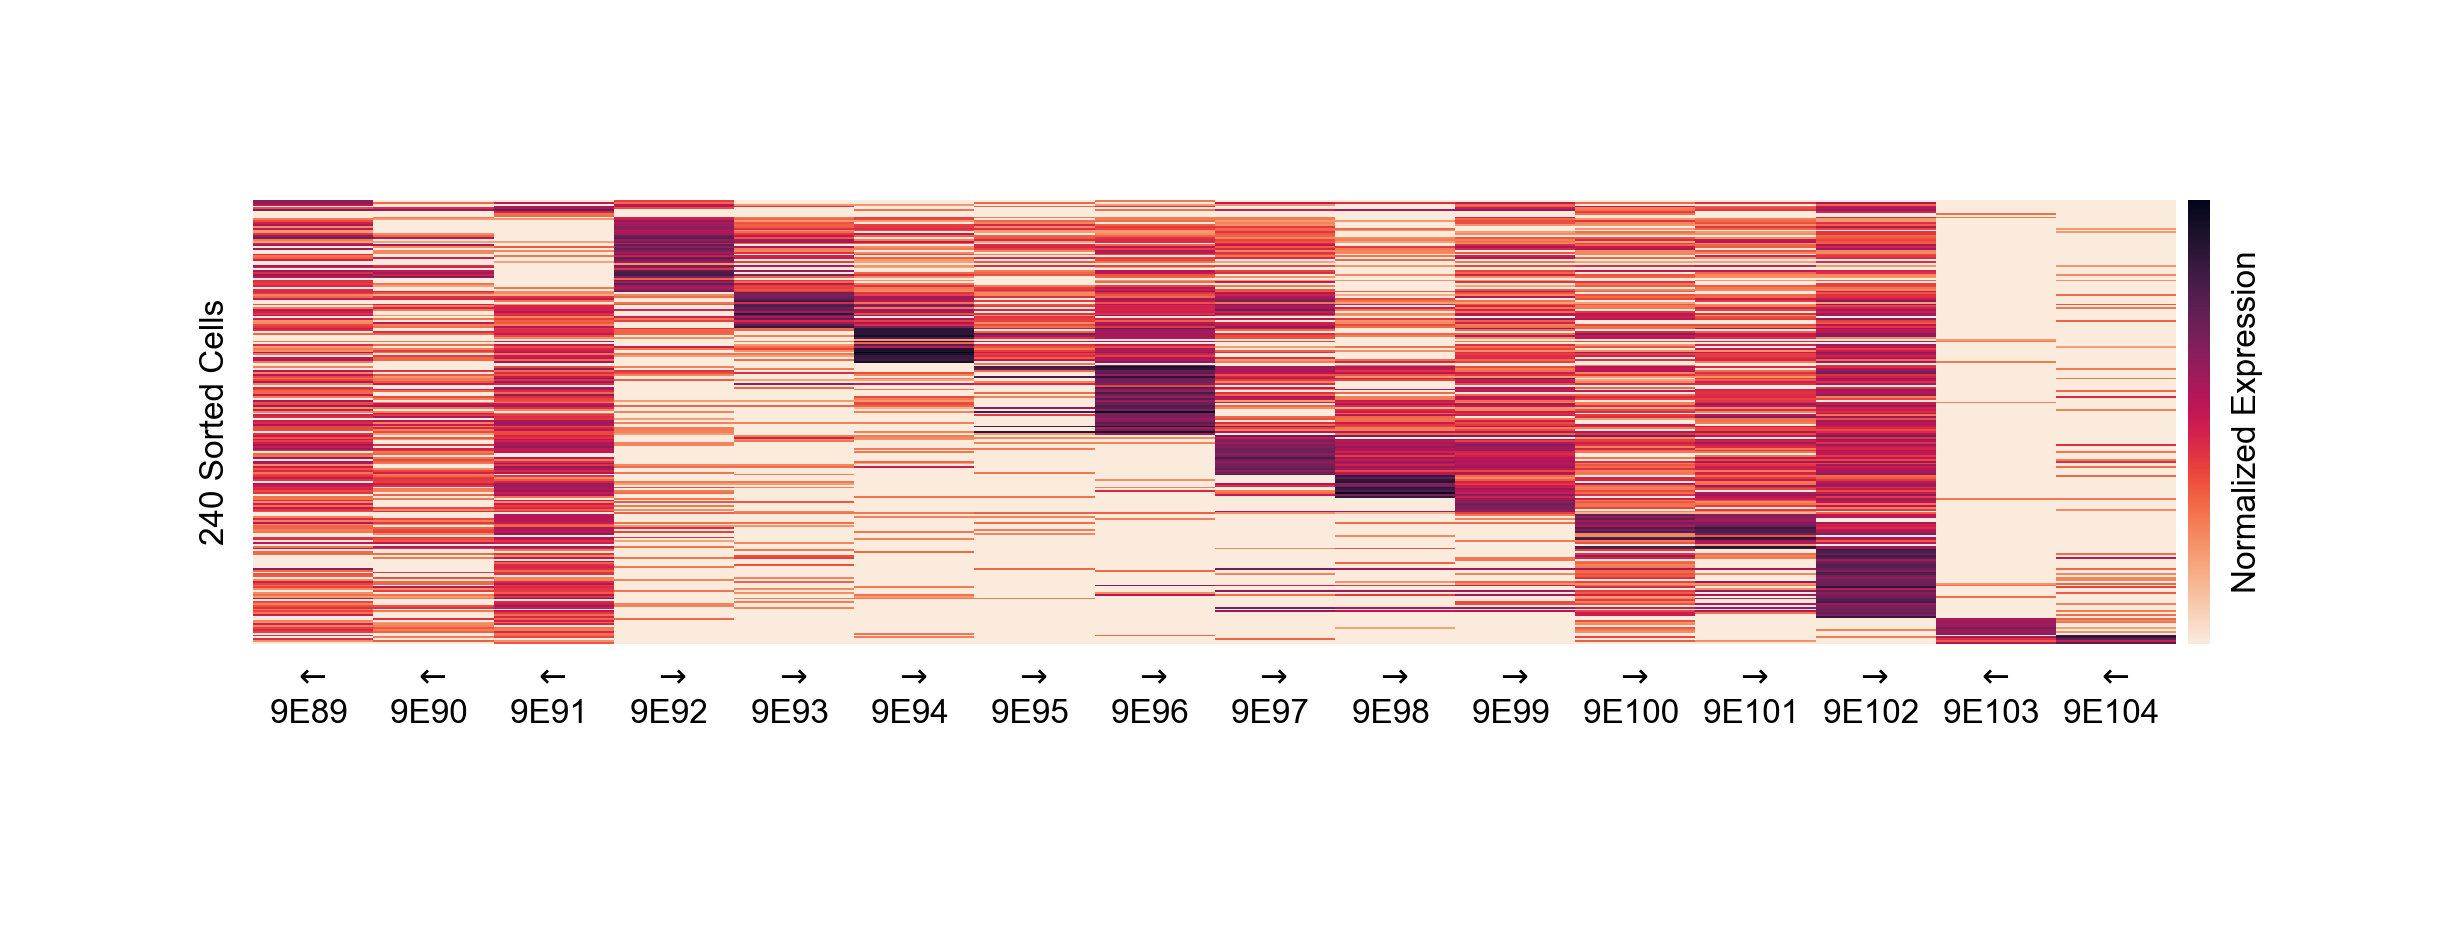

In [111]:
ta_ = 51 
subset = or_db[or_db.tandem_array == ta_]
genes = subset.gene_name.values
cells = adata[adata.obs['valence_TA'] == str(ta_)]
# Only take cells with avg expression of genes > 1 
cells = cells[cells[:, genes].X.mean(axis=1) > 0]
expression = pd.DataFrame(cells[:, genes].X.toarray(), columns=genes, index=cells.obs_names)
expression['top_or'] = expression.idxmax(axis=1)
expression['top_or'] = pd.Categorical(expression['top_or'], categories=genes, ordered=True)
expression = expression.sort_values('top_or', ascending=True)

# Plot a heatmap of the expression data, with or_db gene order on the x axis and expression on the y axis
white_plotting()
fig, ax = plt.subplots(1, 1, figsize=(6, 1.5), dpi=200)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
sns.heatmap(expression.iloc[:, :-1], 
            cmap=sns.color_palette("rocket_r", as_cmap=True), 
            ax=ax, 
            xticklabels=True, 
            yticklabels=False, 
            cbar_kws={'pad': 0.005}
            )

cbar = ax.collections[0].colorbar
cbar.set_ticks([])
cbar.set_label('Normalized Expression', fontsize=6) 
# Increase cbar width

ax.set_ylabel(f'{cells.shape[0]} Sorted Cells', fontsize=6)
ax.set_xlabel('')
#ax.set_title(f'T{ta_}', fontsize=6)

# Modify the x-tick labels: Remove Or5- prefix and add orientation
xticks = ax.get_xticks()
xticklabels = [x.get_text() for x in ax.get_xticklabels()]
xticklabels = [f"{tr.get_gene(x).strand} \n{x} " for x in xticklabels]
xticklabels = [re.sub('Or5-','',x) for x in xticklabels]
xticklabels = [re.sub(r'(-)', r'$\\leftarrow$', x) for x in xticklabels]
xticklabels = [re.sub(r'(\+)', r'$\\rightarrow$', x) for x in xticklabels]
ax.set_xticklabels(xticklabels, fontsize=6, rotation=0)
ax.tick_params(axis='x', length=0)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"../figures/t51-staircase.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## T79 Ladder

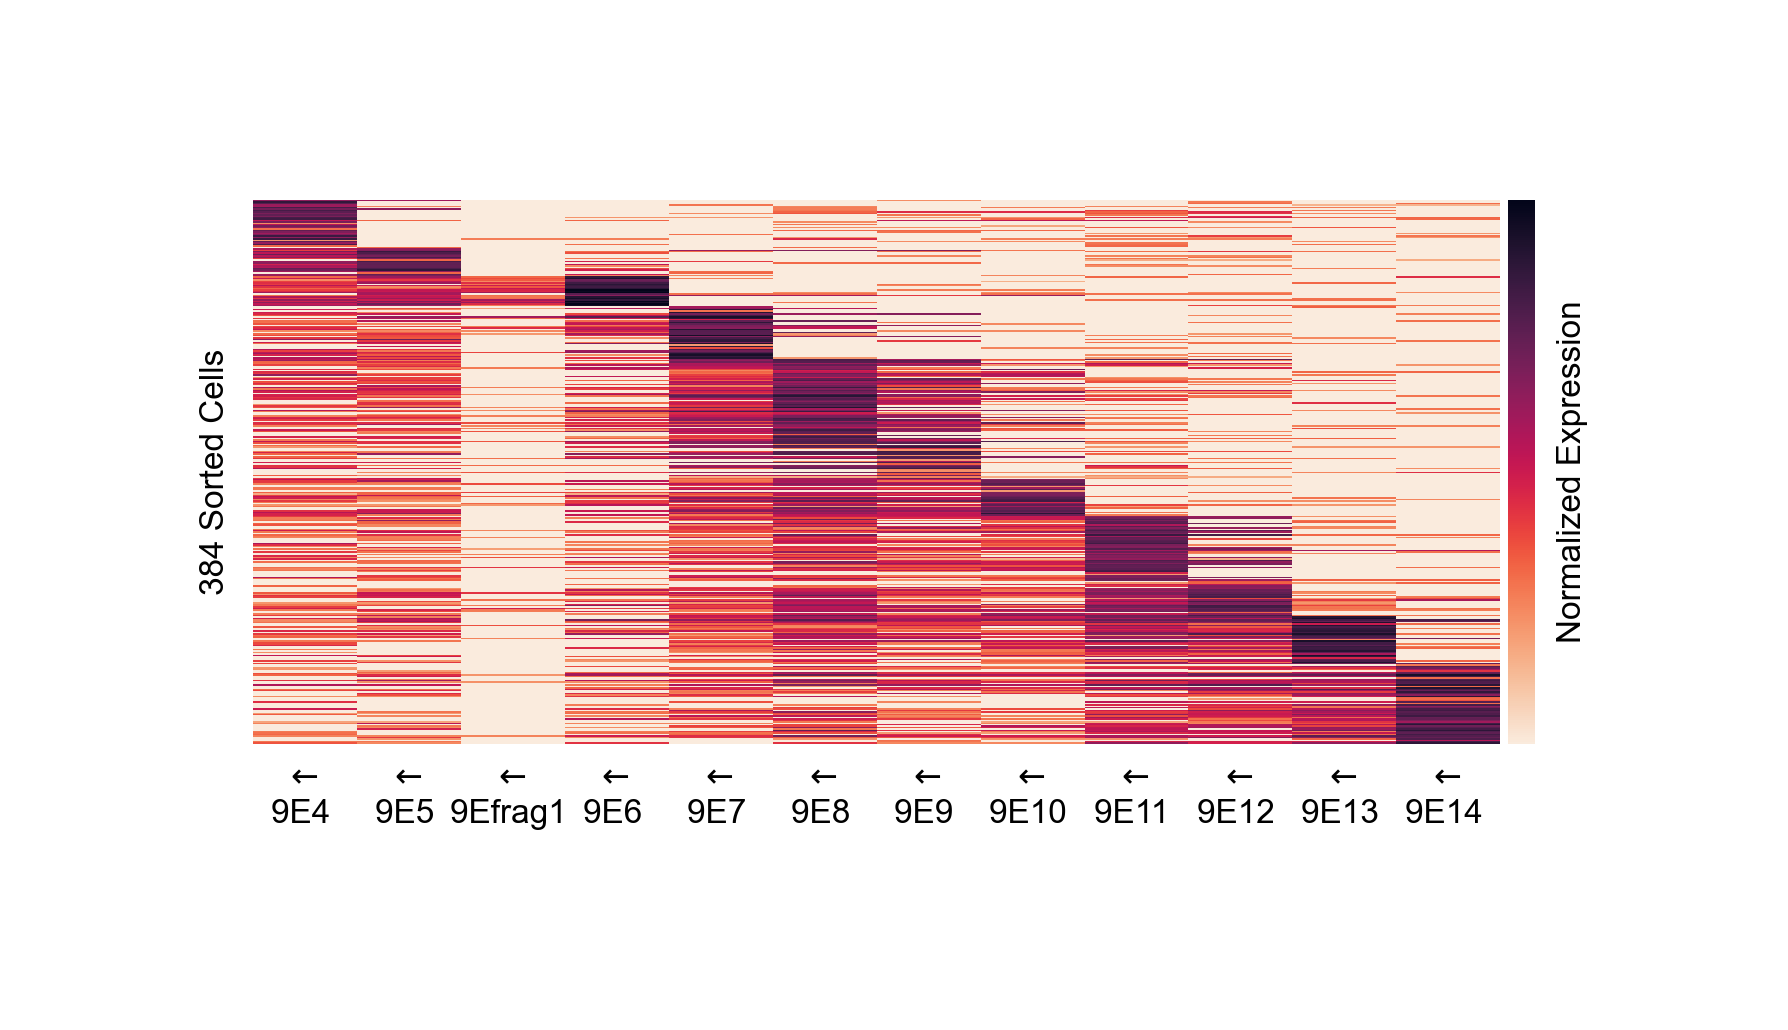

In [112]:
ta_ = 79 
subset = or_db[or_db.tandem_array == ta_]
genes = subset.gene_name.values
cells = adata[adata.obs['valence_TA'] == str(ta_)]
# Only take cells with avg expression of genes > 1 
cells = cells[cells[:, genes].X.mean(axis=1) > 0]
expression = pd.DataFrame(cells[:, genes].X.toarray(), columns=genes, index=cells.obs_names)
expression['top_or'] = expression.idxmax(axis=1)
expression['top_or'] = pd.Categorical(expression['top_or'], categories=genes, ordered=True)
expression = expression.sort_values('top_or', ascending=True)

# Plot a heatmap of the expression data, with or_db gene order on the x axis and expression on the y axis
white_plotting()
fig, ax = plt.subplots(1, 1, figsize=(4, 1.75), dpi=200)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
sns.heatmap(expression.iloc[:, :-1], 
            cmap=sns.color_palette("rocket_r", as_cmap=True), 
            ax=ax, 
            xticklabels=True, 
            yticklabels=False, 
            cbar_kws={'pad': 0.005},
            linewidths=0,
            )

cbar = ax.collections[0].colorbar
cbar.set_ticks([])
cbar.set_label('Normalized Expression', fontsize=6) 
# Increase cbar width

ax.set_ylabel(f'{cells.shape[0]} Sorted Cells', fontsize=6)
ax.set_xlabel('')
#ax.set_title(f'T{ta_}', fontsize=6)

# Modify the x-tick labels: Remove Or5- prefix and add orientation
xticks = ax.get_xticks()
xticklabels = [x.get_text() for x in ax.get_xticklabels()]
xticklabels = [f"{tr.get_gene(x).strand} \n{x} " for x in xticklabels]
xticklabels = [re.sub('Or5-','',x) for x in xticklabels]
xticklabels = [re.sub(r'(-)', r'$\\leftarrow$', x) for x in xticklabels]
xticklabels = [re.sub(r'(\+)', r'$\\rightarrow$', x) for x in xticklabels]
ax.set_xticklabels(xticklabels, fontsize=6, rotation=0)
ax.tick_params(axis='x', length=0)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"../figures/t79-staircase.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## Aquaporin Figure

In [113]:
# Make an obs called L_subfamily with the sum of expression of all L subfamily genes (tandem array 3) 
l_subfamily = or_db[or_db.tandem_array == 3].gene_name
adata.obs['L_subfamily'] = adata[:, l_subfamily].X.mean(axis=1)

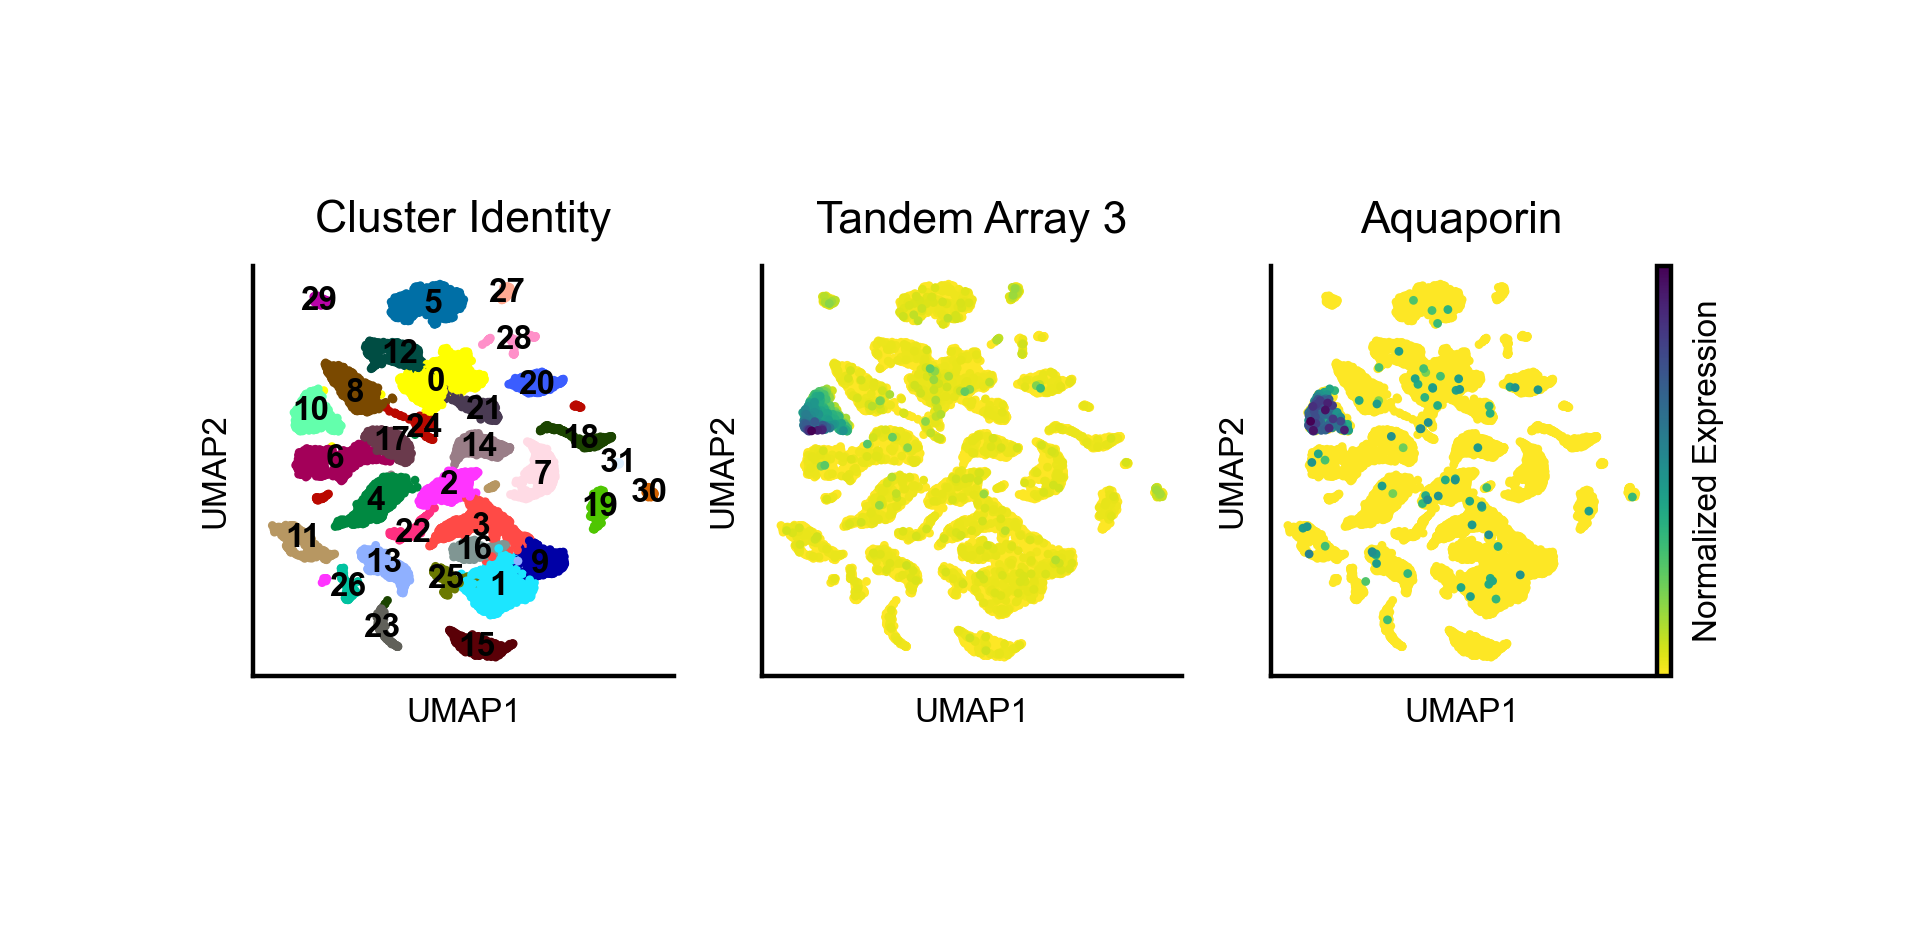

In [114]:
white_plotting() 
fontsize=11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
# Plot 3 UMAPs: cluster identity, T3 expression, and aquaporin expression 
fig, ax = plt.subplots(1, 3, figsize=(4, 1.5), dpi=200)
sc.pl.umap(adata, color='leiden', ax=ax[0], show=False, legend_loc='on data', legend_fontsize=6)
sc.pl.umap(adata, color='L_subfamily', ax=ax[1], show=False, color_map='viridis_r')
sc.pl.umap(adata, color='LOC105284282', ax=ax[2], show=False, color_map='viridis_r')

# Titles 
ax[0].set_title('Cluster Identity', fontsize=8)
ax[1].set_title('Tandem Array 3', fontsize=8)
ax[2].set_title('Aquaporin', fontsize=8)

# Hide bar on ax 1
ax[1].collections[0].colorbar.remove()

# Label cbar on ax 2 
cbar = ax[2].collections[0].colorbar
cbar.set_label('Normalized Expression', fontsize=6)
cbar.set_ticks([])


for i in range(3):
    ax[i].set_xlabel('UMAP1', fontsize=6)
    ax[i].set_ylabel('UMAP2', fontsize=6)
    ax[i].tick_params(axis='both', length=0)
    ax[i].grid(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig(f"../figures/aquaporin-t3-clusters.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## T45 Flanking Genes Figure

In [115]:
# Make an obs called L_subfamily with the sum of expression of all L subfamily genes (tandem array 3) 
t45 = or_db[or_db.tandem_array == 45].gene_name
adata.obs['T45'] = adata[:, t45].X.mean(axis=1)

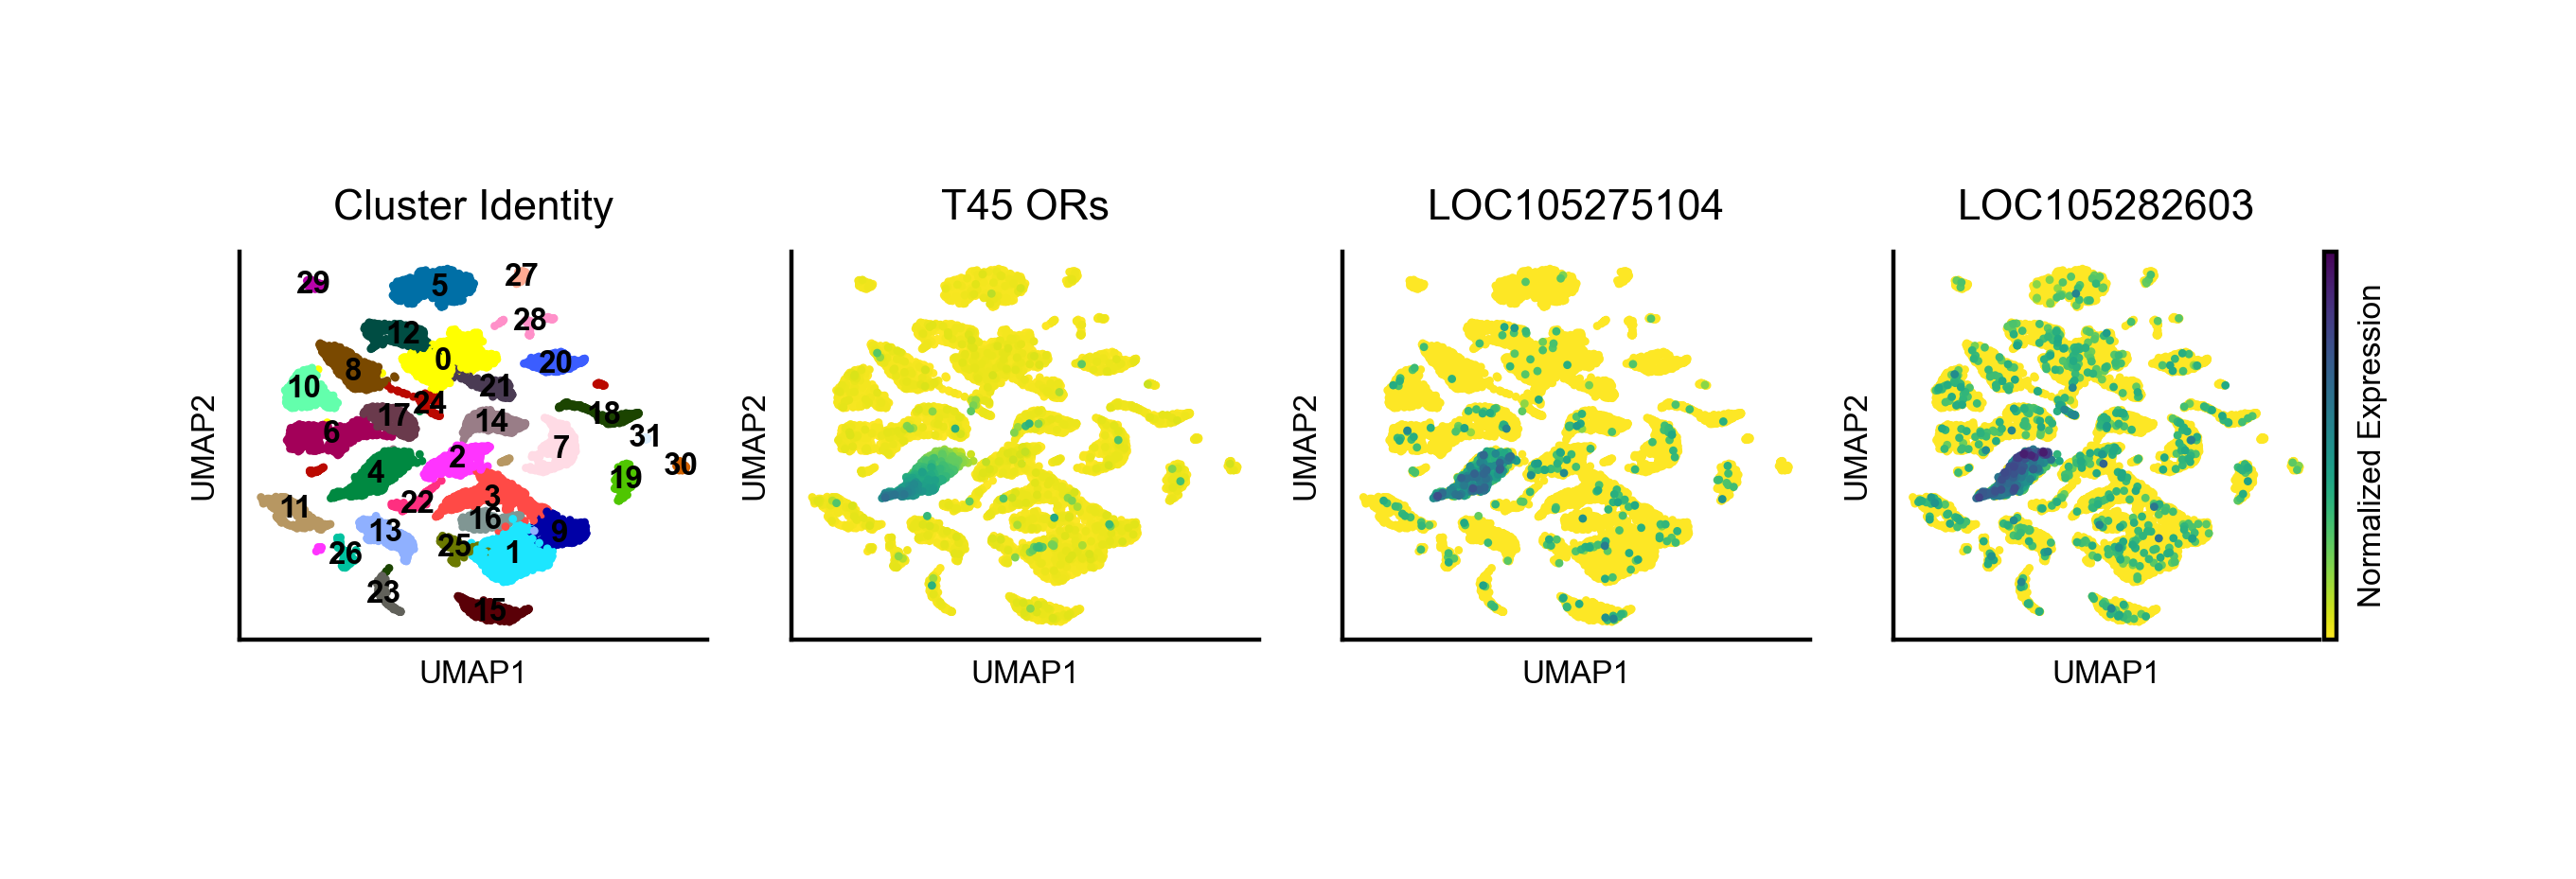

In [116]:
white_plotting() 
fontsize=11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
# Plot 3 UMAPs: cluster identity, T3 expression, and aquaporin expression 
fig, ax = plt.subplots(1, 4, figsize=(6, 1.5), dpi=200)
sc.pl.umap(adata, color='leiden', ax=ax[0], show=False, legend_loc='on data', legend_fontsize=6)
sc.pl.umap(adata, color='T45', ax=ax[1], show=False, vmin=0, vmax=4, color_map='viridis_r')
sc.pl.umap(adata, color='LOC105275104', ax=ax[2], show=False, vmin=0, vmax=4, color_map='viridis_r')
sc.pl.umap(adata, color='LOC105282603', ax=ax[3], show=False, vmin=0, vmax=4, color_map='viridis_r')

# Titles 
ax[0].set_title('Cluster Identity', fontsize=8)
ax[1].set_title('T45 ORs', fontsize=8)
ax[2].set_title('LOC105275104', fontsize=8)
ax[3].set_title("LOC105282603", fontsize=8)

# Hide bar on ax 1
ax[1].collections[0].colorbar.remove()
ax[2].collections[0].colorbar.remove()

# Label cbar on ax 2 
cbar = ax[3].collections[0].colorbar
cbar.set_label('Normalized Expression', fontsize=6)
cbar.set_ticks([])


for i in range(4):
    ax[i].set_xlabel('UMAP1', fontsize=6)
    ax[i].set_ylabel('UMAP2', fontsize=6)
    ax[i].tick_params(axis='both', length=0)
    ax[i].grid(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig(f"../figures/t45-flanking-genes-clusters.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

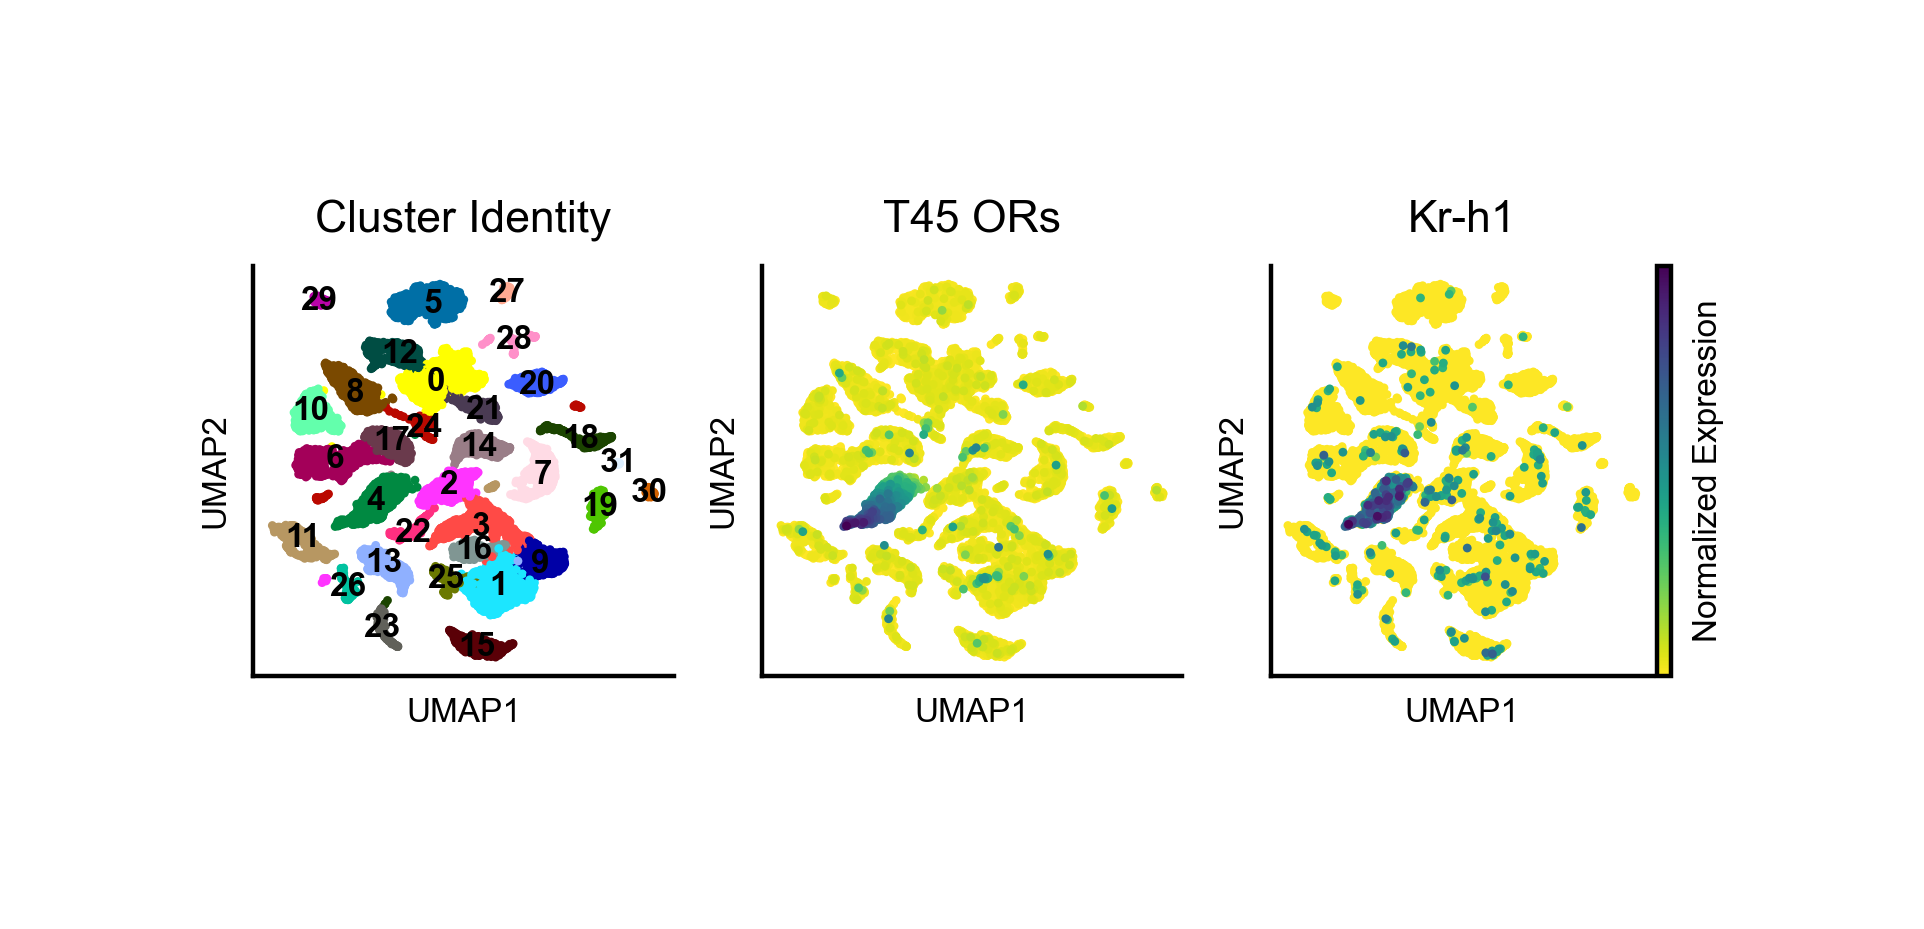

In [117]:
white_plotting() 
fontsize=11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
# Plot 3 UMAPs: cluster identity, T3 expression, and aquaporin expression 
fig, ax = plt.subplots(1, 3, figsize=(4, 1.5), dpi=200)
sc.pl.umap(adata, color='leiden', ax=ax[0], show=False, legend_loc='on data', legend_fontsize=6)
sc.pl.umap(adata, color='T45', ax=ax[1], show=False, color_map='viridis_r') 
sc.pl.umap(adata, color='LOC105275104', ax=ax[2], show=False, color_map='viridis_r') 

# Titles 
ax[0].set_title('Cluster Identity', fontsize=8)
ax[1].set_title('T45 ORs', fontsize=8)
ax[2].set_title('Kr-h1', fontsize=8)

# Hide bar on ax 1
ax[1].collections[0].colorbar.remove()

# Label cbar on ax 2 
cbar = ax[2].collections[0].colorbar
cbar.set_label('Normalized Expression', fontsize=6)
cbar.set_ticks([])

for i in range(3):
    ax[i].set_xlabel('UMAP1', fontsize=6)
    ax[i].set_ylabel('UMAP2', fontsize=6)
    ax[i].tick_params(axis='both', length=0)
    ax[i].grid(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig(f"../figures/LOC105275104-t45-clusters.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

In [118]:
# Distance from 9E116 to LOC105275104
print(f"Distance from 9E116 to LOC105282603: {abs(tr.get_gene('Or5-9E116').get_transcript_longest_bounds().get_bounds()[0] - tr.get_gene('LOC105275104').get_transcript_longest_bounds().get_bounds()[0])}")

Distance from 9E116 to LOC105282603: 106365


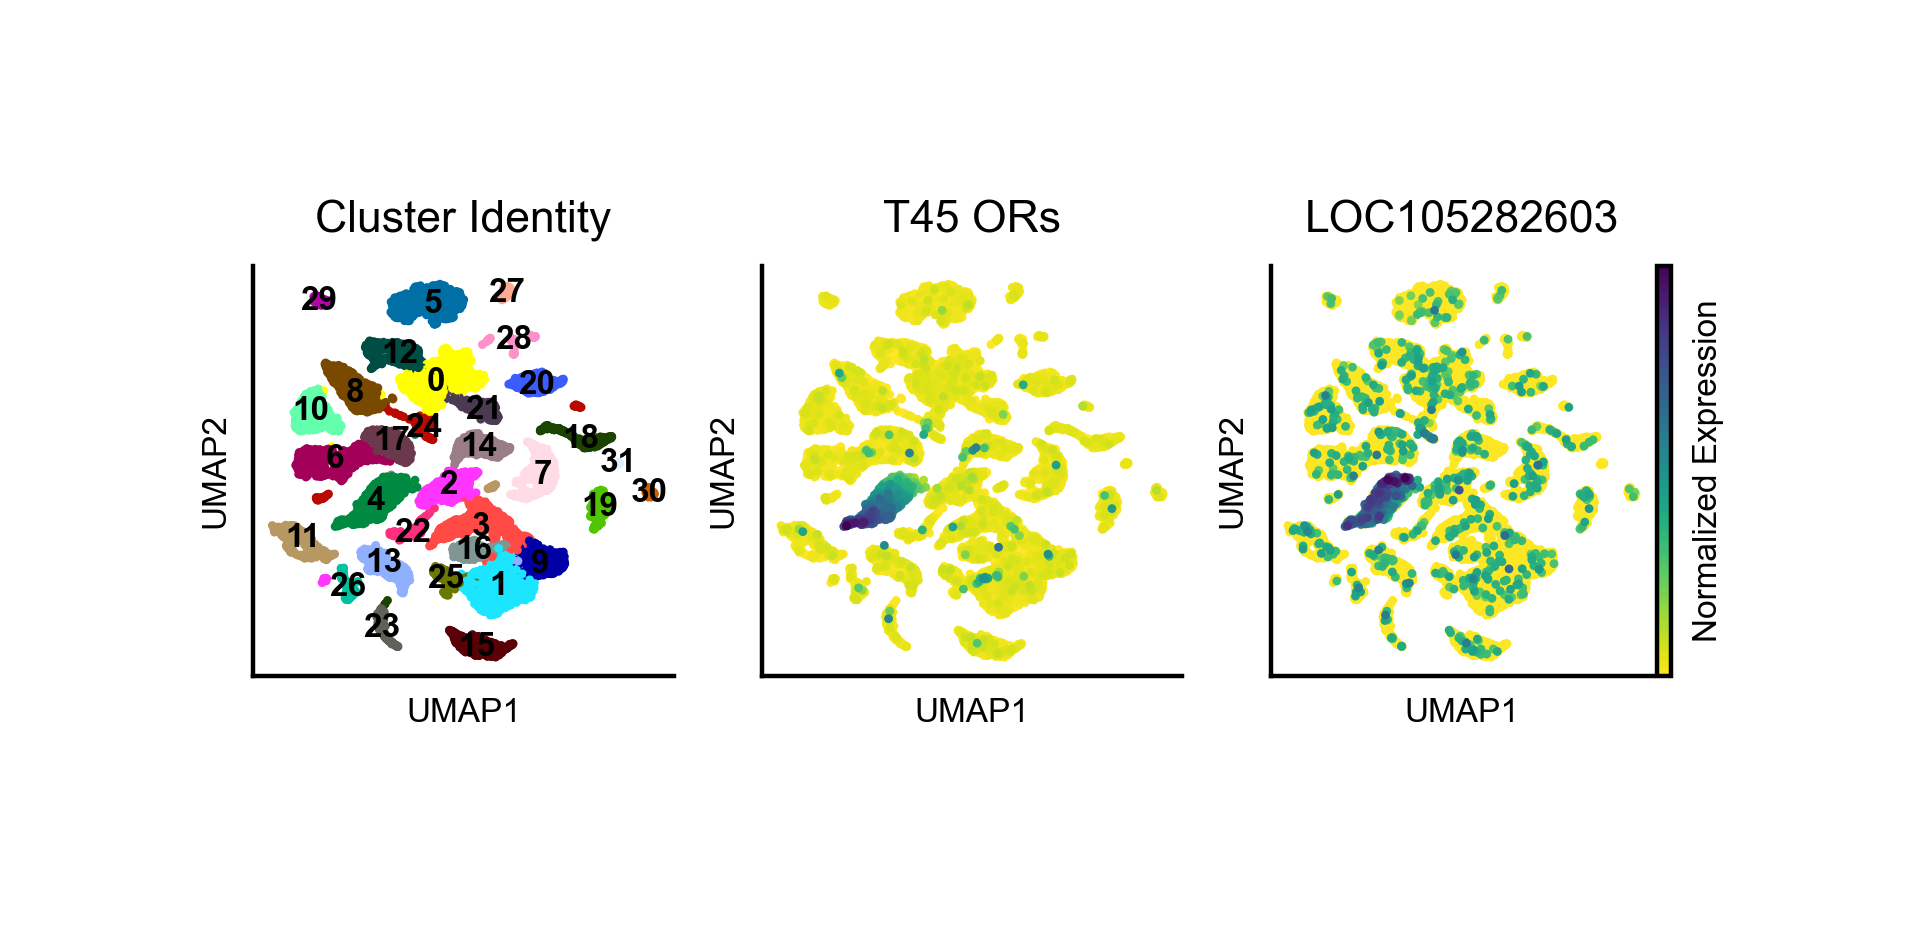

In [119]:
white_plotting() 
fontsize=11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
# Plot 3 UMAPs: cluster identity, T3 expression, and aquaporin expression 
fig, ax = plt.subplots(1, 3, figsize=(4, 1.5), dpi=200)
sc.pl.umap(adata, color='leiden', ax=ax[0], show=False, legend_loc='on data', legend_fontsize=6)
sc.pl.umap(adata, color='T45', ax=ax[1], show=False, color_map='viridis_r') 
sc.pl.umap(adata, color='LOC105282603', ax=ax[2], show=False, color_map='viridis_r') 

# Titles 
ax[0].set_title('Cluster Identity', fontsize=8)
ax[1].set_title('T45 ORs', fontsize=8)
ax[2].set_title('LOC105282603', fontsize=8)

# Hide bar on ax 1
ax[1].collections[0].colorbar.remove()

# Label cbar on ax 2 
cbar = ax[2].collections[0].colorbar
cbar.set_label('Normalized Expression', fontsize=6)
cbar.set_ticks([])

for i in range(3):
    ax[i].set_xlabel('UMAP1', fontsize=6)
    ax[i].set_ylabel('UMAP2', fontsize=6)
    ax[i].tick_params(axis='both', length=0)
    ax[i].grid(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig(f"../figures/LOC105282603-t45-clusters.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

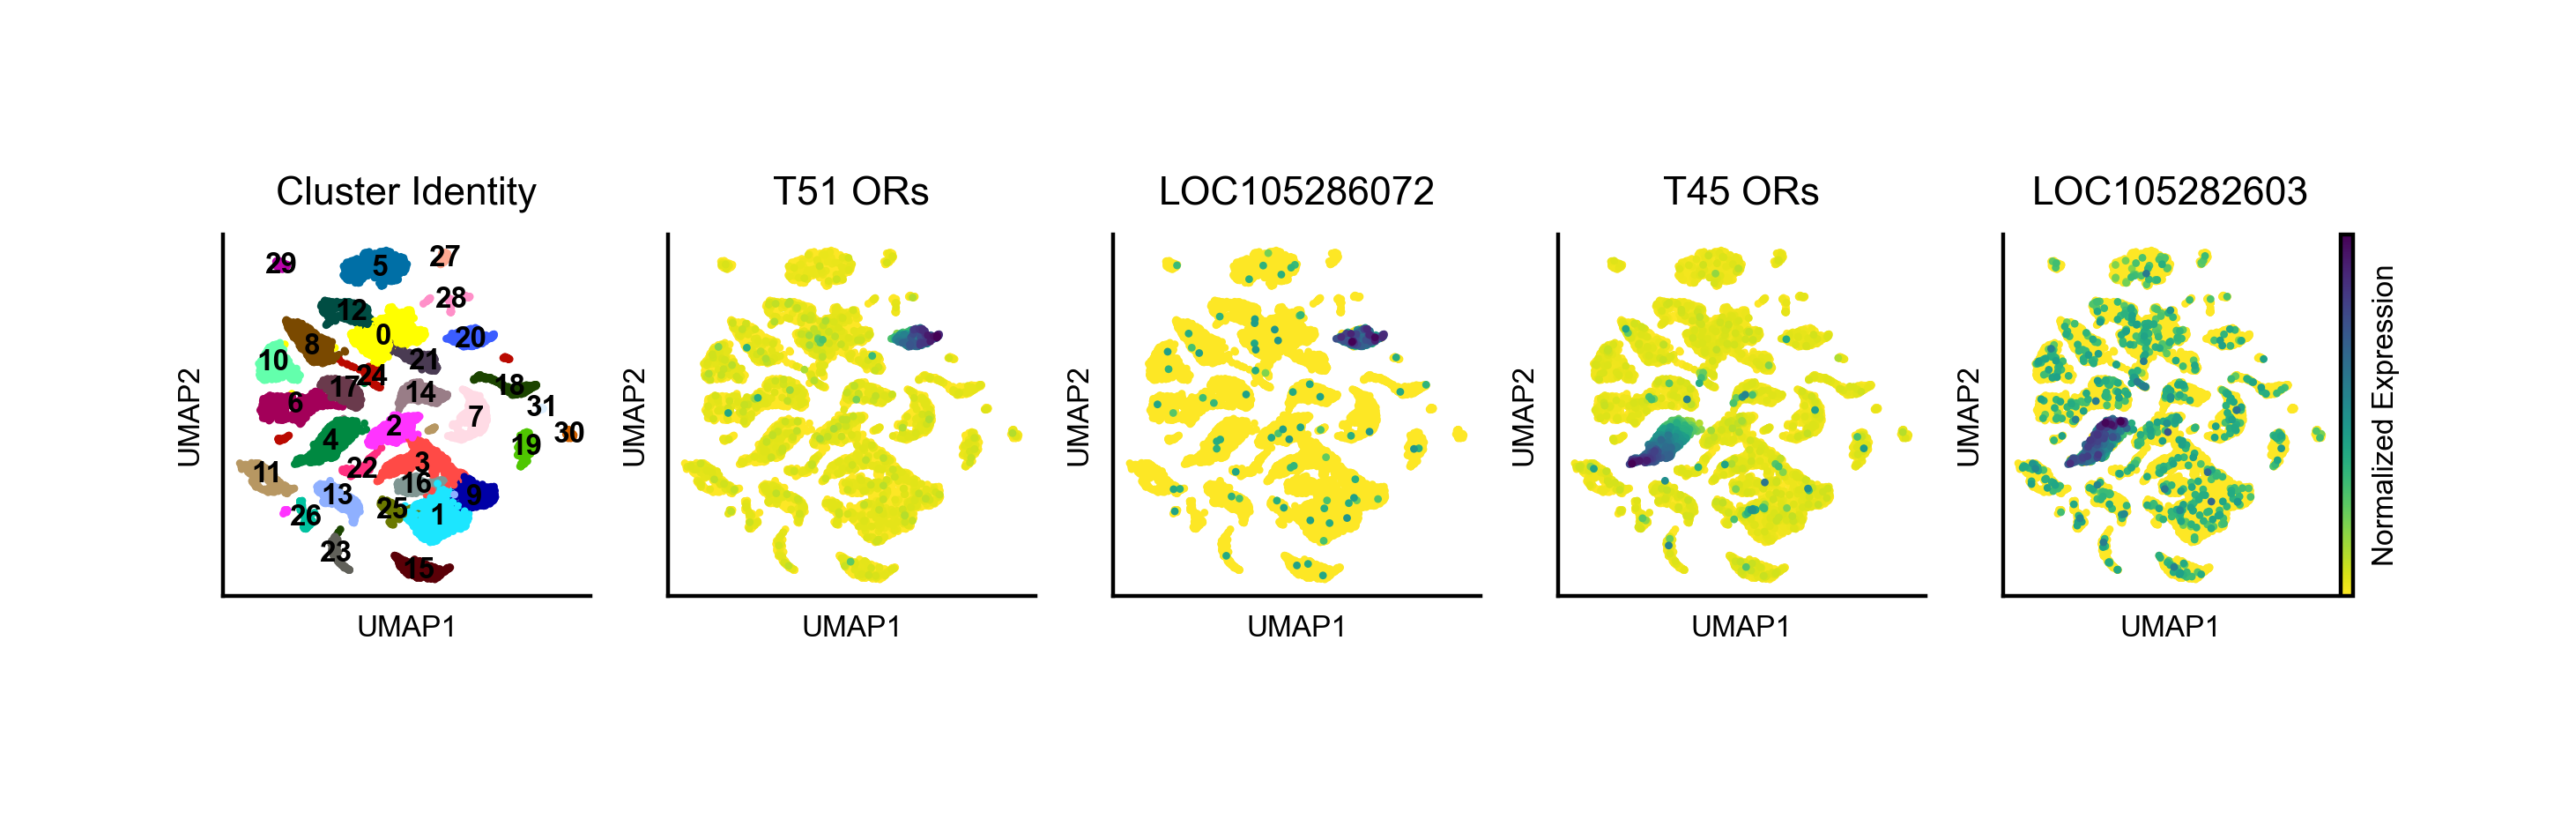

In [120]:
white_plotting() 
fontsize=11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
# Plot 3 UMAPs: cluster identity, T3 expression, and aquaporin expression 
fig, ax = plt.subplots(1, 5, figsize=(6.5, 1.5), dpi=200)
sc.pl.umap(adata, color='leiden', ax=ax[0], show=False, legend_loc='on data', legend_fontsize=6)
sc.pl.umap(adata, color='t51', ax=ax[1], show=False, color_map='viridis_r')
sc.pl.umap(adata, color='LOC105286072', ax=ax[2], show=False, color_map='viridis_r')
sc.pl.umap(adata, color='T45', ax=ax[3], show=False, color_map='viridis_r')
sc.pl.umap(adata, color='LOC105282603', ax=ax[4], show=False, color_map='viridis_r')
# Titles 
ax[0].set_title('Cluster Identity', fontsize=8)
ax[1].set_title('T51 ORs', fontsize=8)
ax[2].set_title('LOC105286072', fontsize=8)
ax[3].set_title('T45 ORs', fontsize=8)
ax[4].set_title('LOC105282603', fontsize=8)

# Hide bar on ax 1
ax[1].collections[0].colorbar.remove()
ax[2].collections[0].colorbar.remove()
ax[3].collections[0].colorbar.remove()

# Label cbar on ax 2 
cbar = ax[4].collections[0].colorbar
cbar.set_label('Normalized Expression', fontsize=6)
cbar.set_ticks([])

for i in range(5):
    ax[i].set_xlabel('UMAP1', fontsize=6)
    ax[i].set_ylabel('UMAP2', fontsize=6)
    ax[i].tick_params(axis='both', length=0)
    ax[i].grid(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig(f"../figures/LOC105282603-T51-LOC105282603-T45-clusters.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

In [121]:
# Distance from 9E116 to LOC105282603
print(f"Distance from 9E116 to LOC105282603: {abs(tr.get_gene('Or5-9E116').get_transcript_longest_bounds().get_bounds()[0] - tr.get_gene('LOC105282603').get_transcript_longest_bounds().get_bounds()[0])}")

Distance from 9E116 to LOC105282603: 81132


## Chymotrypsin Figure

In [122]:
# Make an obs called L_subfamily with the sum of expression of all L subfamily genes (tandem array 3) 
u_subfamily = or_db[or_db.tandem_array == 19].gene_name
print(f"Number of U subfamily genes: {len(u_subfamily)}")
adata.obs['u_subfamily'] = adata[:, u_subfamily].X.mean(axis=1)

Number of U subfamily genes: 55


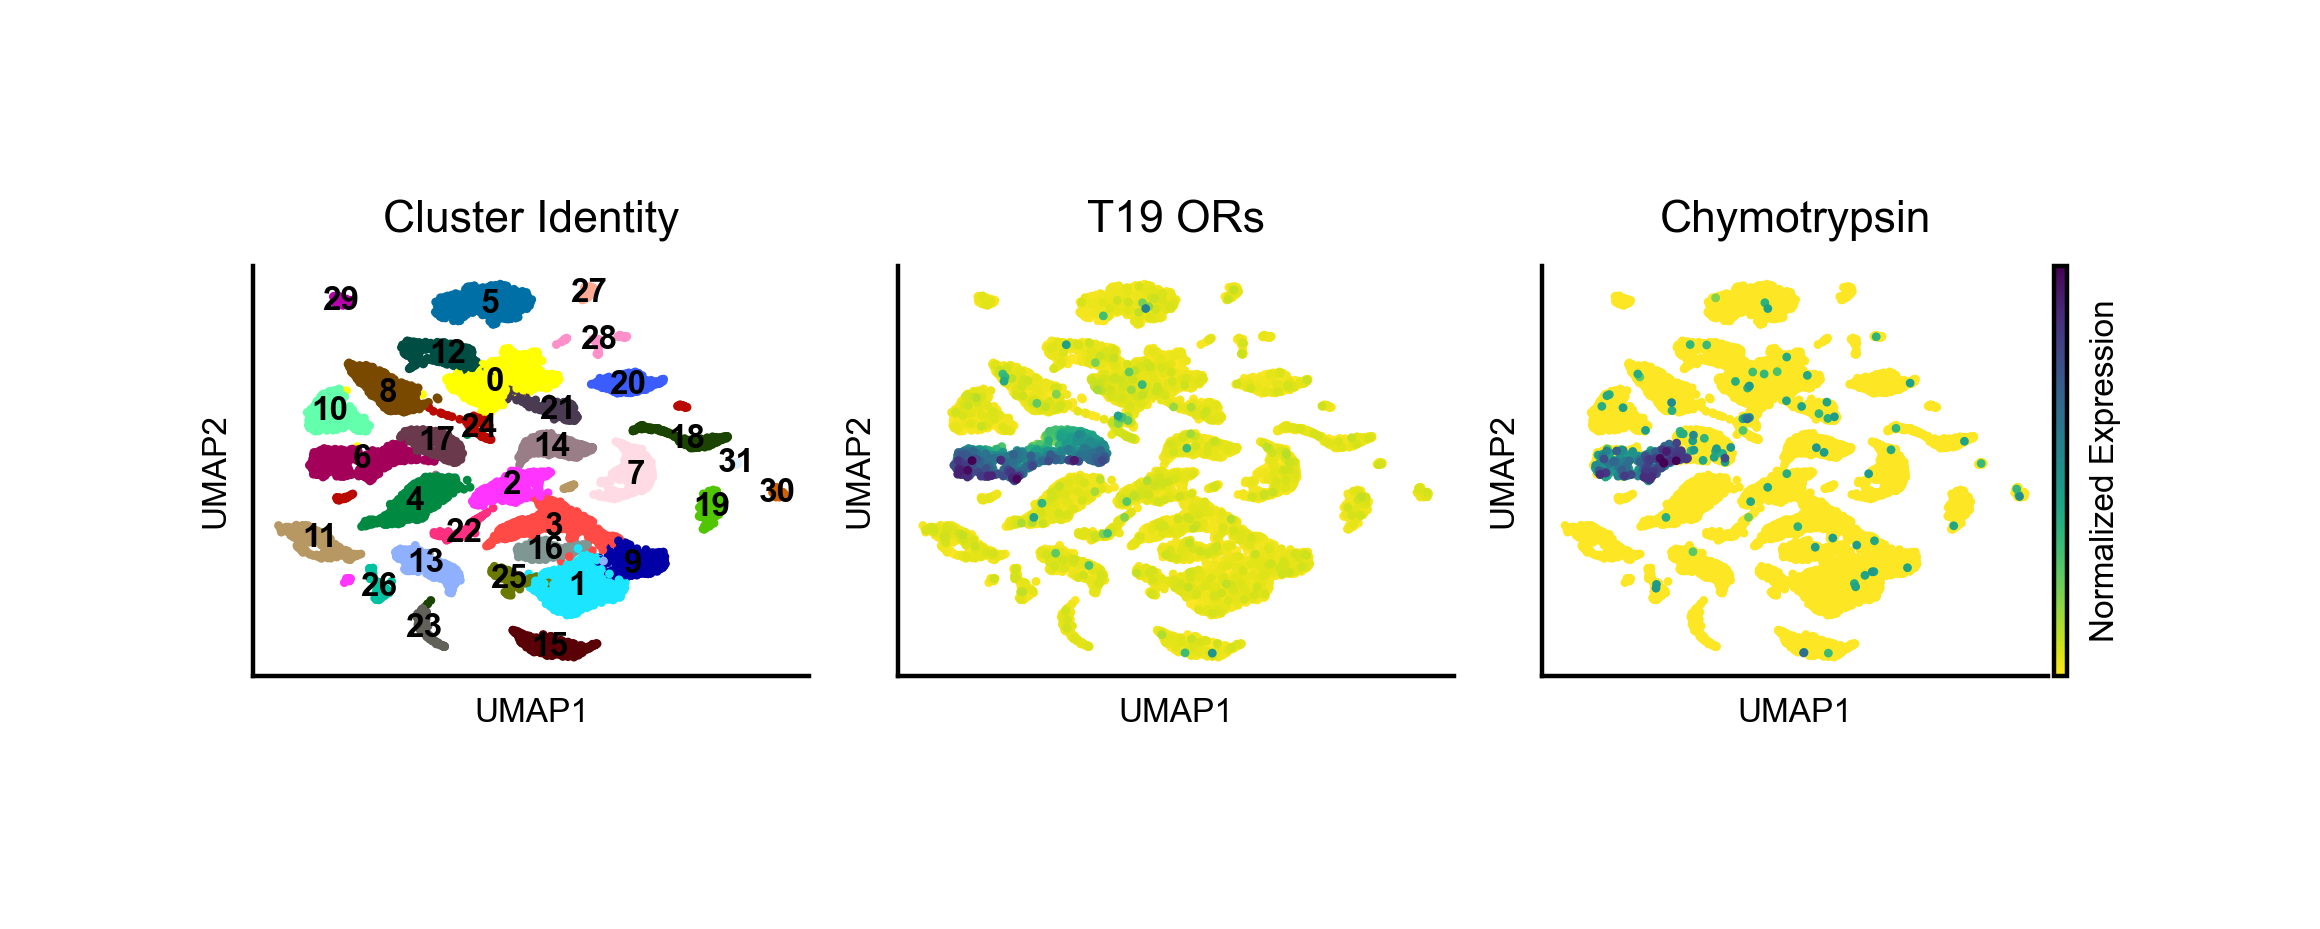

In [123]:
white_plotting() 
fontsize=11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
# Plot 3 UMAPs: cluster identity, T3 expression, and aquaporin expression 
fig, ax = plt.subplots(1, 3, figsize=(5, 1.5), dpi=200)
sc.pl.umap(adata, color='leiden', ax=ax[0], show=False, legend_loc='on data', legend_fontsize=6)
sc.pl.umap(adata, color='u_subfamily', ax=ax[1], show=False, color_map='viridis_r')
sc.pl.umap(adata, color='LOC105276652', ax=ax[2], show=False, color_map='viridis_r')

# Titles 
ax[0].set_title('Cluster Identity', fontsize=8)
ax[1].set_title('T19 ORs', fontsize=8)
ax[2].set_title('Chymotrypsin', fontsize=8)

# Hide bar on ax 1
ax[1].collections[0].colorbar.remove()
#cbar = ax[1].collections[0].colorbar
#cbar.set_label('Normalized Expression', fontsize=6)
#cbar.set_ticks([])

# Label cbar on ax 2 
cbar = ax[2].collections[0].colorbar
cbar.set_label('Normalized Expression', fontsize=6)
cbar.set_ticks([])


for i in range(3):
    ax[i].set_xlabel('UMAP1', fontsize=6)
    ax[i].set_ylabel('UMAP2', fontsize=6)
    ax[i].tick_params(axis='both', length=0)
    ax[i].grid(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig(f"../figures/t19-chymotrypsin-clusters.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## Flanking Genes

In [124]:
# Find all genes with >0 transcripts and min cds_length of 100bp   
all_genes = pd.DataFrame(list(tr.genes.keys()), columns=['gene_name'])
all_genes['num_transcripts'] = all_genes['gene_name'].apply(lambda x: len(tr.get_gene(x).transcripts))
all_genes = all_genes[all_genes['num_transcripts'] > 0].reset_index(drop=True)
all_genes = all_genes[all_genes['gene_name'].str.contains("Or5") == False]
all_genes['biotype'] = all_genes['gene_name'].apply(lambda x: tr.get_gene(x).gene_biotype)
all_genes = all_genes[all_genes['biotype'] == 'protein_coding'].reset_index(drop=True)
all_genes['chromosome'] = all_genes['gene_name'].apply(lambda x: tr.get_gene(x).chromosome)
all_genes['start'] = all_genes['gene_name'].apply(lambda x: tr.get_gene(x).get_transcript_longest_bounds().get_bounds()[0])
all_genes['end'] = all_genes['gene_name'].apply(lambda x: tr.get_gene(x).get_transcript_longest_bounds().get_bounds()[1])
all_genes['strand'] = all_genes['gene_name'].apply(lambda x: tr.get_gene(x).get_transcript_longest_bounds().strand)
all_genes['cds_length'] = all_genes['gene_name'].apply(lambda x: tr.get_gene(x).get_transcript_longest_bounds().cds_length)
all_genes = all_genes[all_genes['cds_length'] > 100].reset_index(drop=True)
all_genes

gene_name  num_transcripts         biotype chromosome     start  \
0          Ickin1-1                1  protein_coding       Chr1  16435852   
1      LOC105274440                1  protein_coding      Chr12  13282046   
2      LOC105274441                1  protein_coding      Chr13   4726034   
3      LOC105274442                3  protein_coding       Chr7  15690304   
4      LOC105274443                6  protein_coding      Chr11   2384962   
...             ...              ...             ...        ...       ...   
11213  LOC113563670                1  protein_coding       Chr2  11435135   
11214  LOC113563671                1  protein_coding       Chr2  11474376   
11215  LOC113563672                1  protein_coding       Chr2  12277401   
11216  LOC113563673                1  protein_coding       Chr2  11481627   
11217  LOC113563675                1  protein_coding       Chr2  14418388   

            end strand  cds_length  
0      16437577      +         375  
1      13282867      +         819  
2       4727348      -        1260  
3      15700848      +        1215  
4       2448095      -        1212  
...         ...    ...         ...  
11213  11437313      +         294  
11214  11475140      -         762  
11215  12280215      +         579  
11216  11482118      +         489  
11217  14423479      +         600  

[11218 rows x 8 columns]

In [125]:
# group or_db by tandem_array and take the strand mode for each tandem array 
or_db_no_orco = or_db[or_db.gene_name != 'Or5-Orco'].reset_index(drop=True)
ta_db = or_db_no_orco.groupby('tandem_array').agg({'tandem_array':'first', 'strand': lambda x: x.mode()[0], 'ta_size': 'first', 'chromosome': 'first', 'start': lambda x: x.min(), 'end': lambda x: x.max()}).reset_index(drop=True)
ta_db = ta_db[ta_db['ta_size'] > 1].reset_index(drop=True)
ta_db['chromosome'] = "Chr" + ta_db['chromosome'].astype(str)
# sort by tandem_array 
ta_db = ta_db.sort_values('tandem_array').reset_index(drop=True)
ta_db

tandem_array strand  ta_size chromosome     start       end
0              3      +       32      Chr12   8696505   8810716
1              9      -        2      Chr11   9778476   9785937
2             10      +        5      Chr11  12234278  12251405
3             11      -        7      Chr11  13604596  13630121
4             12      +        2      Chr10   1372974   1391026
..           ...    ...      ...        ...       ...       ...
33            80      -        4       Chr1  18401037  18422446
34            81      +        2       Chr1  18696653  18705584
35            82      -        3       Chr1  18737581  18752068
36            85      +        3       Chr9   9545011   9559445
37            86      -       16       Chr9  14837358  14910386

[38 rows x 6 columns]

In [126]:
for i, row in ta_db.iterrows(): 
    if row['strand'] == '+':
        # Find closest upstream gene (end < row['start]) argmin of row['start'] - all_genes['end']
        upstream_genes = all_genes[(all_genes['chromosome'] == row['chromosome']) & (all_genes['end'] < row['start'])]
        upstream_genes['distance'] = row['start'] - upstream_genes['end']
        closest_upstream = upstream_genes.loc[upstream_genes['distance'].idxmin()]
        ta_db.at[i, 'upstream'] = closest_upstream['gene_name']
        ta_db.at[i, 'upstream_distance'] = closest_upstream['distance']
        ta_db.at[i, 'upstream_strand'] = closest_upstream['strand']
        ta_db.at[i, 'upstream_cds_length'] = closest_upstream['cds_length']
        ta_db.at[i, 'upstream_in_data'] = closest_upstream['gene_name'] in adata.var_names

        # Find closest downstream gene 
        downstream_genes = all_genes[(all_genes['chromosome'] == row['chromosome']) & (all_genes['start'] > row['end'])]
        downstream_genes['distance'] = downstream_genes['start'] - row['end']
        closest_downstream = downstream_genes.loc[downstream_genes['distance'].idxmin()]
        ta_db.at[i, 'downstream'] = closest_downstream['gene_name']
        ta_db.at[i, 'downstream_distance'] = closest_downstream['distance']
        ta_db.at[i, 'downstream_strand'] = closest_downstream['strand']
        ta_db.at[i, 'downstream_cds_length'] = closest_downstream['cds_length']
        ta_db.at[i, 'downstream_in_data'] = closest_downstream['gene_name'] in adata.var_names
    else:
        # Find closest upstream gene (end < row['start]) argmin of row['start'] - all_genes['end']
        upstream_genes = all_genes[(all_genes['chromosome'] == row['chromosome']) & (all_genes['start'] > row['end'])]
        upstream_genes['distance'] = upstream_genes['start'] - row['end']
        closest_upstream = upstream_genes.loc[upstream_genes['distance'].idxmin()]
        ta_db.at[i, 'upstream'] = closest_upstream['gene_name']
        ta_db.at[i, 'upstream_distance'] = closest_upstream['distance']
        ta_db.at[i, 'upstream_strand'] = closest_upstream['strand']
        ta_db.at[i, 'upstream_cds_length'] = closest_upstream['cds_length']
        ta_db.at[i, 'upstream_in_data'] = closest_upstream['gene_name'] in adata.var_names

        # Find closest downstream gene 
        downstream_genes = all_genes[(all_genes['chromosome'] == row['chromosome']) & (all_genes['end'] < row['start'])]
        downstream_genes['distance'] = row['start'] - downstream_genes['end']
        closest_downstream = downstream_genes.loc[downstream_genes['distance'].idxmin()]
        ta_db.at[i, 'downstream'] = closest_downstream['gene_name']
        ta_db.at[i, 'downstream_distance'] = closest_downstream['distance']
        ta_db.at[i, 'downstream_strand'] = closest_downstream['strand']
        ta_db.at[i, 'downstream_cds_length'] = closest_downstream['cds_length']
        ta_db.at[i, 'downstream_in_data'] = closest_downstream['gene_name'] in adata.var_names

In [127]:
# Get relative strand 
ta_db['upstream_opp_strand'] = ta_db.apply(lambda x: x['upstream_strand'] != x['strand'], axis=1)
ta_db['downstream_same_strand'] = ta_db.apply(lambda x: x['downstream_strand'] == x['strand'], axis=1)

In [128]:
ta_db_melted = ta_db.melt(id_vars=['tandem_array', 'strand', 'ta_size'],
                            value_vars=['upstream', 'downstream'],
                            var_name='direction',
                            value_name='gene_name')

ta_db_melted['in_data'] = ta_db_melted.apply(lambda x: x['gene_name'] in adata.var_names, axis=1)

ta_db_melted['distance'] = ta_db_melted.apply(lambda x: 
                                               ta_db.loc[ta_db['upstream'] == x['gene_name']]['upstream_distance'].values[0] if x['direction'] == 'upstream' else
                                                ta_db.loc[ta_db['downstream'] == x['gene_name']]['downstream_distance'].values[0], axis=1)

ta_db_melted['model_orientation'] = ta_db_melted.apply(lambda x: 
                                               ta_db.loc[ta_db['upstream'] == x['gene_name']]['upstream_opp_strand'].values[0] if x['direction'] == 'upstream' else
                                                ta_db.loc[ta_db['downstream'] == x['gene_name']]['downstream_same_strand'].values[0], axis=1)

ta_db_melted = ta_db_melted[ta_db_melted['in_data']].reset_index(drop=True)

In [129]:
# Save ta_db 
ta_db.to_csv("~/Downloads/flanking_genes_ta_db.csv", index=False)

In [130]:
# Make a dataframe with cell ID in a column and individual columns for each OR 
cell_or_expression = pd.DataFrame(index=adata.obs.index, columns=or_db.gene_name)
for i, row in or_db.iterrows(): 
    cell_or_expression[row.gene_name] = adata[:,row['gene_name']].X.toarray().flatten()

In [131]:
# Assign valence TAs based on the max expression of the ORs in each cell
valence_ORs = cell_or_expression.idxmax(axis=1).values.tolist() 
valence_TAs = np.array([str(or_db.loc[or_db.gene_name == x, 'tandem_array'].values[0]) for x in valence_ORs]).astype(str)
adata.obs['valence_TA'] = valence_TAs 

In [132]:
# Remove rows from ta_db_melted where tandem_array is not in valence_TAs
ta_db_melted = ta_db_melted[ta_db_melted['tandem_array'].astype(str).isin(valence_TAs)].reset_index(drop=True)

In [133]:
# Tandem array assignment 
tandem_array_matrix = pd.DataFrame(0, index=adata.obs_names, columns=or_db['tandem_array'].unique().astype(str))
for array in or_db['tandem_array'].unique():
    tandem_array_matrix[array] = adata[:, or_db[or_db['tandem_array'] == array]['gene_name']].X.sum(axis=1)

# Add the tandem array matrix to the data 
adata.obsm['tandem_array'] = tandem_array_matrix.values

# Assign clusters to cells based on the tandem array with the highest expression
adata.obs['tandem_array_cluster'] = tandem_array_matrix.idxmax(axis=1).values.astype(str) 

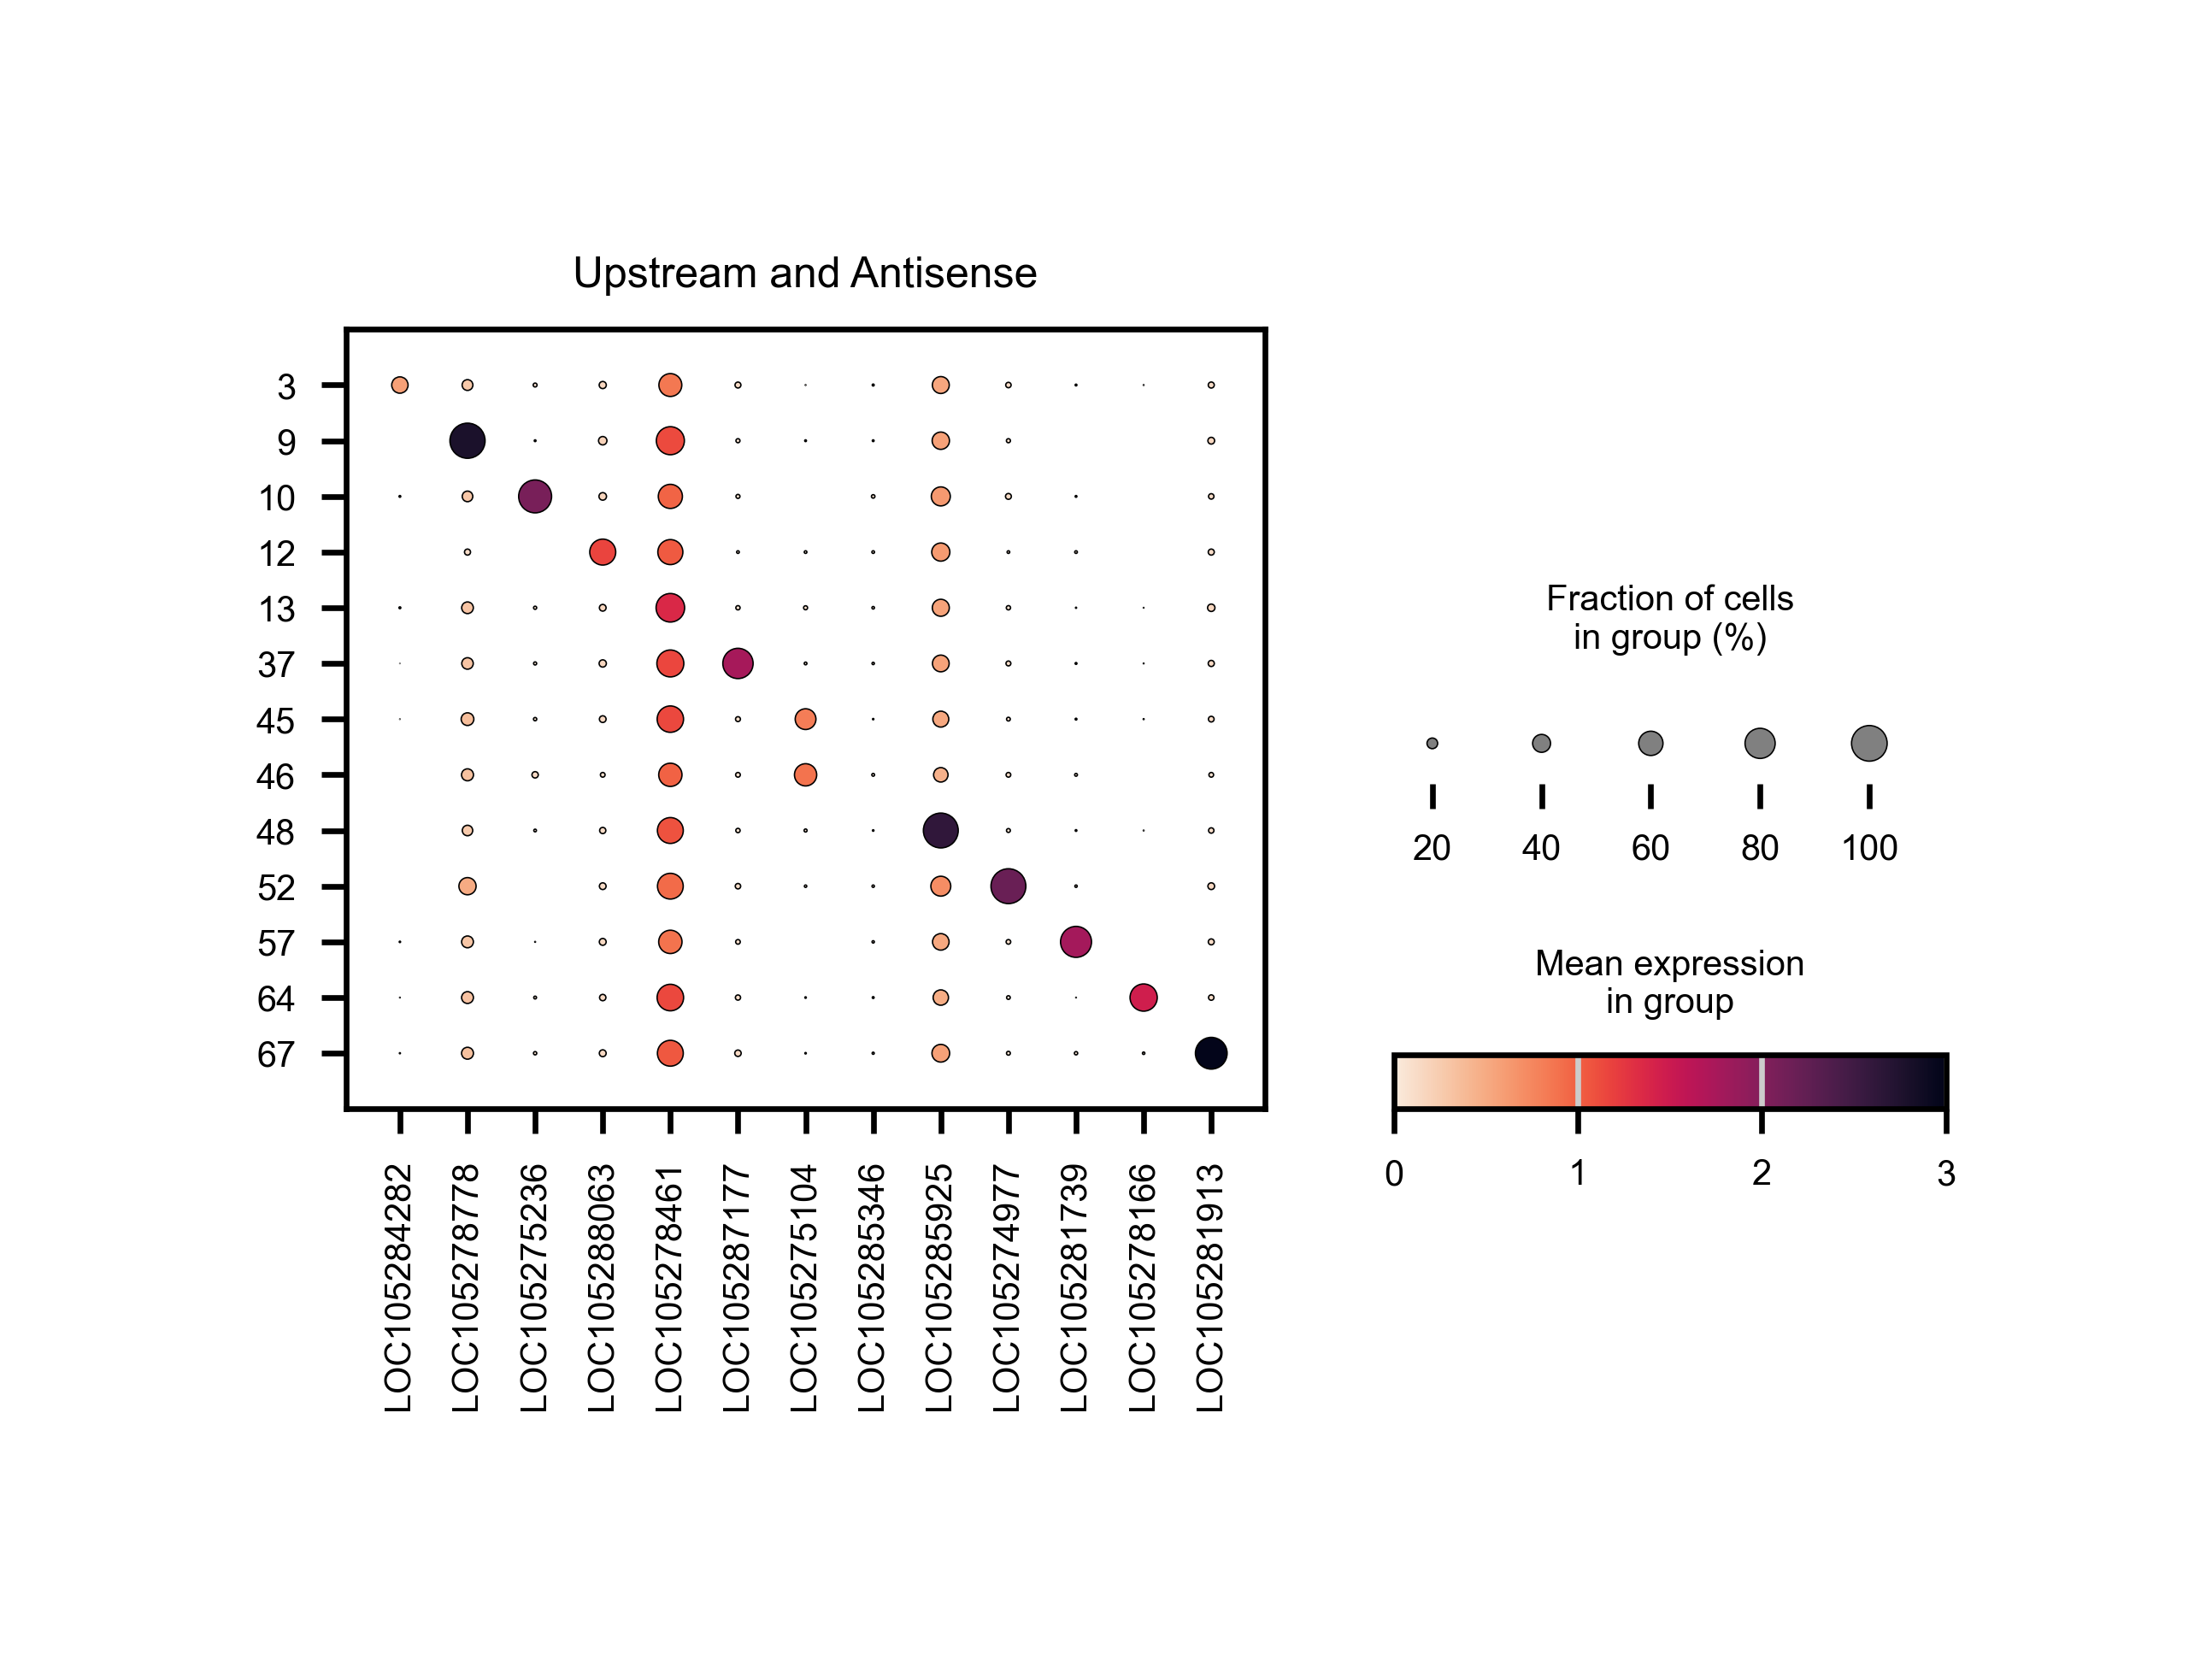

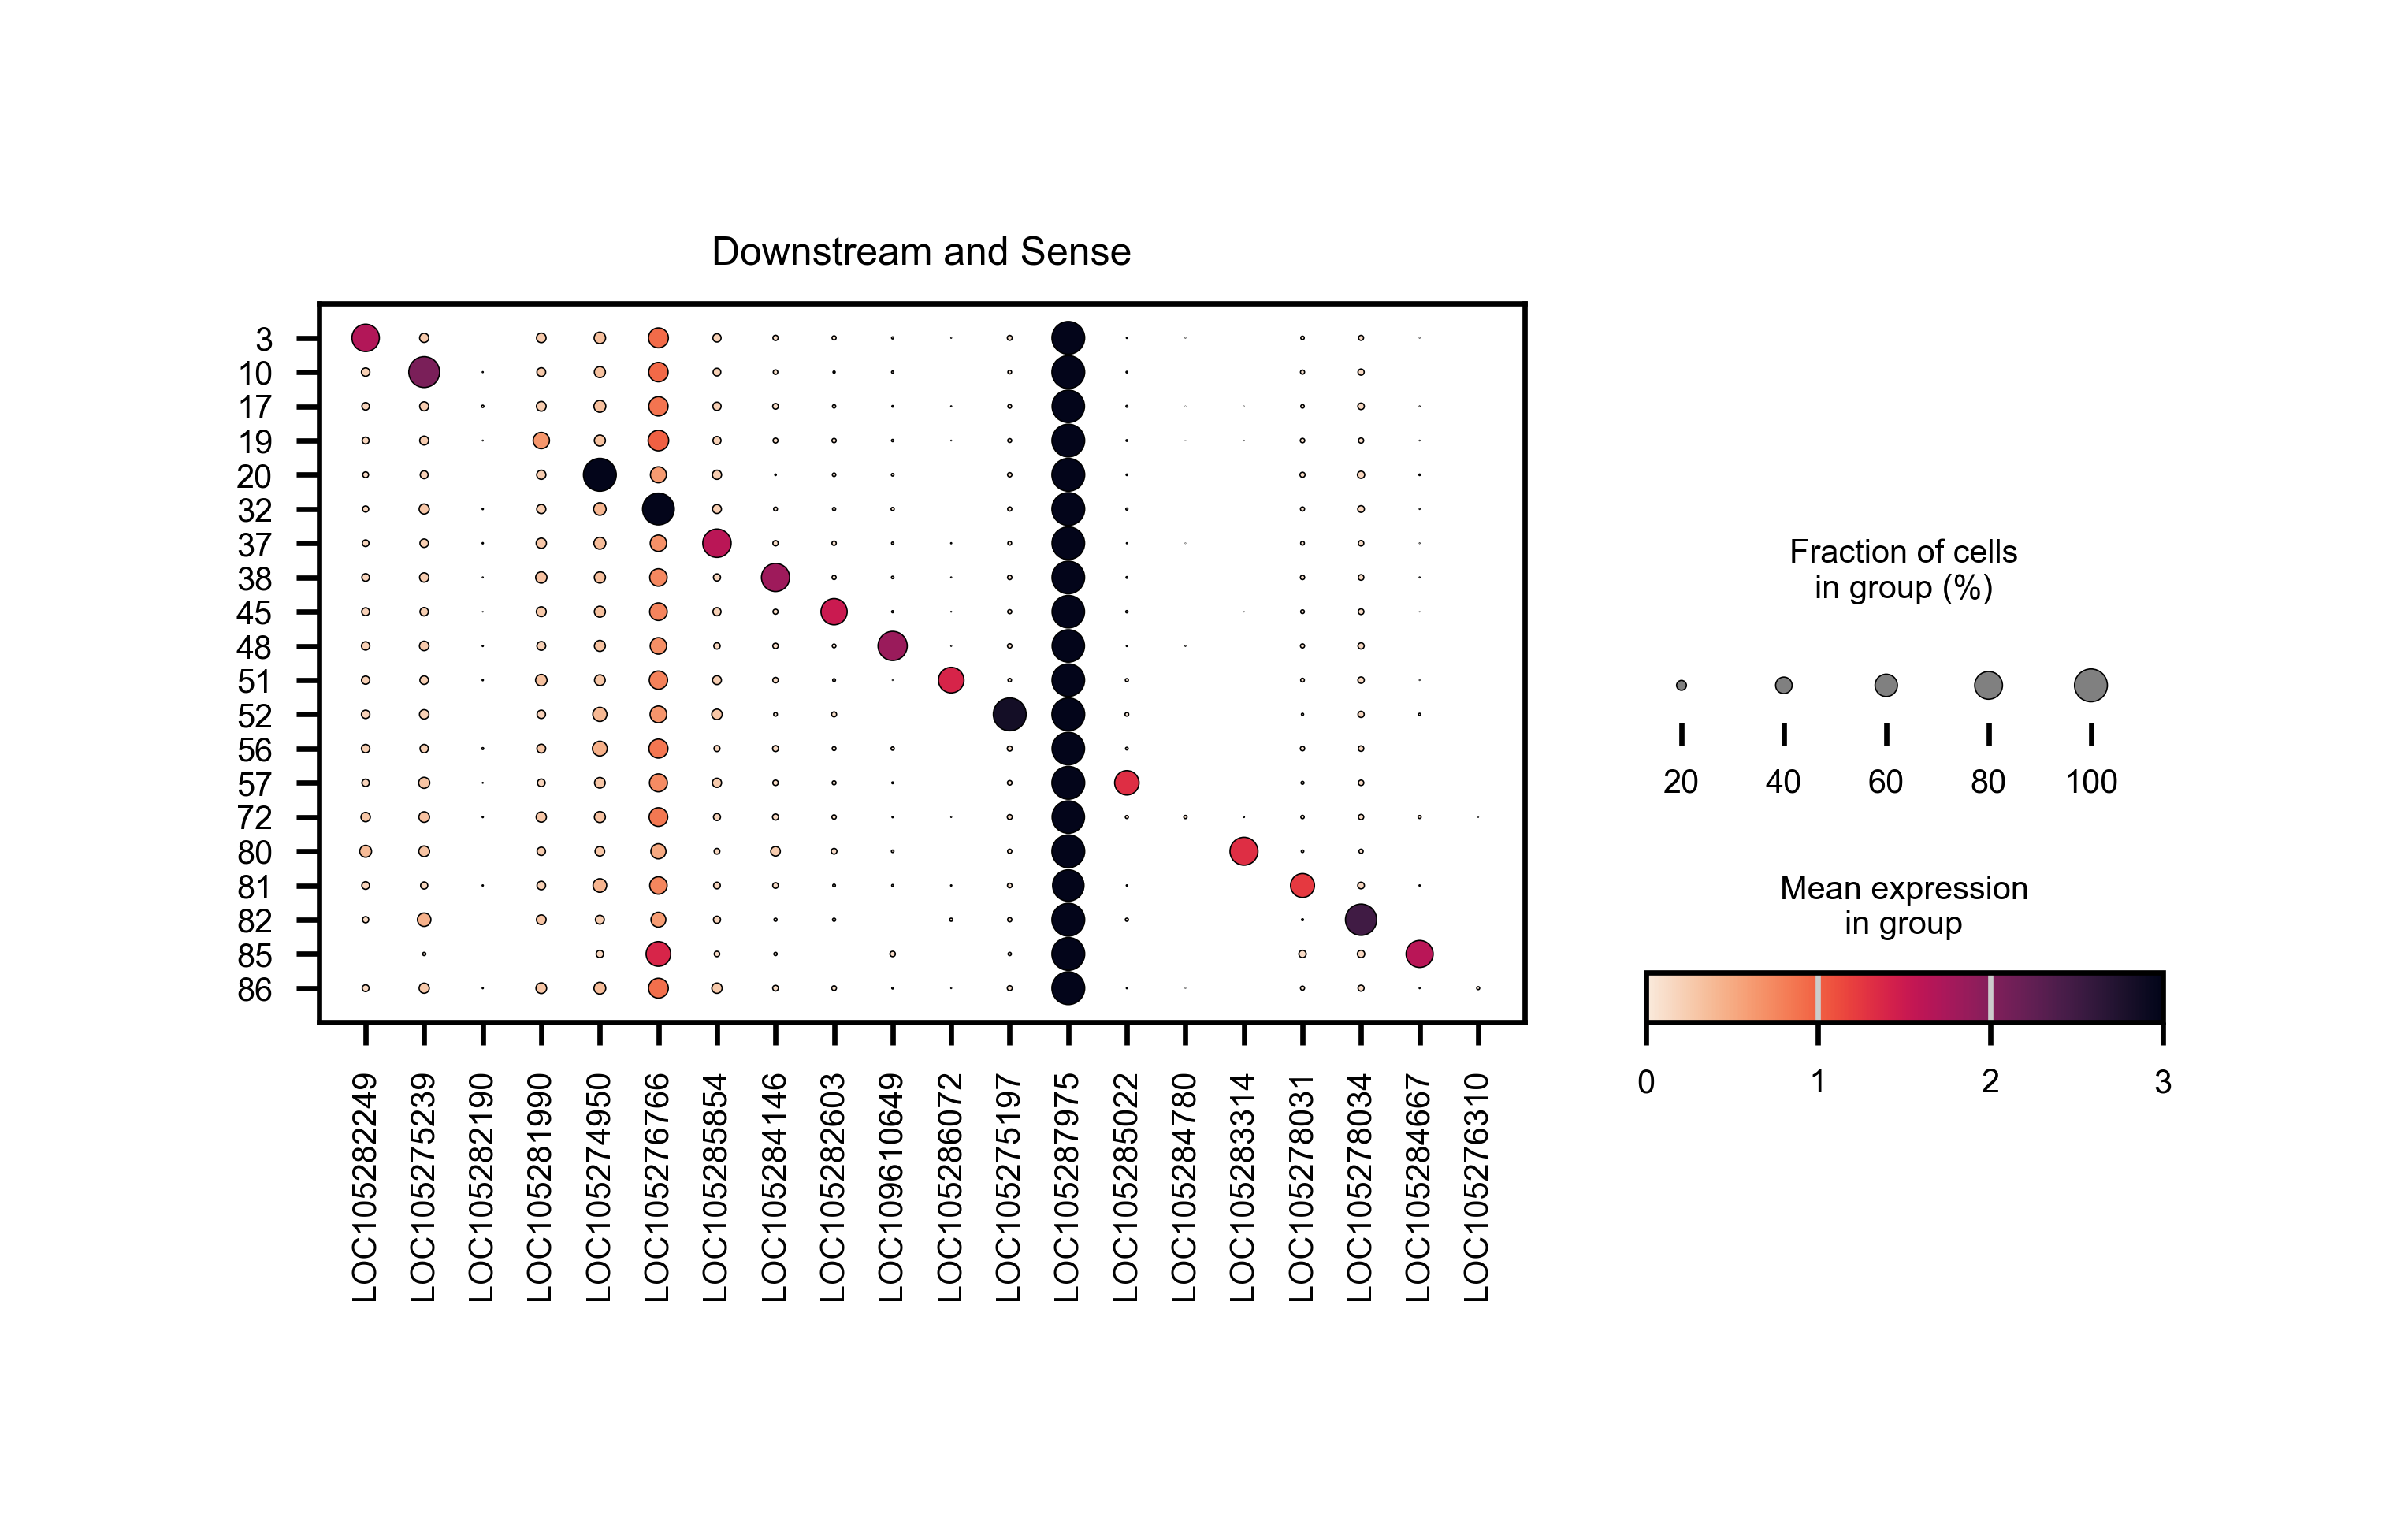

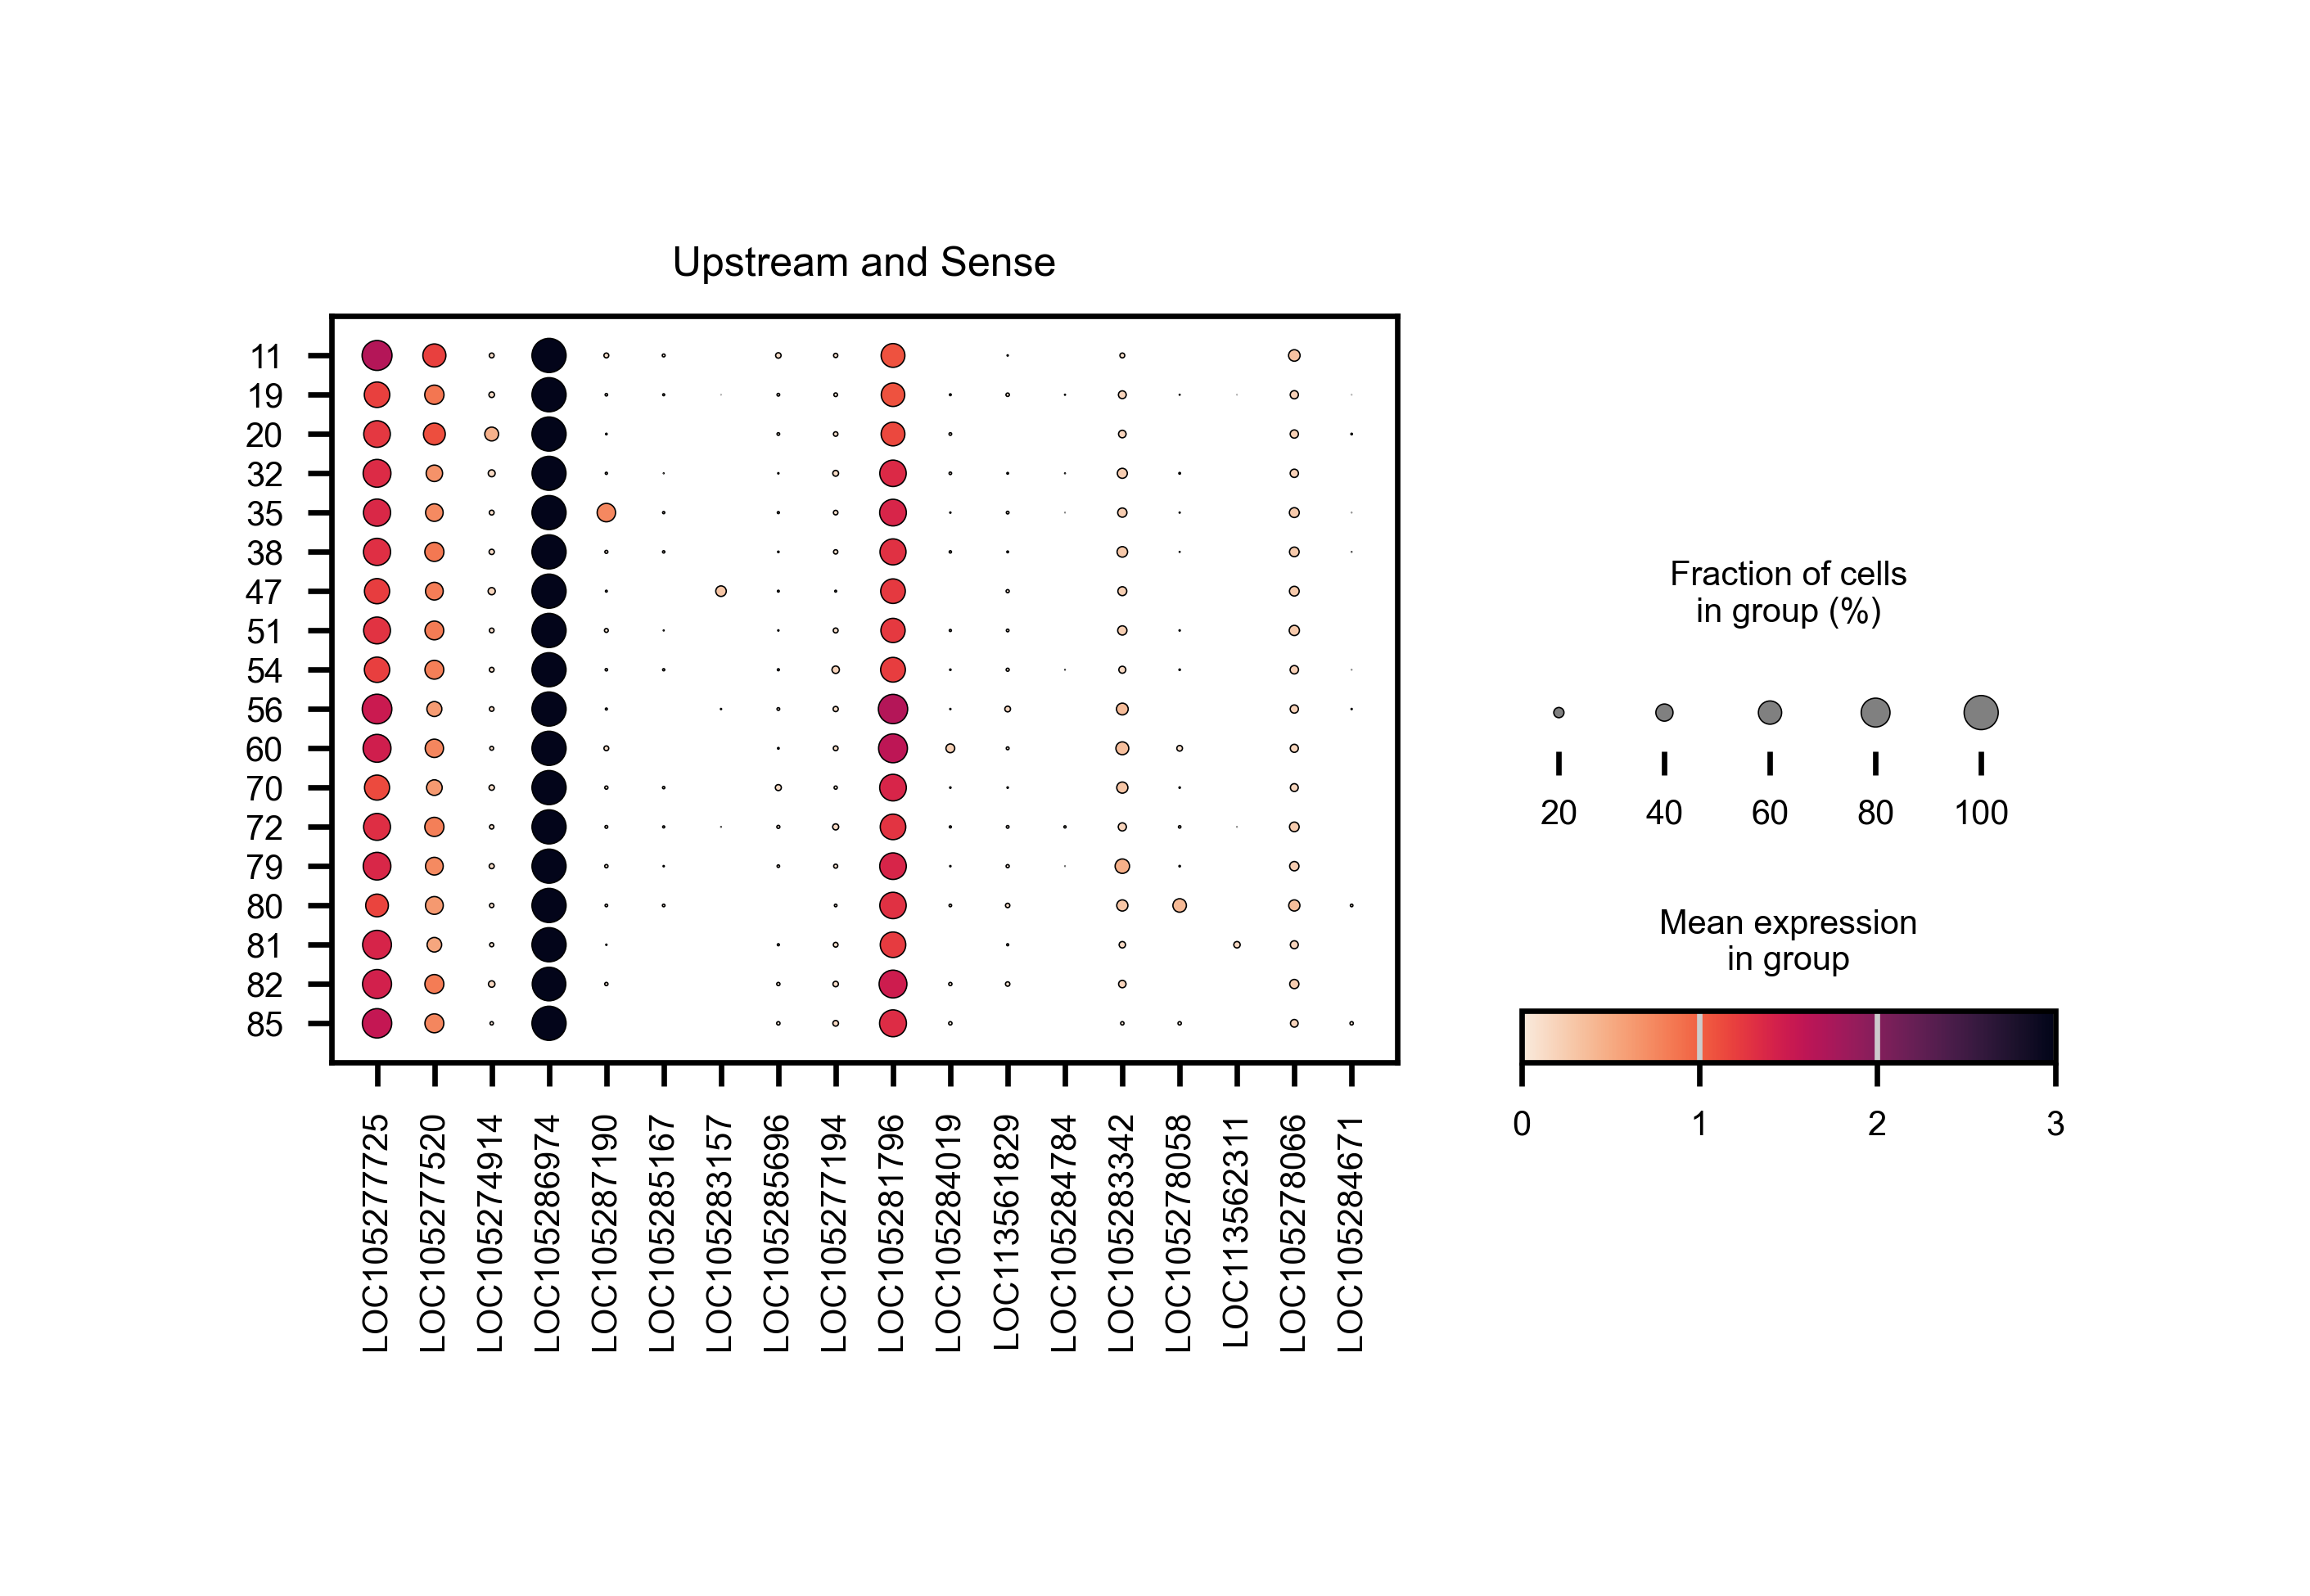

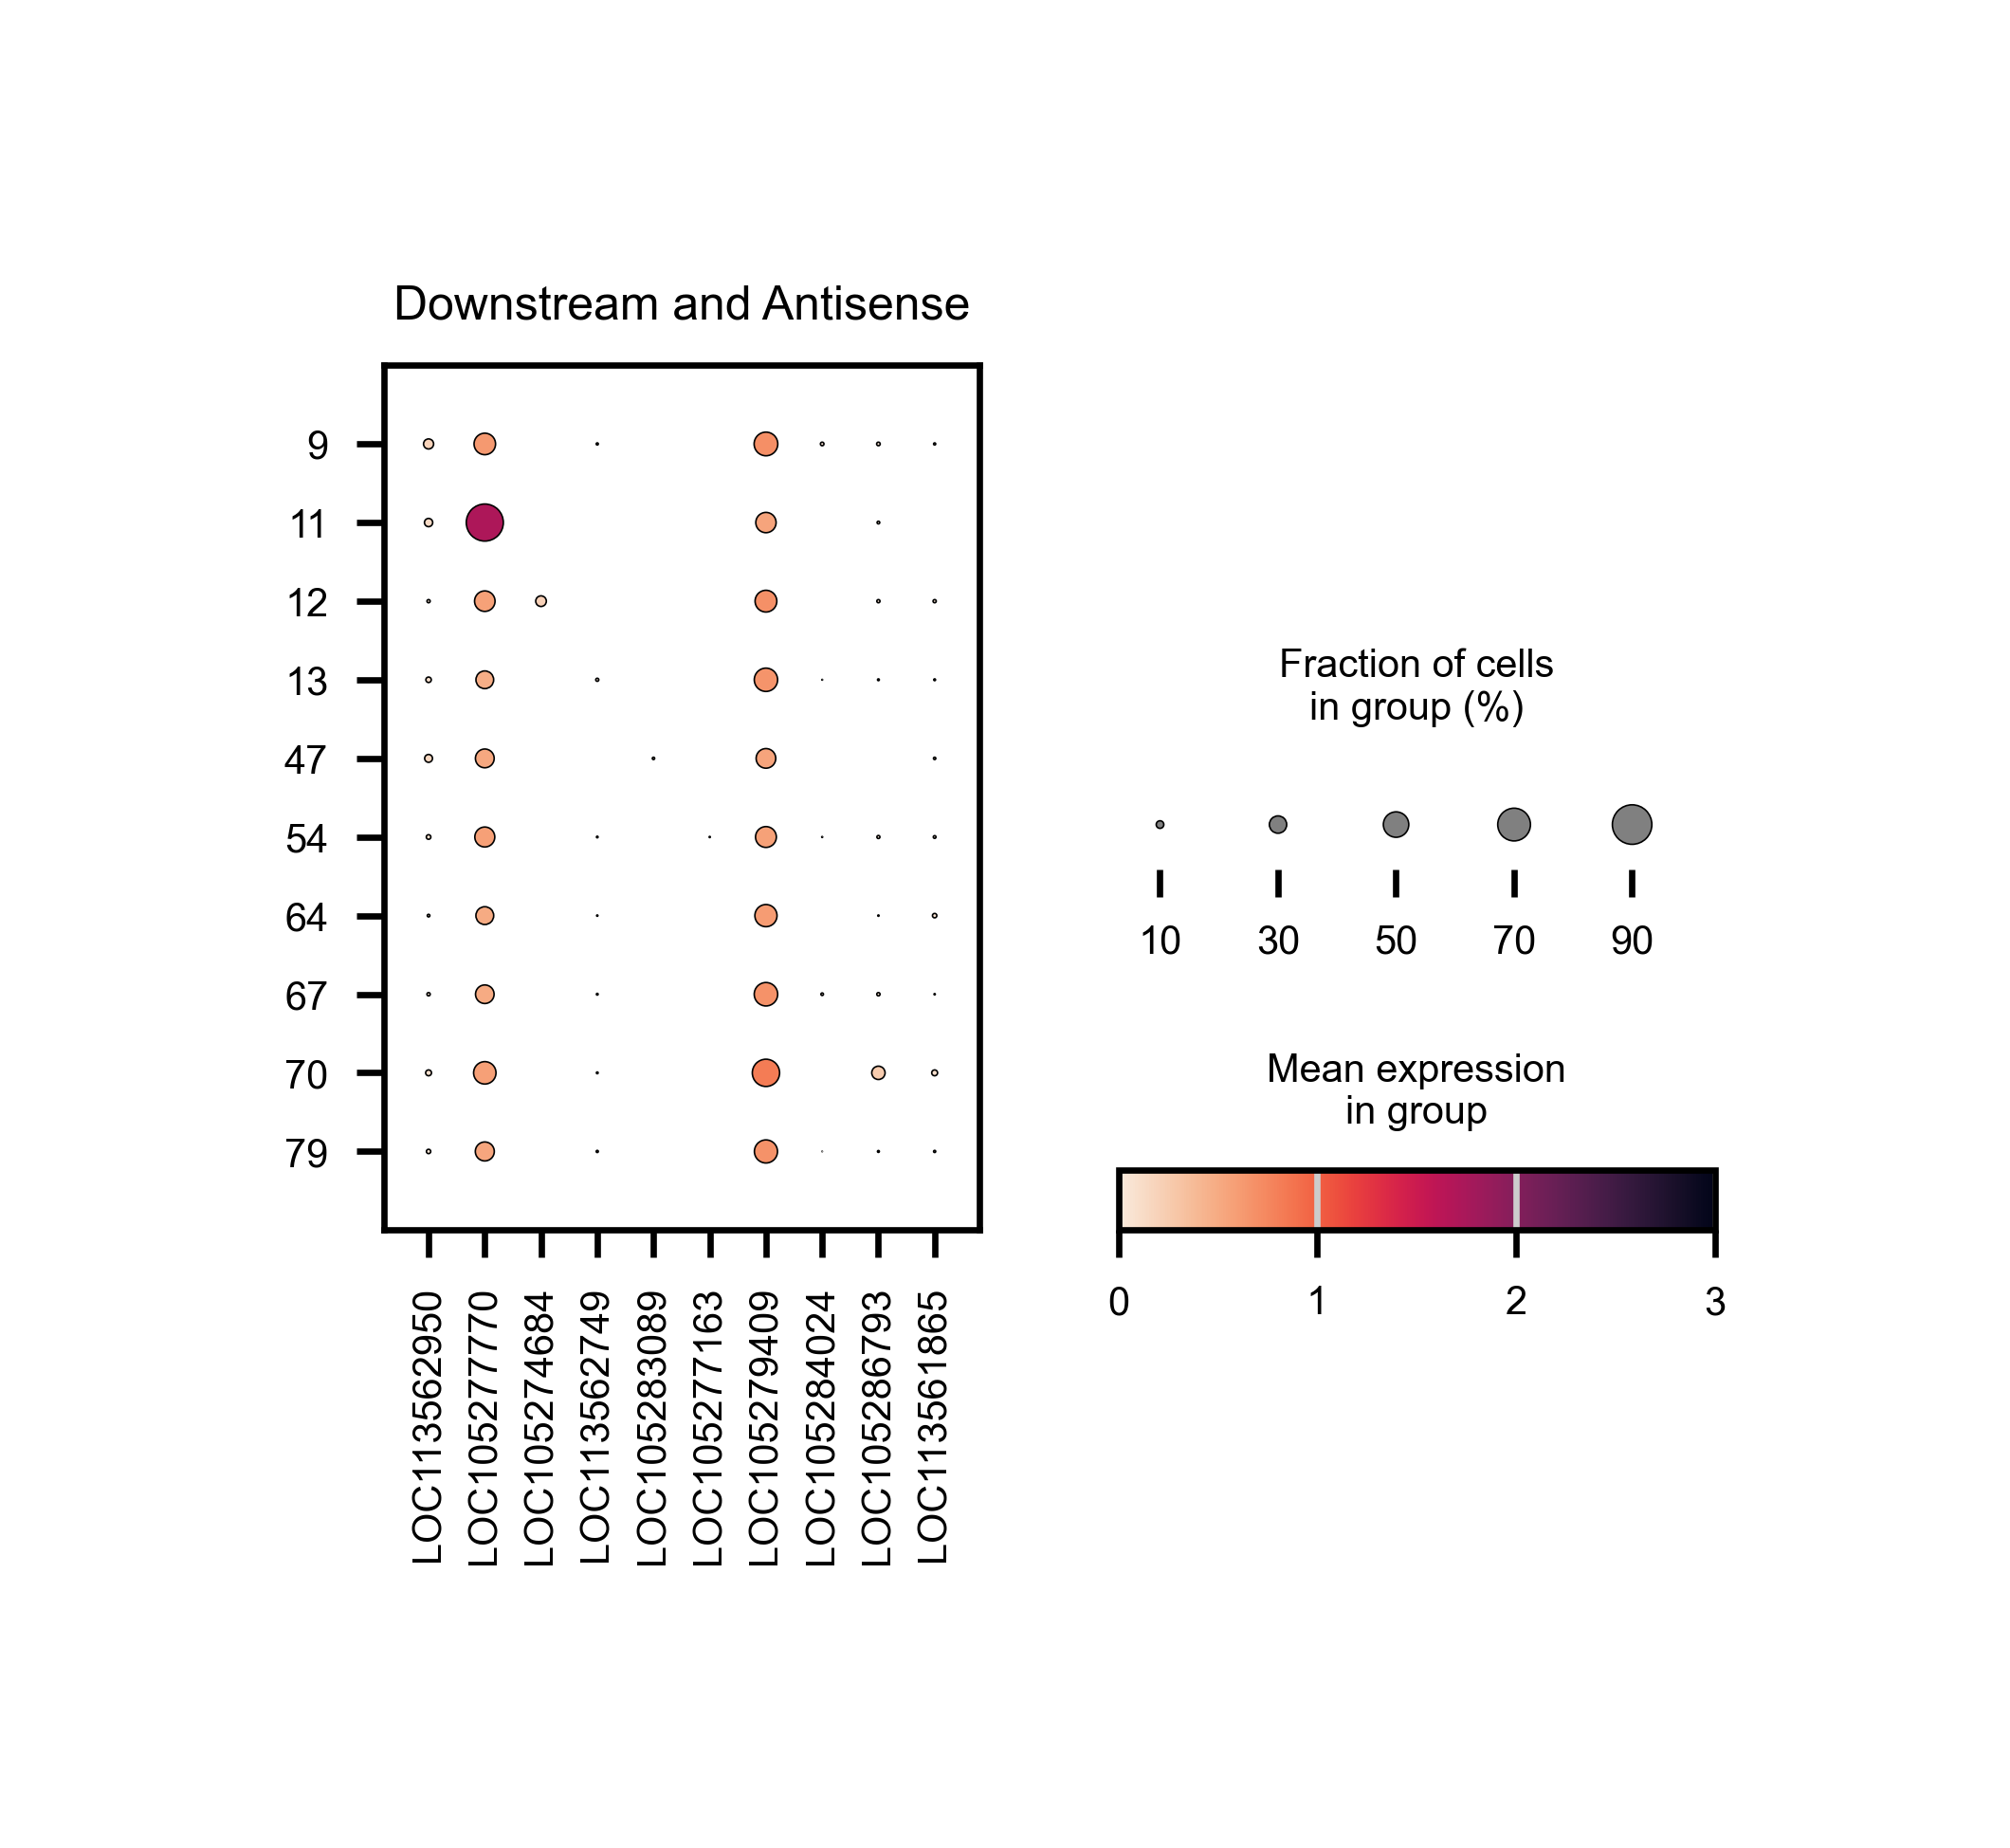

In [134]:
max_distance = 50_000 

# Plotting
# Reset plotting defaults 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 6
plt.rcParams.update({'axes.labelsize' : 6}) 
plt.rcParams.update({'axes.titlesize' : 6}) 
plt.rcParams["patch.force_edgecolor"] = False 

sc.set_figure_params(fontsize=6, dpi=300, dpi_save=300)
  

ta_db_melted_subset = ta_db_melted[(ta_db_melted['distance'] < max_distance) & (ta_db_melted['direction'] == 'upstream') & (ta_db_melted['model_orientation'] == True)].sort_values('tandem_array').reset_index(drop=True)
adata_tas = adata[adata.obs['valence_TA'].isin(ta_db_melted_subset.tandem_array.astype(str))].copy()
sc.pl.DotPlot(adata_tas, var_names=ta_db_melted_subset['gene_name'], groupby='valence_TA', figsize=(4, 2),
            vmin=0, vmax=3, title='Upstream and Antisense').style(cmap='rocket_r', largest_dot=25).savefig(
            f"../figures/flanking-upstream-antisense.pdf", 
            format="pdf", transparent=False)

ta_db_melted_subset = ta_db_melted[(ta_db_melted['distance'] < max_distance) & (ta_db_melted['direction'] == 'downstream') & (ta_db_melted['model_orientation'] == True)].sort_values('tandem_array').reset_index(drop=True)
adata_tas = adata[adata.obs['valence_TA'].isin(ta_db_melted_subset.tandem_array.astype(str))].copy()
sc.pl.DotPlot(adata_tas, var_names=ta_db_melted_subset['gene_name'], groupby='valence_TA', figsize=(5, 2), 
            vmin=0, vmax=3, title='Downstream and Sense').style(cmap='rocket_r', largest_dot=25).savefig(
            f"../figures/flanking-downstream-sense.pdf", 
            format="pdf", transparent=False)


ta_db_melted_subset = ta_db_melted[(ta_db_melted['distance'] < max_distance) & (ta_db_melted['direction'] == 'upstream') & (ta_db_melted['model_orientation'] == False)].sort_values('tandem_array').reset_index(drop=True)
adata_tas = adata[adata.obs['valence_TA'].isin(ta_db_melted_subset.tandem_array.astype(str))].copy()
sc.pl.DotPlot(adata_tas, var_names=ta_db_melted_subset['gene_name'], groupby='valence_TA', figsize=(4.5, 2),
            vmin=0, vmax=3, title='Upstream and Sense').style(cmap='rocket_r', largest_dot=25).savefig(
            f"../figures/flanking-upstream-sense.pdf", 
            format="pdf", transparent=False)


ta_db_melted_subset = ta_db_melted[(ta_db_melted['distance'] < max_distance) & (ta_db_melted['direction'] == 'downstream') & (ta_db_melted['model_orientation'] == False)].sort_values('tandem_array').reset_index(drop=True)
adata_tas = adata[adata.obs['valence_TA'].isin(ta_db_melted_subset.tandem_array.astype(str))].copy()
sc.pl.DotPlot(adata_tas, var_names=ta_db_melted_subset['gene_name'], groupby='valence_TA', figsize=(3, 2), 
            vmin=0, vmax=3, title='Downstream and Antisense').style(cmap='rocket_r', largest_dot=25).savefig(
            f"../figures/flanking-downstream-antisense.pdf", 
            format="pdf", transparent=False) 



## Decay over distance

In [135]:
# Make a dataframe with cell ID in a column and individual columns for each OR 
cell_or_expression = pd.DataFrame(index=adata.obs.index, columns=or_db.gene_name)
for i, row in or_db.iterrows(): 
    cell_or_expression[row.gene_name] = adata[:,row['gene_name']].X.toarray().flatten()

In [140]:
# remove Or5-Orco column 
cell_or_expression = cell_or_expression[cell_or_expression.columns[cell_or_expression.columns != 'Or5-Orco']].copy()

In [141]:
# Get valence ORs 
cell_ids, valence_ORs, valence_OR_expression = cell_or_expression.index, cell_or_expression.idxmax(axis=1).values.tolist(), cell_or_expression.max(axis=1).values

# Get the number of cells with valence_OR_expression > 1 
print(f"Number of cells with valence OR expression >= 1: {sum(valence_OR_expression >= 1)}")
print(f"Number of cells with valence OR expression < 1: {sum(valence_OR_expression < 1)}")

Number of cells with valence OR expression >= 1: 11995
Number of cells with valence OR expression < 1: 6


In [142]:
valence_TAs = np.array([str(or_db.loc[or_db.gene_name == x, 'tandem_array'].values[0]) for x in valence_ORs]).astype(str)
adata.obs['valence_TA'] = valence_TAs 
adata.obs['valence_OR'] = valence_ORs

In [178]:
results_list = []  # Use a list to collect results efficiently

max_TAs = 1 # Number of top TAs to consider
max_genes = 50 # Maximum number of genes to consider  

# Precompute OR-to-Tandem Array and OR-to-TA Index mappings
or_db_no_orco = or_db[or_db.gene_name != 'Or5-Orco'].reset_index(drop=True)
or_db_no_orco = or_db_no_orco.sort_values(by=['chr', 'start'])
or_to_ta = or_db_no_orco.set_index('gene_name')['tandem_array'].to_dict()
or_to_ta_index = or_db_no_orco.set_index('gene_name')['ta_index'].to_dict()
or_to_strand = or_db_no_orco.set_index('gene_name')['strand'].to_dict()

# Iterate over cells
for cell in tqdm(cell_or_expression.index, desc='Processing Cells', total=len(cell_or_expression.index)):
    # Get the ORs sorted by expression
    cell_expression = cell_or_expression.loc[cell]
    
    # get nonzero expression 
    cell_expression_nonzero = cell_expression[cell_expression > 0]

    # nonzero ORs sorted by expression, descending, top to bottom 
    ORs_sorted = cell_expression_nonzero.sort_values(ascending=False).index.values

    # Map ORs to Tandem Arrays and filter for valid entries
    TAs_sorted = pd.Series([or_to_ta[or_] for or_ in ORs_sorted])

    # Get unique TAs while preserving order 
    # pd.unique preserves order
    TAs_sorted_unique = pd.unique(TAs_sorted)

    # Get the top max_TAs TAs if there are more than max_TAs
    TAs_sorted_unique_top = TAs_sorted_unique[:max_TAs]

    # Get the highest expressing OR for each unique TA 
    valence_ORs = [ORs_sorted[np.where(TAs_sorted == TA)[0][0]] for TA in TAs_sorted_unique_top]

    # Process each top OR
    for i, or_ in enumerate(valence_ORs):
        or_index = or_to_ta_index[or_]
        or_TA = or_to_ta[or_]
        or_strand_multiplier = -1 if or_to_strand[or_] == "-" else 1

        # Filter Tandem Array ORs
        TA_ORs = or_db_no_orco[or_db_no_orco['tandem_array'] == or_TA].copy()

        # Get the indices of the ORs in the TA
        TA_ORs['ta_index_rel'] = (TA_ORs['ta_index'] - or_index) * or_strand_multiplier  # Adjust TA indices relative to the top OR

        # Distance to the top OR
        valence_OR = or_db_no_orco[or_db_no_orco['gene_name'] == or_].copy()
        TA_ORs['tss2tss'] = TA_ORs['start'] - valence_OR['start'].values[0] if or_strand_multiplier == 1 else valence_OR['start'].values[0] - TA_ORs['start']
        
        # Add expression values and cell information
        TA_ORs['expression'] = cell_expression[TA_ORs['gene_name']].values
        TA_ORs['cell_index'] = cell
        TA_ORs['ta_rank'] = i + 1

        # sort by relative order 
        TA_ORs = TA_ORs.sort_values(by='ta_index_rel', ascending=True).reset_index(drop=True)

        # Remove rows past the max_genes limit
        TA_ORs = TA_ORs.loc[TA_ORs['ta_index_rel'].abs() <= max_genes].reset_index(drop=True)

        # Append relevant columns to the results list
        results_list.append(
            TA_ORs[['cell_index', 'ta_rank', 'tandem_array', 'gene_name', 'tss2tss', 'ta_index_rel', 'expression', 'strand', 'ta_size', 'ta_index']]
        )

# Combine all results into a DataFrame
results = pd.concat(results_list, ignore_index=True)


Processing Cells: 100%|██████████| 12001/12001 [00:14<00:00, 826.52it/s]


In [179]:
results

cell_index  ta_rank  tandem_array   gene_name  tss2tss  \
0       S1_AAAGAACCATATTCGG-1_3        1            17   Or5-9E255        0   
1       S1_AAAGAACCATATTCGG-1_3        1            17   Or5-9E256     5969   
2       S1_AAAGAACCATATTCGG-1_3        1            17   Or5-9E257     9963   
3       S1_AAAGAACCATATTCGG-1_3        1            17   Or5-9E258    14449   
4       S1_AAAGAACCATATTCGG-1_3        1            17   Or5-9E259    19811   
...                         ...      ...           ...         ...      ...   
361607  S2_TTTGGAGGTTATAGAG-1_4        1            19     Or5-U63   107548   
361608  S2_TTTGGAGGTTATAGAG-1_4        1            19  Or5-Ufrag1   113089   
361609  S2_TTTGGAGGTTATAGAG-1_4        1            19     Or5-U64   118070   
361610  S2_TTTGGAGGTTATAGAG-1_4        1            19     Or5-U65   122539   
361611  S2_TTTGGTTCATCTAGAC-1_4        1            77      Or5-W1        0   

        ta_index_rel  expression strand  ta_size  ta_index  
0                  0    1.889631      +       82         1  
1                  1    0.000000      +       82         2  
2                  2    0.000000      +       82         3  
3                  3    0.000000      +       82         4  
4                  4    0.000000      +       82         5  
...              ...         ...    ...      ...       ...  
361607            16    0.000000      +       55        52  
361608            17    1.176393      +       55        53  
361609            18    0.000000      +       55        54  
361610            19    1.702074      +       55        55  
361611             0    3.312231      -        1         1  

[361612 rows x 10 columns]

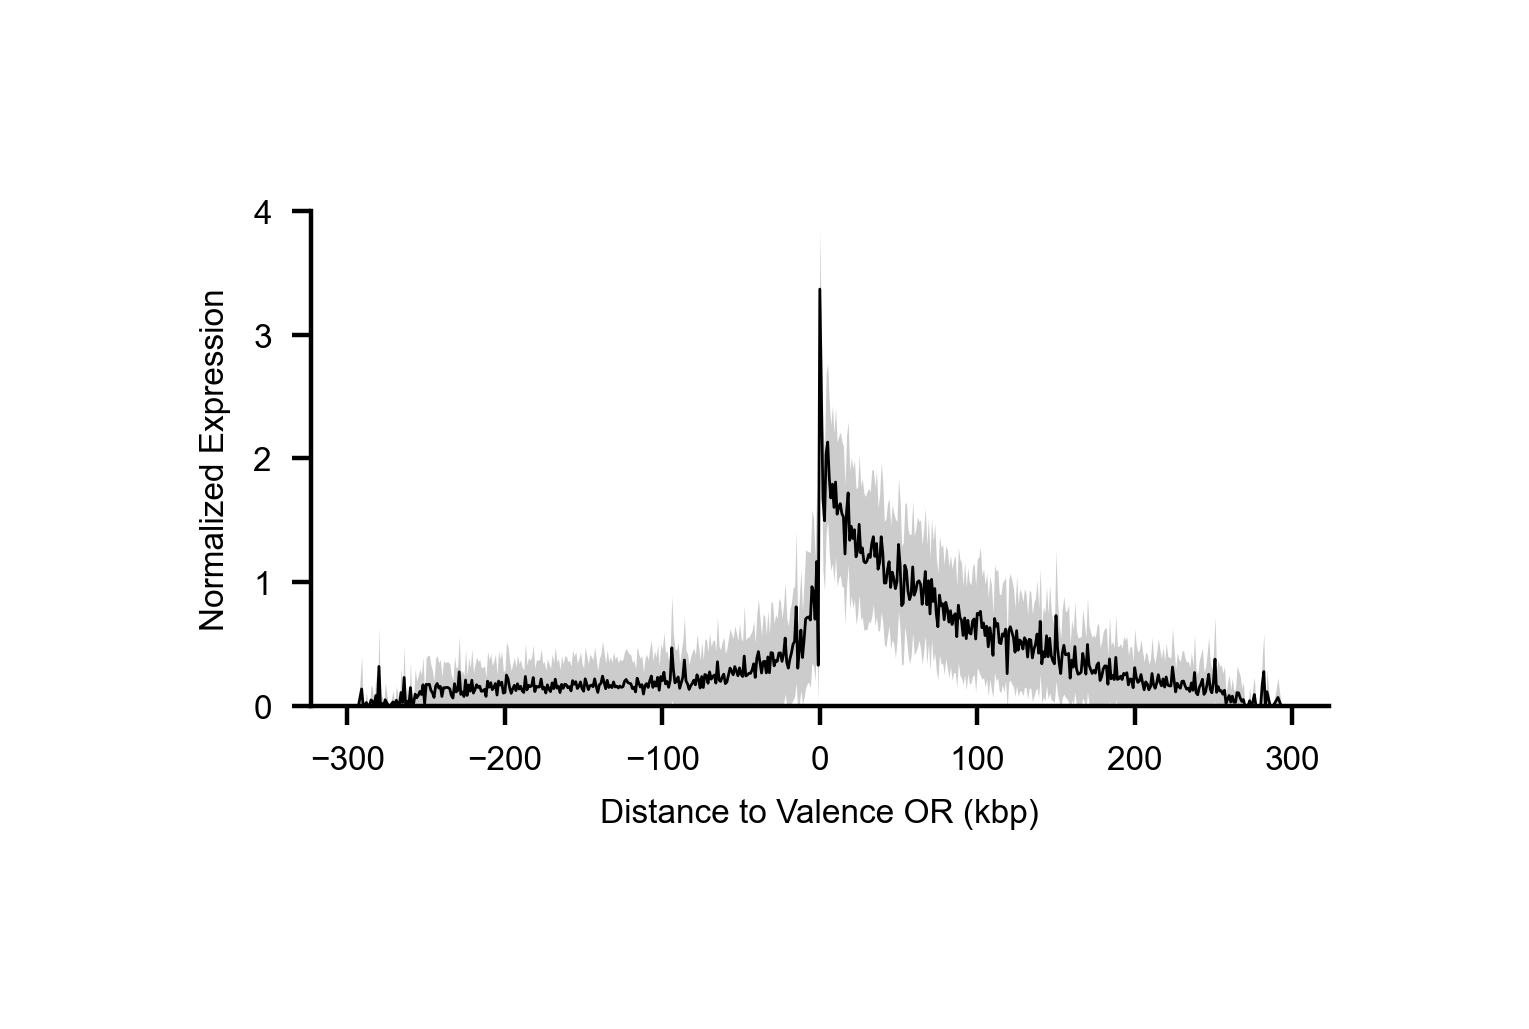

In [200]:
# bin tss2tss using bin_width 

bin_width = 1000 # bp 

results['tss2tss_bin'] = (results['tss2tss'] / bin_width).round().astype(int) 

# Get mean and std for each bin
results_grouped = results.groupby(['tss2tss_bin', 'ta_rank']).agg({'expression': ['mean', 'median', 'std']}).reset_index()

# Plot mean as line with std as shaded area

f, ax = plt.subplots(1, 1, figsize=(3, 1.75), dpi=200)
plt.plot(results_grouped['tss2tss_bin'], results_grouped['expression']['mean'], color='black', linewidth=0.5)
plt.fill_between(results_grouped['tss2tss_bin'], 
                 results_grouped['expression']['mean'] - results_grouped['expression']['std']/2, 
                 results_grouped['expression']['mean'] + results_grouped['expression']['std']/2, 
                 color='black', alpha=0.2, lw=0)


ax.set_xlabel('Distance to Valence OR (kbp)', fontsize=6)
ax.set_ylabel('Normalized Expression', fontsize=6)

# Turn off spines and grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

ax.set_ylim(0, 4)

plt.tight_layout()
plt.savefig(f"../figures/downstream_ORs_gex_vs_distance.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

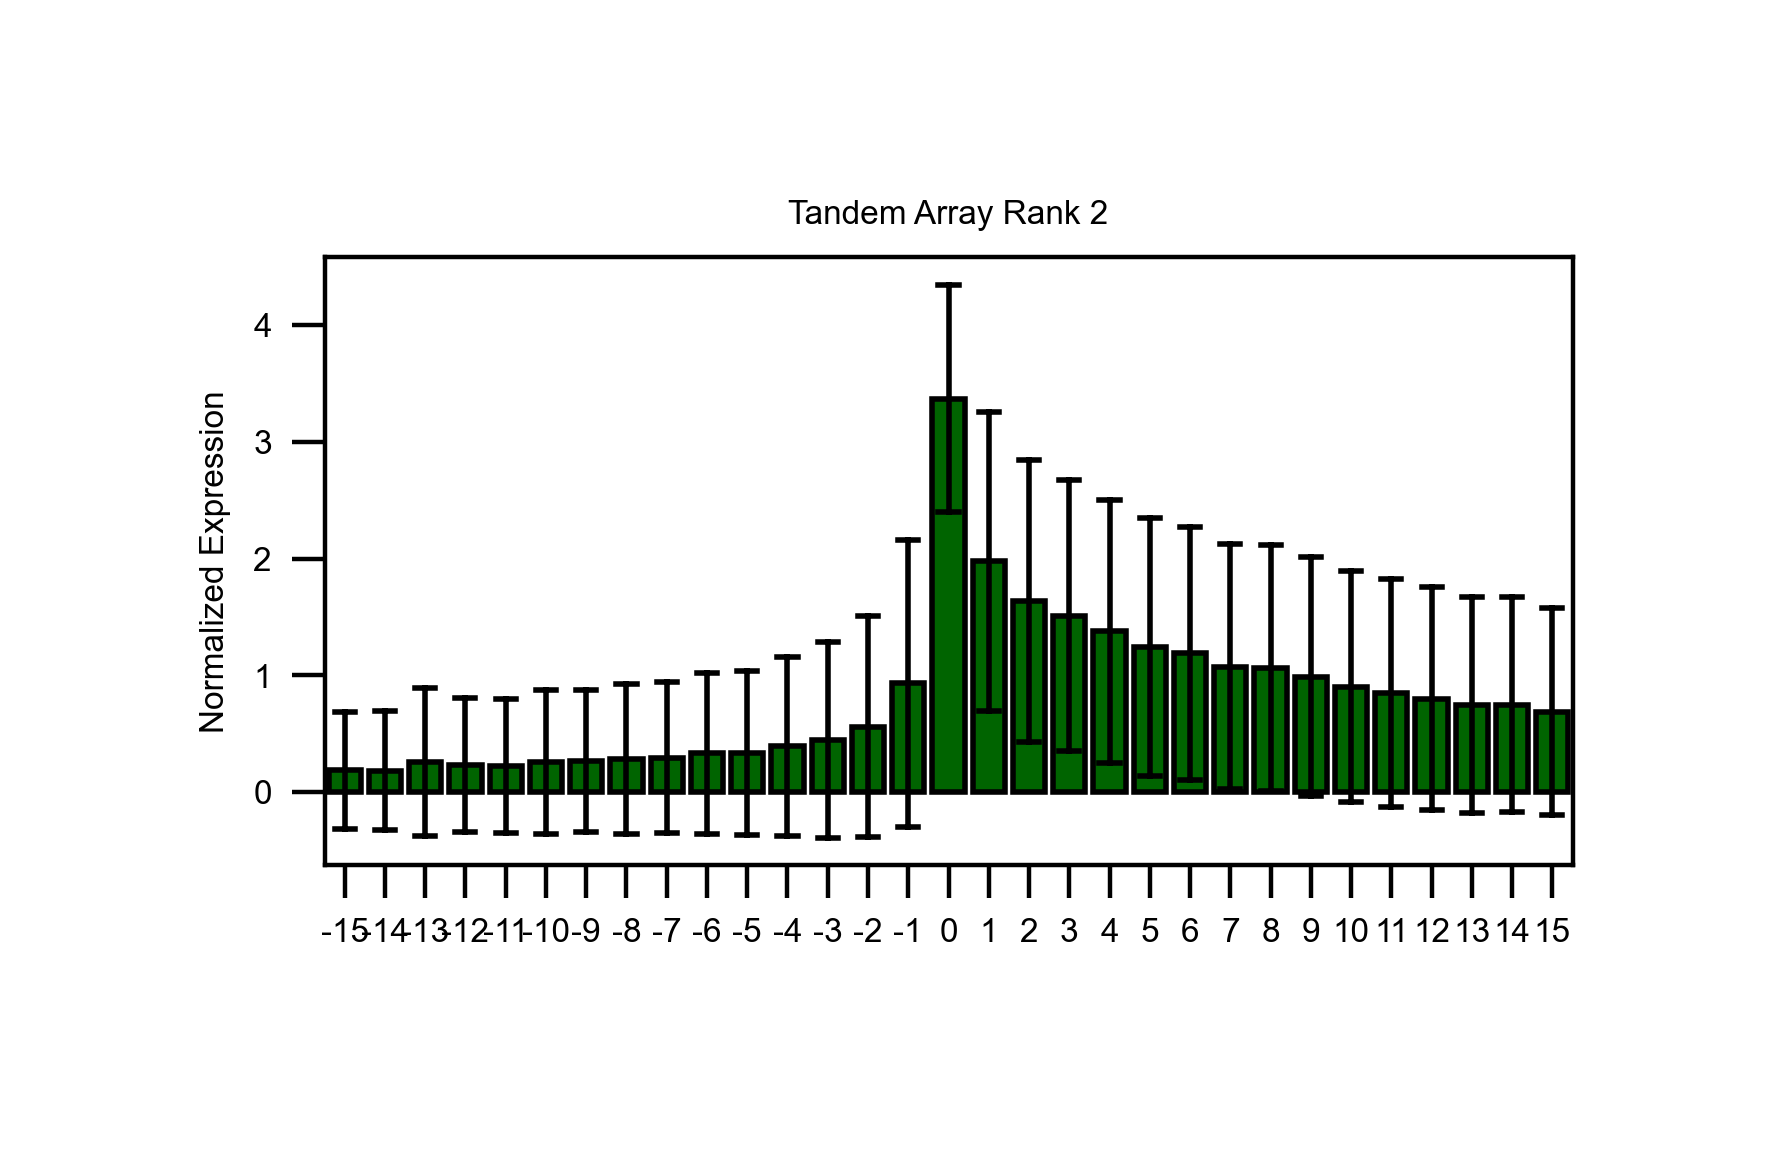

In [ ]:
num_TAs = 1 
num_ORs = 15 
f, ax = plt.subplots(1, num_TAs, figsize=(4, 2), dpi=200) 
ta_results = results[results['ta_rank'] == num_TAs].copy() 
ta_results = ta_results[(ta_results['ta_index_rel'] >= -num_ORs) & (ta_results['ta_index_rel'] <= num_ORs)]
sns.barplot(data=ta_results, x='ta_index_rel', y='expression', ax=ax, errcolor='black', facecolor='darkgreen', edgecolor='black', ci='sd', errwidth=1, capsize=0.5)
ax.set_title(f'Tandem Array Rank {num_TAs+1}')
ax.set_xlabel('')
ax.set_ylabel('Normalized Expression', fontsize=6)
ax.tick_params(axis='both', size=6)
ax.grid(False)

## Identify lncRNAs nested in Tandem Arrays
- Remove any lncRNAs not in the P14 snRNAseq data 

In [49]:
all_genes = [tr.get_gene(gene) for gene in tr.genes.keys() if len(tr.get_gene(gene).transcripts) > 0]
all_lncRNAs = [gene for gene in all_genes if gene.transcript_biotype == 'lnc_RNA']
len(all_lncRNAs), len(all_genes)

(1424, 13810)

Identify which lncRNAs are nested within TAs 

In [50]:
# Find nested lncRNAs within TAs 

# Filter clusters with more than 100 cells and exclude "Other" cluster
or_db_no_orco = or_db.loc[~or_db.gene_name.str.contains('Orco')].reset_index(drop=True)
TAs = or_db_no_orco['tandem_array'].unique()
nested_lncRNAs = [] 

for ta_ in TAs: 
    # Get bounds of tandem array 
    TA_genes = or_db_no_orco.loc[or_db_no_orco['tandem_array'] == int(ta_)]
    # sort by start
    TA_genes = TA_genes.sort_values(by='start').reset_index(drop=True)
    TA_genes = TA_genes['gene_name']
    TA_chromosome = tr.get_gene(TA_genes.iloc[0]).chromosome
    first_gene_bounds = tr.get_gene(TA_genes.iloc[0]).get_transcript_longest_bounds().get_bounds()
    last_gene_bounds = tr.get_gene(TA_genes.iloc[-1]).get_transcript_longest_bounds().get_bounds()
    TA_bounds = [first_gene_bounds[0], last_gene_bounds[1]]
    
    for lncRNA in all_lncRNAs: 
        lnc_start, lnc_end = lncRNA.get_transcript_longest_bounds().get_bounds()
        lnc_strand = lncRNA.strand 
        if lnc_start >= TA_bounds[0] and lnc_end <= TA_bounds[1] and lncRNA.chromosome == TA_chromosome: 
            lnc_size = lnc_end - lnc_start
            nested_lncRNAs.append({'gene_name': lncRNA.name, 'TA': ta_, 'TA_location': f"{TA_chromosome}:{TA_bounds[0]}-{TA_bounds[1]}", 'lnc_strand': lnc_strand, 'lnc_size': lnc_size, 'lnc_start': lnc_start, 'lnc_end': lnc_end})

nested_lncRNAs = pd.DataFrame(nested_lncRNAs)
nested_lncRNAs

gene_name  TA              TA_location lnc_strand  lnc_size  lnc_start  \
0   LOC113562279  80   Chr1:18401037-18422446          +      1602   18415710   
1   LOC105281803  56     Chr2:2457195-2491432          +      3106    2477097   
2   LOC109611010  62   Chr2:16359674-16554585          +       713   16521651   
3   LOC109611013  62   Chr2:16359674-16554585          +       554   16482234   
4   LOC109611014  62   Chr2:16359674-16554585          +      1319   16511990   
..           ...  ..                      ...        ...       ...        ...   
69  LOC105275250  10  Chr11:12234278-12251405          -       371   12237414   
70  LOC105281874   3    Chr12:8696505-8810716          -       290    8736692   
71  LOC105284280   3    Chr12:8696505-8810716          -      1865    8697329   
72  LOC109611157   3    Chr12:8696505-8810716          -       535    8807488   
73  LOC109611159   3    Chr12:8696505-8810716          -      9539    8769306   

     lnc_end  
0   18417312  
1    2480203  
2   16522364  
3   16482788  
4   16513309  
..       ...  
69  12237785  
70   8736982  
71   8699194  
72   8808023  
73   8778845  

[74 rows x 7 columns]

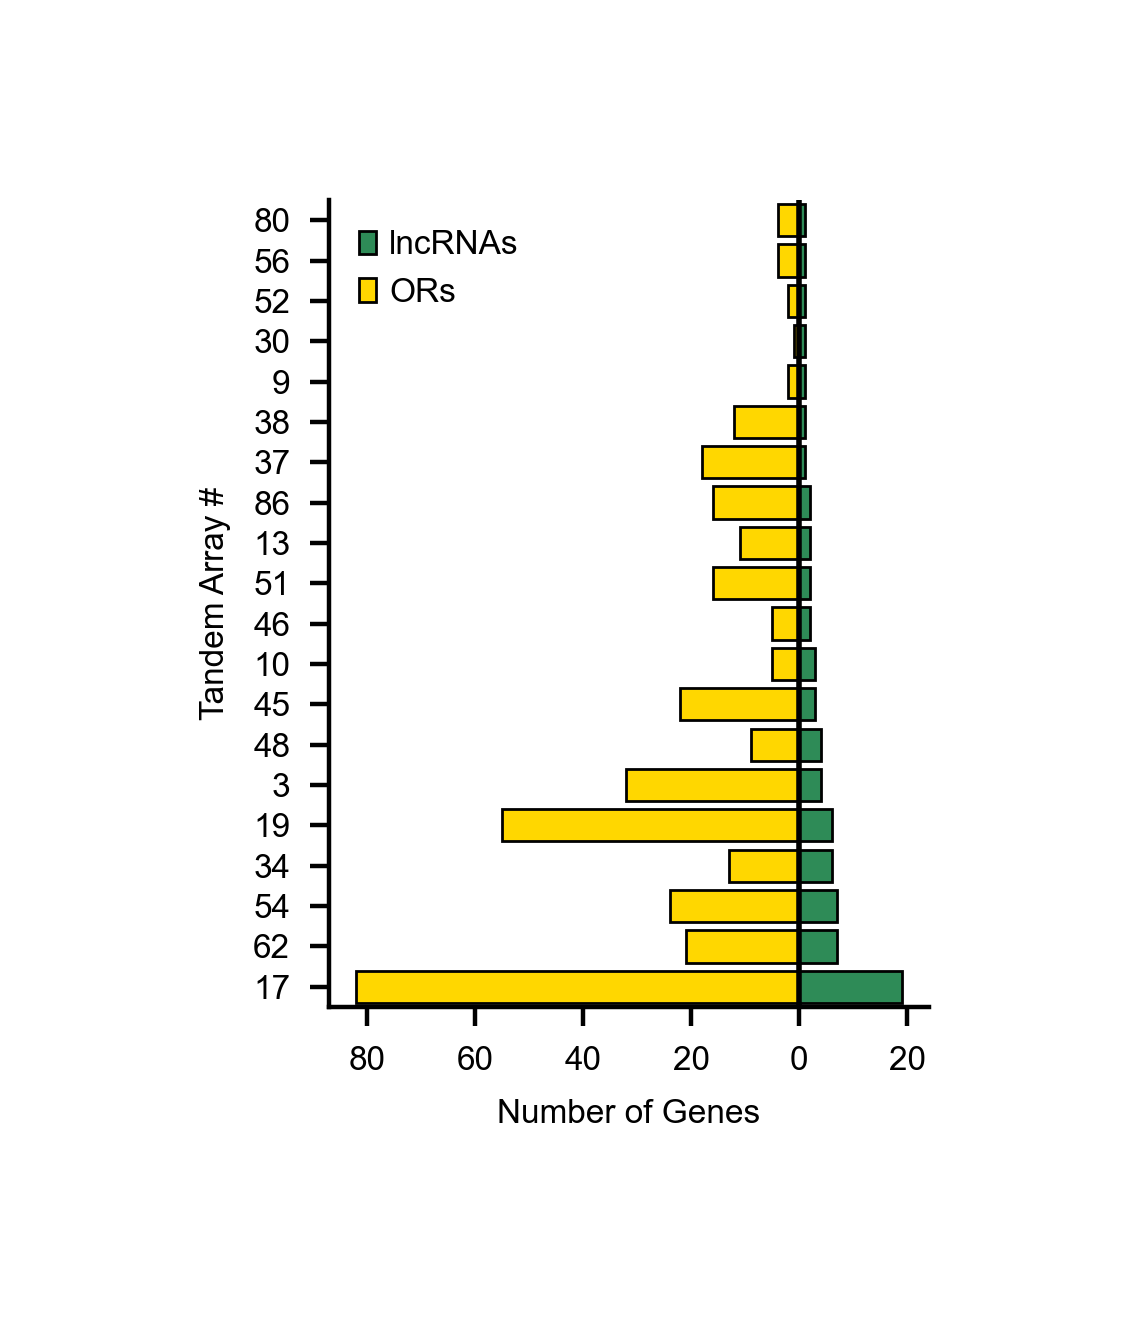

In [51]:
# Plot the number of lncRNAs split by TA 
ta, counts = np.unique(nested_lncRNAs['TA'], return_counts=True)
counts = pd.DataFrame({'TA': ta, 'num_lnc': counts})
counts = counts.sort_values(by='num_lnc', ascending=False).reset_index(drop=True)
counts['num_ORs'] = counts['TA'].apply(lambda x: or_db_no_orco.loc[or_db_no_orco.tandem_array == x].shape[0])

white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fig, ax = plt.subplots(1, 1, figsize=(2, 2.5), dpi=200) 

y_labels = counts['TA']
y_pos = np.arange(len(y_labels))

ax.barh(y_pos, counts['num_lnc'], color='seagreen', label='lncRNAs', edgecolor='black', linewidth=0.5)
ax.barh(y_pos, -counts['num_ORs'], color='gold', label='ORs', edgecolor='black', linewidth=0.5)

ax.set_yticks(y_pos, labels=y_labels, fontsize=6)
ax.set_ylim(-0.5, len(y_labels)-0.5)

#ax.set_title('lncRNAs and ORs in Tandem Arrays', fontsize=6)

ax.set_xlabel('Number of Genes', fontsize=6)
ax.set_ylabel('Tandem Array #', fontsize=6)

# X labels 
ax.set_xticks([-80, -60, -40, -20, 0, 20], labels=[80, 60, 40, 20, 0, 20], fontsize=6)
ax.axvline(0, color='black', linewidth=1) 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(fontsize=6, loc='upper left', frameon=False) 

# Remove padding 
plt.tight_layout() 
plt.savefig(f"../figures/biroi-lnc-ors-tas.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

In [52]:
# Remove lncRNAs that are not in the data 
nested_lncRNAs['in_p14_data'] = nested_lncRNAs['gene_name'].isin(adata.var.index)
nested_lncRNAs = nested_lncRNAs[nested_lncRNAs['in_p14_data']]
nested_lncRNAs.reset_index(drop=True, inplace=True)
nested_lncRNAs.shape

(71, 8)

## ORs flanking lncRNA figure

Identify the two ORs that flank the lncRNA 

In [53]:
# For each nested lncRNA, find all ORs that are upstream or downstream of the lncRNA TSS within the TA 

or_db_no_orco = or_db.loc[~or_db.gene_name.str.contains('Orco')].reset_index(drop=True)

lnc_associated_ORs = [] 

for i, row in nested_lncRNAs.iterrows():
    # Get ORs in the TA
    TA_genes = or_db_no_orco.loc[or_db_no_orco['tandem_array'] == int(row.TA), 'gene_name']
    ORs_of_interest = [] 
    # For each gene, check if it is upstream or downstream of the lncRNA
    for gene in TA_genes: 
        gene_obj = tr.get_gene(gene) 
        gene_start, gene_end = gene_obj.get_transcript_longest_bounds().get_bounds()
        gene_strand = gene_obj.strand
        # Verify that the OR and lncRNA are on opposite strands 
        if gene_strand == row.lnc_strand: 
            continue 
        if gene_strand == "-" and row.lnc_strand == "+": 
            if gene_end < row.lnc_start: 
                ORs_of_interest.append([gene, "upstream", row.lnc_start - gene_start, gene_start, gene_end, gene_strand])
            elif gene_start > row.lnc_start: 
                ORs_of_interest.append([gene, "downstream", gene_start - row.lnc_start, gene_start, gene_end, gene_strand])
        elif gene_strand == "+" and row.lnc_strand == "-": 
            if gene_start > row.lnc_start: 
                ORs_of_interest.append([gene, "upstream", gene_start - row.lnc_start, gene_start, gene_end, gene_strand])
            elif gene_end < row.lnc_start: 
                ORs_of_interest.append([gene, "downstream", row.lnc_start - gene_start, gene_start, gene_end, gene_strand])
    
    # save to lnc_associated_ORs
    for or_name, location, distance, or_start, or_end, or_strand in ORs_of_interest:
        lnc_associated_ORs.append({'lncRNA': row.gene_name, 'lncRNA_size': row.lnc_size, 'TA': row.TA, 'or_name': or_name, 'location': location, 'tss2tss': distance, 'lnc_start': row.lnc_start, 'lnc_end': row.lnc_end, 'lnc_strand': row.lnc_strand, 'or_start': or_start, 'or_end': or_end, 'or_strand': or_strand})
    

lnc_associated_ORs = pd.DataFrame(lnc_associated_ORs)
lnc_associated_ORs

lncRNA  lncRNA_size  TA   or_name    location  tss2tss  lnc_start  \
0     LOC113562279         1602  80    Or5-H1    upstream    14673   18415710   
1     LOC113562279         1602  80    Or5-X1    upstream     9232   18415710   
2     LOC113562279         1602  80    Or5-H2    upstream     5047   18415710   
3     LOC113562279         1602  80    Or5-H3  downstream     3474   18415710   
4     LOC105281803         3106  56  Or5-9E20    upstream    19902    2477097   
...            ...          ...  ..       ...         ...      ...        ...   
2344  LOC109611159         9539   3   Or5-L31    upstream    25787    8769306   
2345  LOC109611159         9539   3   Or5-L32    upstream    29040    8769306   
2346  LOC109611159         9539   3   Or5-L33    upstream    32665    8769306   
2347  LOC109611159         9539   3   Or5-L34    upstream    35734    8769306   
2348  LOC109611159         9539   3   Or5-L35    upstream    38781    8769306   

       lnc_end lnc_strand  or_start    or_end or_strand  
0     18417312          +  18401037  18404290         -  
1     18417312          +  18406478  18409631         -  
2     18417312          +  18410663  18414867         -  
3     18417312          +  18419184  18422446         -  
4      2480203          +   2457195   2462929         -  
...        ...        ...       ...       ...       ...  
2344   8778845          -   8795093   8797168         +  
2345   8778845          -   8798346   8800435         +  
2346   8778845          -   8801971   8804397         +  
2347   8778845          -   8805040   8807434         +  
2348   8778845          -   8808087   8810716         +  

[2349 rows x 12 columns]

Measure expression of the OR in cells expressing the lncRNA, for both snRNAseq datasets

In [54]:
# For cells that express each lncRNA, measure the expression of the OR 
unique_lncs = lnc_associated_ORs['lncRNA'].unique()
lnc_associated_ORs['OR_coexpression'] = None
for unique_lnc in unique_lncs: 
    lnc_cell_indices = adata[:, unique_lnc].X > 0
    if lnc_cell_indices.sum() == 0: 
        continue
    for i, row in lnc_associated_ORs.loc[lnc_associated_ORs['lncRNA'] == unique_lnc].iterrows(): 
        or_coexpression = adata[lnc_cell_indices, row['or_name']].X.mean()
        lnc_associated_ORs.at[i, 'OR_coexpression'] = or_coexpression if or_coexpression > 0 else 0

lnc_associated_ORs

lncRNA  lncRNA_size  TA   or_name    location  tss2tss  lnc_start  \
0     LOC113562279         1602  80    Or5-H1    upstream    14673   18415710   
1     LOC113562279         1602  80    Or5-X1    upstream     9232   18415710   
2     LOC113562279         1602  80    Or5-H2    upstream     5047   18415710   
3     LOC113562279         1602  80    Or5-H3  downstream     3474   18415710   
4     LOC105281803         3106  56  Or5-9E20    upstream    19902    2477097   
...            ...          ...  ..       ...         ...      ...        ...   
2344  LOC109611159         9539   3   Or5-L31    upstream    25787    8769306   
2345  LOC109611159         9539   3   Or5-L32    upstream    29040    8769306   
2346  LOC109611159         9539   3   Or5-L33    upstream    32665    8769306   
2347  LOC109611159         9539   3   Or5-L34    upstream    35734    8769306   
2348  LOC109611159         9539   3   Or5-L35    upstream    38781    8769306   

       lnc_end lnc_strand  or_start    or_end or_strand OR_coexpression  
0     18417312          +  18401037  18404290         -        1.309413  
1     18417312          +  18406478  18409631         -        0.953846  
2     18417312          +  18410663  18414867         -        1.087854  
3     18417312          +  18419184  18422446         -        0.169855  
4      2480203          +   2457195   2462929         -        1.513851  
...        ...        ...       ...       ...       ...             ...  
2344   8778845          -   8795093   8797168         +        0.202601  
2345   8778845          -   8798346   8800435         +        0.290925  
2346   8778845          -   8801971   8804397         +        0.767214  
2347   8778845          -   8805040   8807434         +        0.960843  
2348   8778845          -   8808087   8810716         +        0.570522  

[2349 rows x 13 columns]

Adjust distances so that upstream is negative and downstream is positive

In [55]:
lnc_associated_ORs['distance_adjusted'] = lnc_associated_ORs.apply(lambda x: x['tss2tss'] if x['location'] == 'downstream' else -x['tss2tss'], axis=1)

Show an example 

In [56]:
lnc_associated_ORs

lncRNA  lncRNA_size  TA   or_name    location  tss2tss  lnc_start  \
0     LOC113562279         1602  80    Or5-H1    upstream    14673   18415710   
1     LOC113562279         1602  80    Or5-X1    upstream     9232   18415710   
2     LOC113562279         1602  80    Or5-H2    upstream     5047   18415710   
3     LOC113562279         1602  80    Or5-H3  downstream     3474   18415710   
4     LOC105281803         3106  56  Or5-9E20    upstream    19902    2477097   
...            ...          ...  ..       ...         ...      ...        ...   
2344  LOC109611159         9539   3   Or5-L31    upstream    25787    8769306   
2345  LOC109611159         9539   3   Or5-L32    upstream    29040    8769306   
2346  LOC109611159         9539   3   Or5-L33    upstream    32665    8769306   
2347  LOC109611159         9539   3   Or5-L34    upstream    35734    8769306   
2348  LOC109611159         9539   3   Or5-L35    upstream    38781    8769306   

       lnc_end lnc_strand  or_start    or_end or_strand OR_coexpression  \
0     18417312          +  18401037  18404290         -        1.309413   
1     18417312          +  18406478  18409631         -        0.953846   
2     18417312          +  18410663  18414867         -        1.087854   
3     18417312          +  18419184  18422446         -        0.169855   
4      2480203          +   2457195   2462929         -        1.513851   
...        ...        ...       ...       ...       ...             ...   
2344   8778845          -   8795093   8797168         +        0.202601   
2345   8778845          -   8798346   8800435         +        0.290925   
2346   8778845          -   8801971   8804397         +        0.767214   
2347   8778845          -   8805040   8807434         +        0.960843   
2348   8778845          -   8808087   8810716         +        0.570522   

      distance_adjusted  
0                -14673  
1                 -9232  
2                 -5047  
3                  3474  
4                -19902  
...                 ...  
2344             -25787  
2345             -29040  
2346             -32665  
2347             -35734  
2348             -38781  

[2349 rows x 14 columns]

In [57]:
# get unique lncRNAs
lnc_associated_ORs['lncRNA'].unique()

array(['LOC113562279', 'LOC105281803', 'LOC109611010', 'LOC109611013',
       'LOC109611014', 'LOC109611015', 'LOC113561461', 'LOC113561462',
       'LOC113561463', 'LOC113561649', 'LOC113561650', 'LOC113561724',
       'LOC105277175', 'LOC109610832', 'LOC109610834', 'LOC113561624',
       'LOC113561625', 'LOC113561626', 'LOC113561627', 'LOC109611203',
       'LOC109611205', 'LOC105282622', 'LOC105286014', 'LOC109611321',
       'LOC113561751', 'LOC113561752', 'LOC109611502', 'LOC113562184',
       'LOC113562185', 'LOC113562186', 'LOC113562187', 'LOC113562188',
       'LOC113562052', 'LOC105279431', 'LOC105286685', 'LOC113562246',
       'LOC113562247', 'LOC113562248', 'LOC113562249', 'LOC113562631',
       'LOC113562632', 'LOC113562687', 'LOC113562688', 'LOC105285099',
       'LOC105285735', 'LOC105285736', 'LOC105285750', 'LOC105285763',
       'LOC105285765', 'LOC105287225', 'LOC105287478', 'LOC109611334',
       'LOC109611384', 'LOC109611387', 'LOC109611388', 'LOC109611506',
      

In [58]:
lnc_associated_ORs['lncRNA'].unique().shape

(70,)

In [59]:
lncRNA = 'LOC113562279'
rows = lnc_associated_ORs.loc[lnc_associated_ORs['lncRNA'] == lncRNA]
upstream_ORs = rows.loc[rows['location'] == 'upstream']['or_name'].values
downstream_ORs = rows.loc[rows['location'] == 'downstream']['or_name'].values
rows

lncRNA  lncRNA_size  TA or_name    location  tss2tss  lnc_start  \
0  LOC113562279         1602  80  Or5-H1    upstream    14673   18415710   
1  LOC113562279         1602  80  Or5-X1    upstream     9232   18415710   
2  LOC113562279         1602  80  Or5-H2    upstream     5047   18415710   
3  LOC113562279         1602  80  Or5-H3  downstream     3474   18415710   

    lnc_end lnc_strand  or_start    or_end or_strand OR_coexpression  \
0  18417312          +  18401037  18404290         -        1.309413   
1  18417312          +  18406478  18409631         -        0.953846   
2  18417312          +  18410663  18414867         -        1.087854   
3  18417312          +  18419184  18422446         -        0.169855   

   distance_adjusted  
0             -14673  
1              -9232  
2              -5047  
3               3474

Chromosome: Chr1, Start: 18400937, End: 18422546


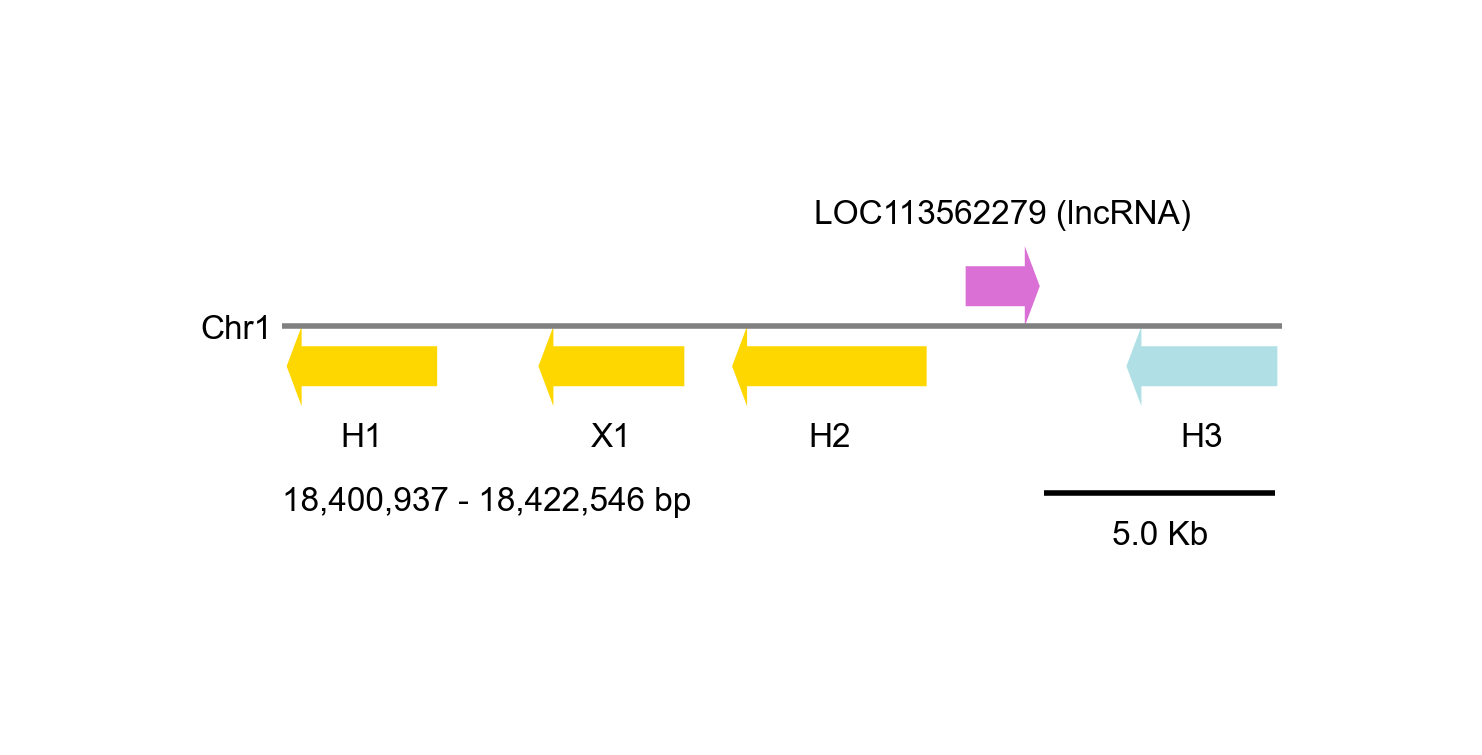

In [60]:
chromosome = tr.get_gene(lncRNA).chromosome
start = min(rows.or_start)-100
end = max(rows.or_end)+100
print(f"Chromosome: {chromosome}, Start: {start}, End: {end}")

white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
gv = GenomeViz(track_align_type="center", theme="light", fig_width=2.5, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.5, labelsize=6)

# Get bounds 
track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=1)
import re 

# Add gene models to plot 
for gene in [lncRNA] + list(upstream_ORs) + list(downstream_ORs):
    transcript = tr.get_gene(gene).get_transcript_longest_bounds()
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    if gene in upstream_ORs:
        gene = re.sub('Or5-','',gene)
        color = 'gold'
        label = f'{gene}'
    elif gene in downstream_ORs:
        gene = re.sub('Or5-','',gene)
        color = 'powderblue'
        label = f'{gene}'
    elif gene == lncRNA: 
        color = 'orchid'
        label = f'{gene} (lncRNA)'
    else: 
        color = 'grey'
        label = gene
        
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        ec='black', 
        lw=0,
        text_kws={'color': 'black', 
                  'rotation': 0, 
                  'vpos': vpos, 
                  'hpos': 'center', 
                  'size':6}
    )

fig = gv.plotfig(dpi=200)
gv.savefig(f"../figures/h1-h3-lnc.pdf", pad_inches=0, dpi=200)
plt.show()

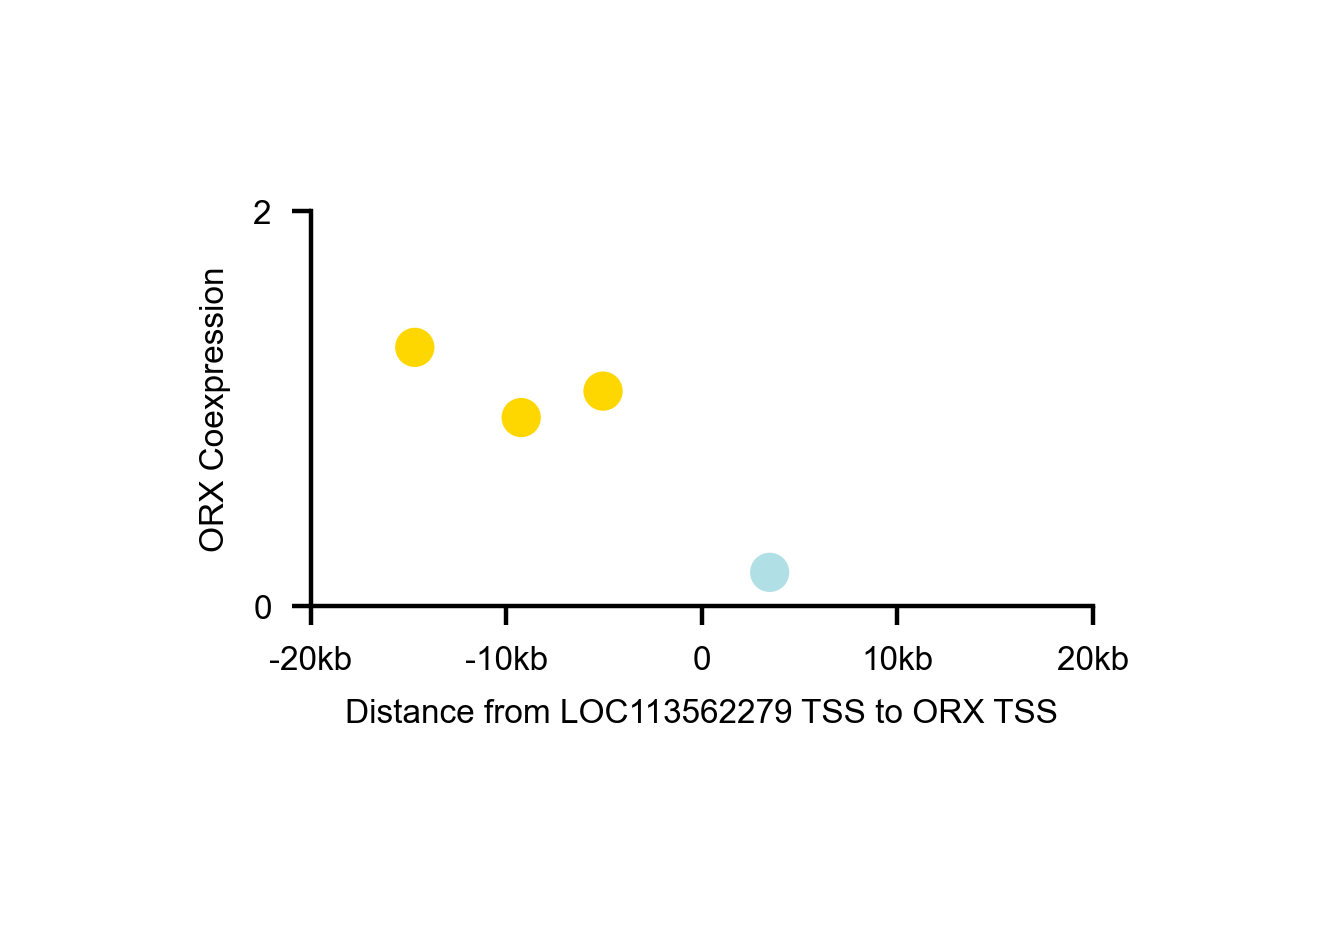

In [61]:
# Scatter plot of coexpression vs distance_adjusted, two subplots for P1 and P14, with KDE 
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
f, ax = plt.subplots(1, 1, figsize=(2.5, 1.5), dpi=200)
palette=['gold', 'powderblue']
sns.scatterplot(data=rows, x='distance_adjusted', y="OR_coexpression", ax=ax, hue='location', hue_order=['upstream', 'downstream'], palette=palette, s=50, legend=False, lw=0, edgecolor='black', alpha=1)
ax.set_xlabel(f'Distance from {lncRNA} TSS to ORX TSS', fontsize=6)
ax.set_ylabel('ORX Coexpression', fontsize=6)
#ax.set_title(f'ORX Coexpression with {lncRNA} lncRNA', fontsize=6)
ax.set_xlim(-20_000, 20_000)
ax.set_xticks([-20_000, -10_000, 0, 10_000, 20_000])
ax.set_xticklabels(['-20kb', '-10kb', '0', '10kb', '20kb'], fontsize=6)
#ax.legend(title='OR Relative Location', loc='upper right', fontsize=6, title_fontsize=6, frameon=False)
ax.set_yticks([0, 2], labels=[0, 2], fontsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig(f"../figures/h1-h3-lncrna-coexpression.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

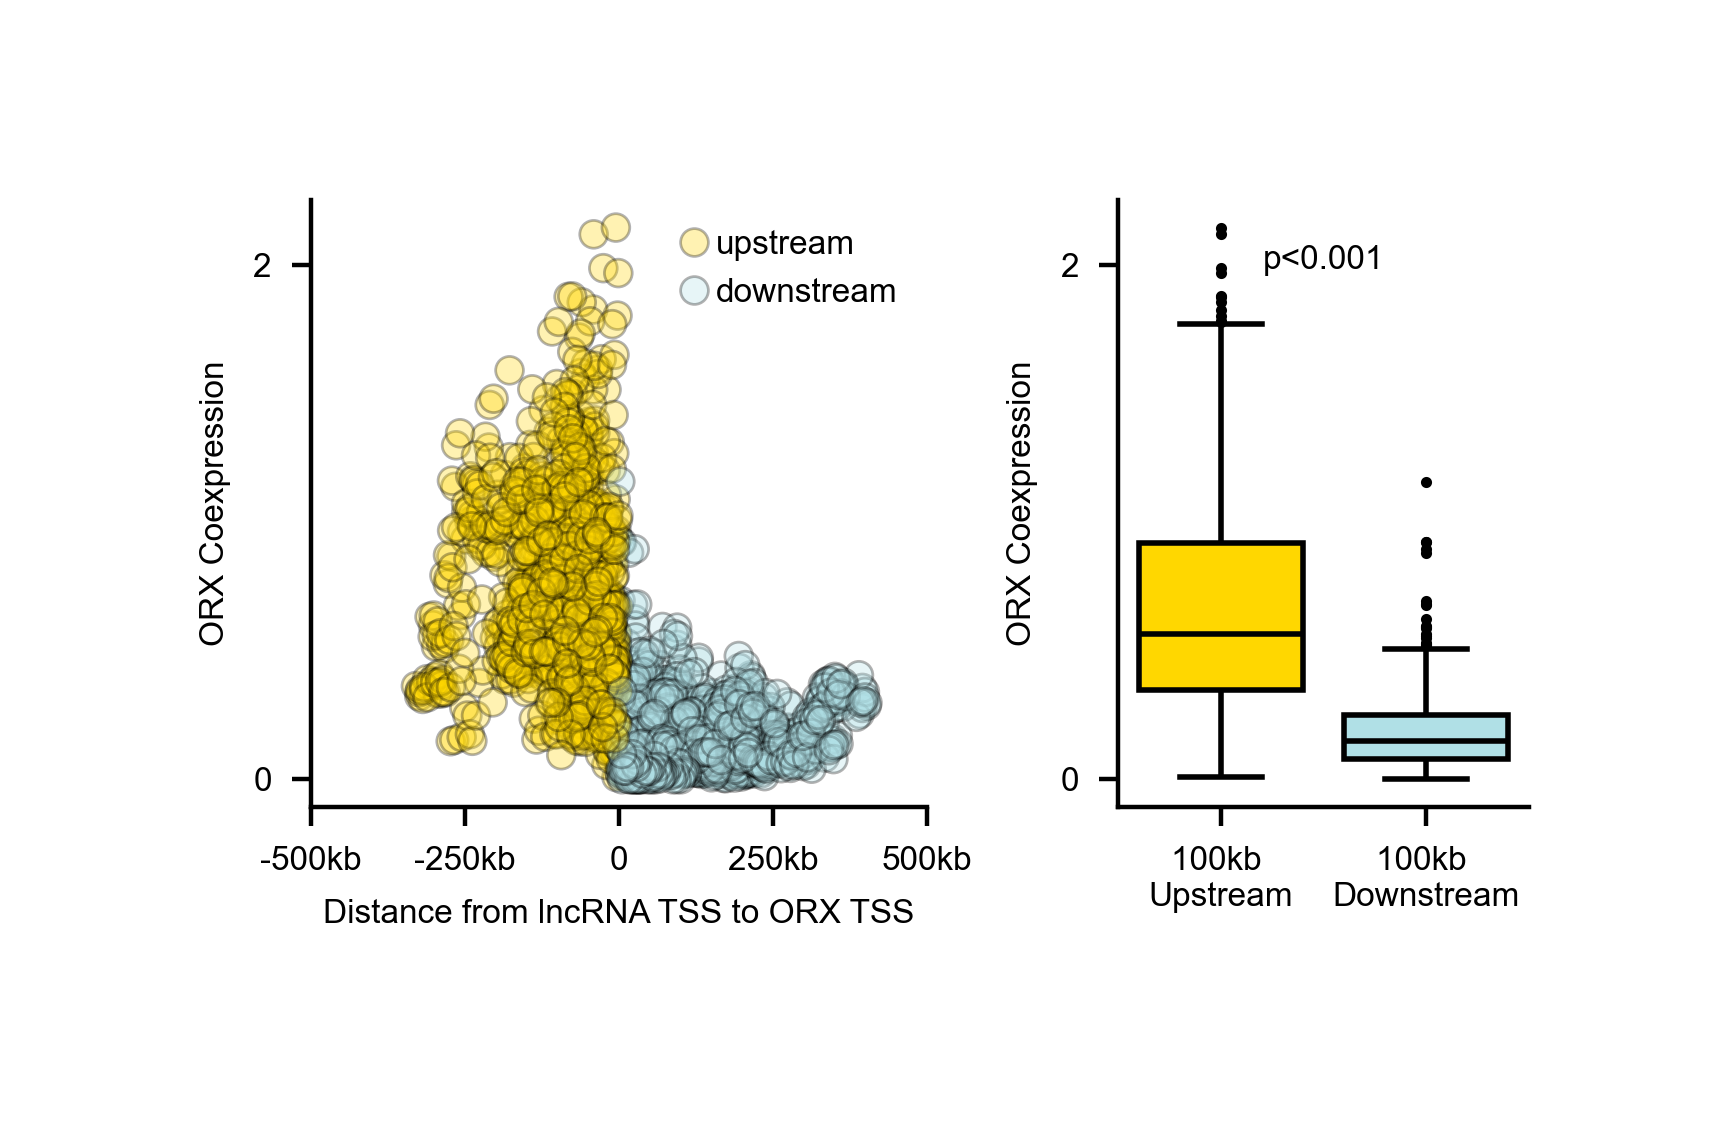

In [62]:
# Scatter plot of coexpression vs distance_adjusted, two subplots for P1 and P14, with KDE 
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
f, axs = plt.subplots(1, 2, figsize=(3.5, 2), width_ratios=[0.6, 0.4], dpi=200)
palette=['gold', 'powderblue']
ax = axs[0]
sns.scatterplot(data=lnc_associated_ORs, x='distance_adjusted', y="OR_coexpression", ax=ax, hue='location', hue_order=['upstream', 'downstream'], palette=palette, s=25, legend=True, lw=0.5, edgecolor='black', alpha=0.3)
ax.set_xlabel('Distance from lncRNA TSS to ORX TSS', fontsize=6)
ax.set_ylabel('ORX Coexpression', fontsize=6)
ax.set_xlim(-500_000, 500_000)
ax.set_xticks([-500_000, -250_000, 0, 250_000, 500_000])
ax.set_yticks([0, 2], labels=[0, 2], fontsize=6)
ax.set_xticklabels(['-500kb', '-250kb', '0', '250kb', '500kb'], fontsize=6)
ax.legend(loc='upper right', fontsize=6, frameon=False) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = axs[1]
max_distance = 100_000
data_subset=lnc_associated_ORs[lnc_associated_ORs['tss2tss'] < max_distance]
labels = ['100kb \nUpstream', '100kb \nDownstream']
# Plot box plot of OR coexpression by location and add stats 
bx = sns.boxplot(data=data_subset, x='location', y='OR_coexpression', ax=ax, palette=palette, saturation=1, hue_order=['upstream', 'downstream'], order=['upstream', 'downstream'], linewidth=1, linecolor='black', fliersize=1)
for patch in bx.patches:
    patch.set_alpha(1)
ax.set_xlabel('')
ax.set_ylabel('ORX Coexpression', fontsize=6)
ax.set_xticks([0, 1], labels=labels, fontsize=6)
ax.set_yticks([0, 2], labels=[0, 2], fontsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Rank sum test 
upstream = data_subset.loc[data_subset['location'] == 'upstream', 'OR_coexpression']
downstream = data_subset.loc[data_subset['location'] == 'downstream', 'OR_coexpression']
from scipy.stats import ranksums
stat, p = ranksums(upstream, downstream)
p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
plt.text(0.5, 0.9, p_value_str, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=6)

#plt.suptitle(f'ORX Coexpression with Annotated Antisense lncRNAs Nested in Tandem Arrays', fontsize=6, y=0.85)
plt.tight_layout()
plt.savefig(f"../figures/all-ors-relative-to-lncs.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

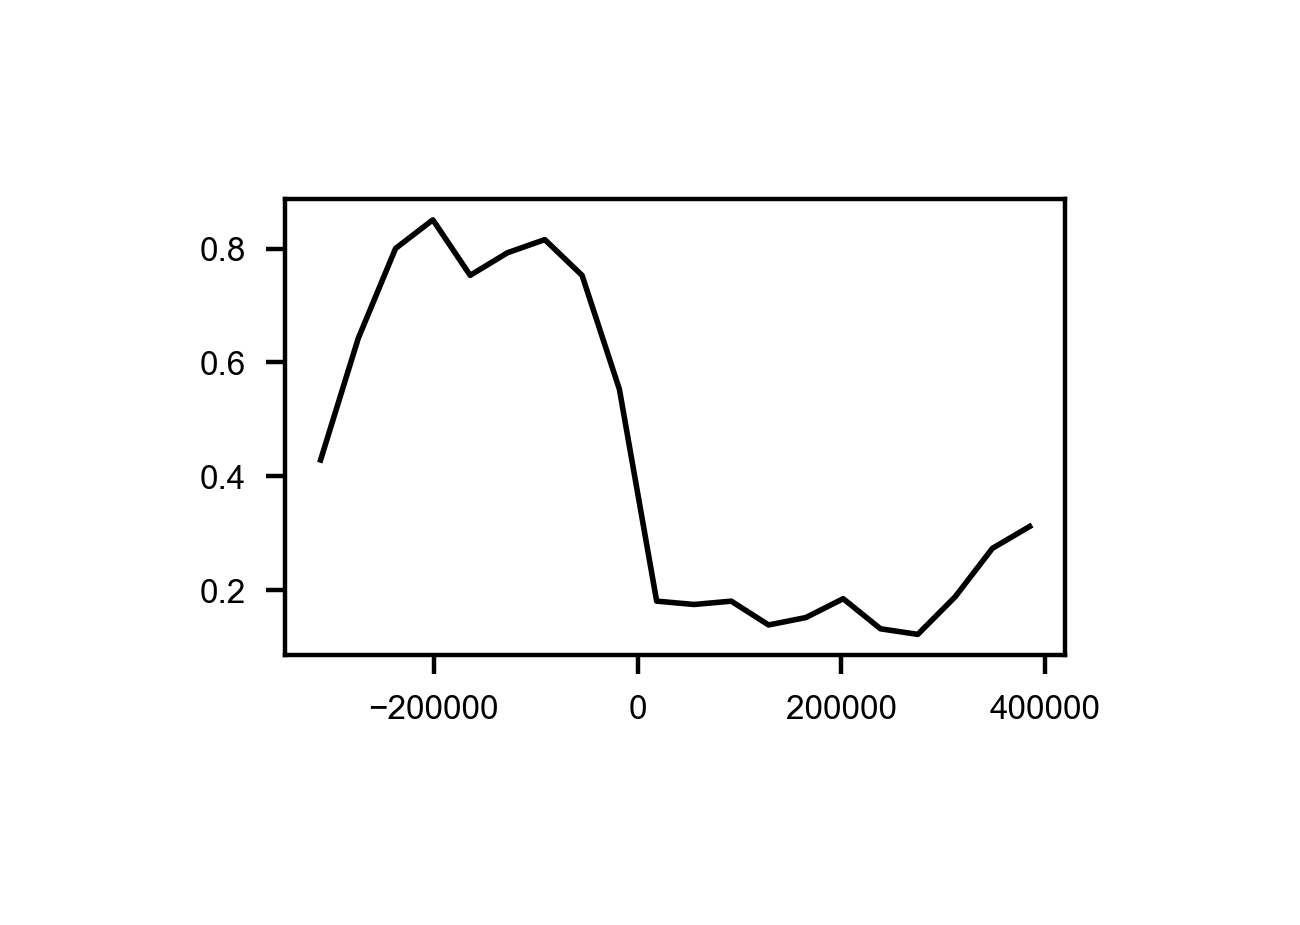

In [63]:
# Plot mean OR_coexpression by distance_adjusted
# Bin distance_adjusted into 20 bins 
n_bins = 20 
lnc_associated_ORs['distance_adjusted_bins'] = pd.cut(lnc_associated_ORs['distance_adjusted'], bins=n_bins)
binned = lnc_associated_ORs.groupby('distance_adjusted_bins')['OR_coexpression'].mean().reset_index()
binned['distance_adjusted'] = binned['distance_adjusted_bins'].apply(lambda x: x.mid).astype(int)
binned.rename(columns={'OR_coexpression': 'mean_OR_coexpression'}, inplace=True)
binned['std'] = lnc_associated_ORs.groupby('distance_adjusted_bins')['OR_coexpression'].std().reset_index()['OR_coexpression']
binned['lower'] = binned['mean_OR_coexpression'] - binned['std']
binned['upper'] = binned['mean_OR_coexpression'] + binned['std']

#plt.plot(distance_bins, mean_coexpression['OR_coexpression'], color='black', linewidth=1)
# Plot line with std bars
f, ax = plt.subplots(1, 1, figsize=(2.5, 1.5), dpi=200)
ax.plot(binned['distance_adjusted'], binned['mean_OR_coexpression'], color='black', linewidth=1)
#ax.fill_between(binned['distance_adjusted'], binned['lower'], binned['upper'], color='grey', alpha=0.5)

## Identify cells with valence OR in a tandem array that has a lncRNA 

In [64]:
# Make a dataframe with cell ID in a column and individual columns for each OR 
cell_or_expression_p14 = pd.DataFrame(index=adata.obs.index, columns=or_db.gene_name)
for i, row in or_db.iterrows(): 
    cell_or_expression_p14[row.gene_name] = adata[:,row['gene_name']].X.toarray().flatten()

In [65]:
# Find the highest-expressing OR in each cell 
cell_or_expression_p14_no_orco = cell_or_expression_p14.drop(columns=['Or5-Orco'])
cell_valence_OR = cell_or_expression_p14_no_orco.idxmax(axis=1)
cell_valence_OR = cell_valence_OR.reset_index()
cell_valence_OR.columns = ['cell_index', 'valence_OR']
cell_valence_OR['tandem_array'] = cell_valence_OR['valence_OR'].apply(lambda x: or_db.loc[or_db['gene_name'] == x, 'tandem_array'].values[0])
cell_valence_OR['or_strand'] = cell_valence_OR['valence_OR'].apply(lambda x: tr.get_gene(x).strand)
cell_valence_OR

cell_index valence_OR  tandem_array or_strand
0      S1_AAAGAACCATATTCGG-1_3  Or5-9E255            17         +
1      S1_AAAGGTATCAGGTAAA-1_3  Or5-9E338            17         -
2      S1_AACAACCAGTAGCTCT-1_3   Or5-9E25            60         -
3      S1_AACAACCGTGCCCTTT-1_3  Or5-9E137            48         -
4      S1_AACAGGGAGAAATCCA-1_3  Or5-9E128            45         -
...                        ...        ...           ...       ...
11996  S2_TTTATGCTCCGATCTC-1_4    Or5-V13            54         -
11997  S2_TTTCCTCGTATATGGA-1_4  Or5-9E227            38         -
11998  S2_TTTGGAGGTGAACTAA-1_4    Or5-U39            19         +
11999  S2_TTTGGAGGTTATAGAG-1_4    Or5-U43            19         +
12000  S2_TTTGGTTCATCTAGAC-1_4     Or5-W1            77         -

[12001 rows x 4 columns]

In [66]:
# Remove cells that do not have a lncRNA in the tandem array 
cell_valence_OR = cell_valence_OR[cell_valence_OR['tandem_array'].isin(nested_lncRNAs['TA'])].reset_index(drop=True)
cell_valence_OR

cell_index valence_OR  tandem_array or_strand
0     S1_AAAGAACCATATTCGG-1_3  Or5-9E255            17         +
1     S1_AAAGGTATCAGGTAAA-1_3  Or5-9E338            17         -
2     S1_AACAACCGTGCCCTTT-1_3  Or5-9E137            48         -
3     S1_AACAGGGAGAAATCCA-1_3  Or5-9E128            45         -
4     S1_AACCACAAGTCACGCC-1_3    Or5-U61            19         +
...                       ...        ...           ...       ...
8634  S2_TTTACGTGTGAGATTA-1_4   Or5-9E44            62         -
8635  S2_TTTATGCTCCGATCTC-1_4    Or5-V13            54         -
8636  S2_TTTCCTCGTATATGGA-1_4  Or5-9E227            38         -
8637  S2_TTTGGAGGTGAACTAA-1_4    Or5-U39            19         +
8638  S2_TTTGGAGGTTATAGAG-1_4    Or5-U43            19         +

[8639 rows x 4 columns]

## Assign lncRNAs to valence ORs 
- Assert that the lncRNA and valence OR are on opposite strands 
- Assert that all transcript isoforms have a 3' end that is upstream of the OR TSS 
- Assert that max distance from the lncRNA 3' end (across all transcript isoforms) to the TSS is less than 10kb 
- Only save the lncRNA with the minimum `tss_2_lnc_end` distance 
- Remove cells where no lncRNA was assigned 
- Save expression of lncRNA and valence OR for each cell 

In [67]:
# For each cell and valence OR, look for a lncRNA whose 3' end is upstream of the OR TSS and whose 5' end is closest to the OR TSS 
max_distance = 10_000
for i, row in tqdm(cell_valence_OR.iterrows(), total=cell_valence_OR.shape[0]):
    or_bounds = tr.get_gene(row['valence_OR']).get_transcript_longest_cds().get_bounds()
    or_tss = or_bounds[0] if row['or_strand'] == "+" else or_bounds[1]
    # Get lncRNAs in the TA
    relevant_lncRNAs = nested_lncRNAs[nested_lncRNAs['TA'] == row['tandem_array']]
    relevant_lncRNAs['tss2tss'] = None
    relevant_lncRNAs['all_upstream'] = None
    for j, lncRNA in relevant_lncRNAs.iterrows():
        # check that strands are opposite 
        if row['or_strand'] == lncRNA['lnc_strand']:
            continue
        # get the bounds of the lncRNA 
        lnc_transcripts = tr.get_gene(lncRNA['gene_name']).transcripts 
        end_ind = 1 if lncRNA['lnc_strand'] == "+" else 0
        lnc_ends = [transcript.get_bounds()[end_ind] for transcript in lnc_transcripts]
        lnc_starts = [transcript.get_bounds()[1-end_ind] for transcript in lnc_transcripts]
        # Check that all transcripts have a 3' end upstream of the OR TSS
        all_upstream = all([lnc_end < or_tss for lnc_end in lnc_ends]) if row['or_strand'] == "+" else all([lnc_end > or_tss for lnc_end in lnc_ends])
        if all_upstream: 
            #tss_to_tss = min([abs(or_tss - lnc_start) for lnc_start in lnc_starts])
            tss_to_tss = min([(or_tss - lnc_start) for lnc_start in lnc_starts]) if row['or_strand'] == "+" else min([lnc_start - or_tss for lnc_start in lnc_starts])
            tss_2_lnc_end = min([abs(lnc_end - or_tss) for lnc_end in lnc_ends])
            relevant_lncRNAs.at[j, 'tss_2_lnc_end'] = tss_2_lnc_end
            relevant_lncRNAs.at[j, 'tss2tss'] = tss_to_tss
            relevant_lncRNAs.at[j, 'all_upstream'] = True
    # Save the lncRNA with the smallest tss2tss
    if relevant_lncRNAs.shape[0] > 0 and np.sum(relevant_lncRNAs['all_upstream']) > 0:
        relevant_lncRNAs = relevant_lncRNAs[relevant_lncRNAs['all_upstream']==True]
        relevant_lncRNAs = relevant_lncRNAs.iloc[np.argmin(relevant_lncRNAs['tss_2_lnc_end']), :]
        # Verify tss_2_lnc_end < max_distance 
        if relevant_lncRNAs['tss_2_lnc_end'] > max_distance: 
            continue
        cell_valence_OR.at[i, 'lncRNA'] = relevant_lncRNAs['gene_name']
        cell_valence_OR.at[i, 'tss_2_lnc_end'] = relevant_lncRNAs['tss_2_lnc_end']
        cell_valence_OR.at[i, 'tss2tss'] = relevant_lncRNAs['tss2tss']
        cell_valence_OR.at[i, 'lnc_strand'] = relevant_lncRNAs['lnc_strand']

cell_valence_OR

100%|██████████| 8639/8639 [00:08<00:00, 995.26it/s] 


cell_index valence_OR  tandem_array or_strand  \
0     S1_AAAGAACCATATTCGG-1_3  Or5-9E255            17         +   
1     S1_AAAGGTATCAGGTAAA-1_3  Or5-9E338            17         -   
2     S1_AACAACCGTGCCCTTT-1_3  Or5-9E137            48         -   
3     S1_AACAGGGAGAAATCCA-1_3  Or5-9E128            45         -   
4     S1_AACCACAAGTCACGCC-1_3    Or5-U61            19         +   
...                       ...        ...           ...       ...   
8634  S2_TTTACGTGTGAGATTA-1_4   Or5-9E44            62         -   
8635  S2_TTTATGCTCCGATCTC-1_4    Or5-V13            54         -   
8636  S2_TTTCCTCGTATATGGA-1_4  Or5-9E227            38         -   
8637  S2_TTTGGAGGTGAACTAA-1_4    Or5-U39            19         +   
8638  S2_TTTGGAGGTTATAGAG-1_4    Or5-U43            19         +   

            lncRNA  tss_2_lnc_end  tss2tss lnc_strand  
0              NaN            NaN      NaN        NaN  
1              NaN            NaN      NaN        NaN  
2              NaN            NaN      NaN        NaN  
3              NaN            NaN      NaN        NaN  
4              NaN            NaN      NaN        NaN  
...            ...            ...      ...        ...  
8634           NaN            NaN      NaN        NaN  
8635           NaN            NaN      NaN        NaN  
8636           NaN            NaN      NaN        NaN  
8637           NaN            NaN      NaN        NaN  
8638  LOC113562247         1651.0      2.0          -  

[8639 rows x 8 columns]

In [68]:
print(f"Dropped {cell_valence_OR[cell_valence_OR.tss_2_lnc_end < 0].shape[0]} rows where tss_2_lnc_end is negative")
cell_valence_OR = cell_valence_OR[cell_valence_OR.tss_2_lnc_end > 0].reset_index(drop=True)
cell_valence_OR = cell_valence_OR.dropna().reset_index(drop=True)
cell_valence_OR

Dropped 0 rows where tss_2_lnc_end is negative


cell_index valence_OR  tandem_array or_strand  \
0     S1_AATGCCACAAGCGCTC-1_3  Or5-9E225            38         -   
1     S1_ACCACAAAGCGAGAAA-1_3     Or5-X1            80         -   
2     S1_ACCCTCACATACATCG-1_3  Or5-9E102            51         +   
3     S1_ACTGCAAGTGCATTTG-1_3   Or5-9E92            51         +   
4     S1_AGTAGTCGTTATGACC-1_3  Or5-9E328            17         -   
...                       ...        ...           ...       ...   
2394  S2_TTGACCCGTTGCGTAT-1_4  Or5-9E179            34         +   
2395  S2_TTGCTGCCACTCGATA-1_4  Or5-9E321            17         -   
2396  S2_TTGGTTTTCACCATGA-1_4    Or5-E20             9         -   
2397  S2_TTGTGGACACCCTGAG-1_4  Or5-9E301            17         -   
2398  S2_TTTGGAGGTTATAGAG-1_4    Or5-U43            19         +   

            lncRNA  tss_2_lnc_end  tss2tss lnc_strand  
0     LOC105279431         6611.0   5464.0          +  
1     LOC113562279         7681.0   6079.0          +  
2     LOC113561650         7356.0   5922.0          -  
3     LOC113561649         1423.0   -116.0          -  
4     LOC109611384          993.0    281.0          +  
...            ...            ...      ...        ...  
2394  LOC113562188          196.0  -1537.0          -  
2395  LOC113562730         7288.0   4468.0          +  
2396  LOC113562930         5248.0   4184.0          +  
2397  LOC105285736         2283.0      1.0          +  
2398  LOC113562247         1651.0      2.0          -  

[2399 rows x 8 columns]

In [69]:
# Get expression of lncRNA and valence OR in each cell 
cell_valence_OR['lncRNA_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['lncRNA']].X.toarray().flatten()[0], axis=1)
cell_valence_OR['valence_OR_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['valence_OR']].X.toarray().flatten()[0], axis=1)

## Get ORs upstream and downstream of the valence OR 
- Assert that the valence OR is not at the start or the end of the tandem array (ensuring it has both a downstream and upstream OR)
- Assert that the valence OR and both it's upstream and downstream ORs are on the same strand 
- Save the expression of both the upstream and downstream ORs for each cell 

In [70]:
# Get upstream and downstream ORs 
for i, row in tqdm(cell_valence_OR.iterrows(), total=cell_valence_OR.shape[0]): 
    valence_strand = or_db.loc[or_db['gene_name'] == row['valence_OR'], 'strand'].values[0]
    valence_tss = or_db.loc[or_db['gene_name'] == row['valence_OR'], 'start'].values[0]
    other_ORs = or_db.loc[or_db['tandem_array'] == row['tandem_array']] 
    valence_index = or_db.loc[or_db['gene_name'] == row['valence_OR'], 'ta_index'].values[0]
    TA_size = or_db.loc[or_db['gene_name'] == row['valence_OR'], 'ta_size'].values[0]
    # if or's index is 1 or ta_index, continue 
    if valence_index == 0 or valence_index == TA_size:
        continue
    if valence_tss == np.min(other_ORs['start']) or valence_tss == np.max(other_ORs['start']):
        continue
    if valence_strand == '+': 
        # find OR in other_ORs that is closest to the start of valence_OR
        upstream_OR = other_ORs[other_ORs['start'] < valence_tss].sort_values(by='start', ascending=False).iloc[0]
        downstream_OR = other_ORs[other_ORs['start'] > valence_tss].sort_values(by='start').iloc[0]
    else: 
        # find OR in other_ORs that is closest to the start of valence_OR
        upstream_OR = other_ORs[other_ORs['start'] > valence_tss].sort_values(by='start').iloc[0]
        downstream_OR = other_ORs[other_ORs['start'] < valence_tss].sort_values(by='start', ascending=False).iloc[0]
    cell_valence_OR.at[i, 'upstream_OR'] = upstream_OR['gene_name']
    cell_valence_OR.at[i, 'downstream_OR'] = downstream_OR['gene_name']

100%|██████████| 2399/2399 [00:01<00:00, 1419.40it/s]


In [71]:
# Drop NaN Rows 
cell_valence_OR = cell_valence_OR.dropna().reset_index(drop=True)

In [72]:
# Get strand for upstream and downstream ORs
cell_valence_OR['upstream_OR_strand'] = cell_valence_OR['upstream_OR'].apply(lambda x: or_db.loc[or_db['gene_name'] == x, 'strand'].values[0])
cell_valence_OR['downstream_OR_strand'] = cell_valence_OR['downstream_OR'].apply(lambda x: or_db.loc[or_db['gene_name'] == x, 'strand'].values[0])

In [73]:
# Remove rows where upstream and valence and downstream ORs are not all on the same strand 
cell_valence_OR = cell_valence_OR[(cell_valence_OR['upstream_OR_strand'] == cell_valence_OR['or_strand']) & (cell_valence_OR['downstream_OR_strand'] == cell_valence_OR['or_strand'])]
cell_valence_OR = cell_valence_OR.reset_index(drop=True)

In [74]:
# Get expression of upstream and downstream ORs in each cell
cell_valence_OR['upstream_OR_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['upstream_OR']].X.toarray().flatten()[0], axis=1)
cell_valence_OR['downstream_OR_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['downstream_OR']].X.toarray().flatten()[0], axis=1)

In [75]:
cell_valence_OR

cell_index valence_OR  tandem_array or_strand  \
0     S1_AATGCCACAAGCGCTC-1_3  Or5-9E225            38         -   
1     S1_ACCACAAAGCGAGAAA-1_3     Or5-X1            80         -   
2     S1_AGTAGTCGTTATGACC-1_3  Or5-9E328            17         -   
3     S1_ATCACTTCACGCTTAA-1_3  Or5-9E290            17         -   
4     S1_ATGTCCCGTCTGCCTT-1_3    Or5-E10            86         -   
...                       ...        ...           ...       ...   
2006  S2_TTCTAACCATCGGAAG-1_4     Or5-L4             3         +   
2007  S2_TTGACCCGTTGCGTAT-1_4  Or5-9E179            34         +   
2008  S2_TTGCTGCCACTCGATA-1_4  Or5-9E321            17         -   
2009  S2_TTGTGGACACCCTGAG-1_4  Or5-9E301            17         -   
2010  S2_TTTGGAGGTTATAGAG-1_4    Or5-U43            19         +   

            lncRNA  tss_2_lnc_end  tss2tss lnc_strand  lncRNA_expression  \
0     LOC105279431         6611.0   5464.0          +           2.160625   
1     LOC113562279         7681.0   6079.0          +           0.000000   
2     LOC109611384          993.0    281.0          +           0.000000   
3     LOC113562732         9017.0   7937.0          +           0.000000   
4     LOC113562632         7591.0   7263.0          +           0.790119   
...            ...            ...      ...        ...                ...   
2006  LOC105284280         9437.0   7572.0          -           0.000000   
2007  LOC113562188          196.0  -1537.0          -           1.421104   
2008  LOC113562730         7288.0   4468.0          +           1.578185   
2009  LOC105285736         2283.0      1.0          +           3.391492   
2010  LOC113562247         1651.0      2.0          -           4.482591   

      valence_OR_expression upstream_OR downstream_OR upstream_OR_strand  \
0                  3.456514   Or5-9E226     Or5-9E224                  -   
1                  2.659287      Or5-H2        Or5-H1                  -   
2                  1.536693   Or5-9E329     Or5-9E327                  -   
3                  1.215982   Or5-9E291     Or5-9E289                  -   
4                  3.313477     Or5-E11        Or5-E9                  -   
...                     ...         ...           ...                ...   
2006               2.792883      Or5-L3        Or5-L5                  +   
2007               4.052662   Or5-9E177     Or5-9E180                  +   
2008               2.796343   Or5-9E322     Or5-9E320                  -   
2009               4.563980   Or5-9E302     Or5-9E300                  -   
2010               4.579177     Or5-U42       Or5-U44                  +   

     downstream_OR_strand  upstream_OR_expression  downstream_OR_expression  
0                       -                1.269438                  1.811187  
1                       -                1.691699                  2.288222  
2                       -                0.000000                  0.795883  
3                       -                0.000000                  0.000000  
4                       -                3.172602                  2.106808  
...                   ...                     ...                       ...  
2006                    +                0.000000                  2.792883  
2007                    +                0.000000                  3.806299  
2008                    -                0.000000                  1.578185  
2009                    -                1.165797                  4.331895  
2010                    +                0.000000                  2.671105  

[2011 rows x 16 columns]

In [76]:
# get valence_OR counts 
cell_valence_OR['valence_OR'].value_counts()[:10]

valence_OR
Or5-E10      101
Or5-E11       66
Or5-V9        62
Or5-9E299     62
Or5-9E294     54
Or5-9E263     54
Or5-9E300     53
Or5-9E326     43
Or5-V10       42
Or5-9E267     40
Name: count, dtype: int64

## Plot Examples

In [77]:
# get unique lncRNAs that have at least 30 cells 
lncRNA_counts = cell_valence_OR['lncRNA'].value_counts()
lncRNAs = lncRNA_counts[lncRNA_counts > 30].index
lncRNAs

Index(['LOC113562632', 'LOC105285735', 'LOC109610832', 'LOC109611388',
       'LOC109611334', 'LOC113562729', 'LOC109611205', 'LOC105284280',
       'LOC105279431', 'LOC113562732', 'LOC113561400', 'LOC113562185',
       'LOC113562249', 'LOC105286685', 'LOC109611387', 'LOC113562247',
       'LOC113562188', 'LOC113561627', 'LOC109611506', 'LOC109611159',
       'LOC109611010', 'LOC105281803', 'LOC113561626', 'LOC113561649',
       'LOC113562052', 'LOC113562733', 'LOC113562730', 'LOC105277175',
       'LOC113562187', 'LOC105285099', 'LOC105275250'],
      dtype='object', name='lncRNA')

In [78]:
lncRNA = 'LOC105285735'
cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA)]
cells['valence_OR'].value_counts()


valence_OR
Or5-9E299    62
Or5-9E300    53
Name: count, dtype: int64

In [79]:
# find cells where lncRNA = LOC109611159
valence_OR = "Or5-9E300"
cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA) & (cell_valence_OR['valence_OR'] == valence_OR)]
pd.set_option('display.max_rows', 10)
cells

cell_index valence_OR  tandem_array or_strand  \
41    S1_TGAATCGGTCCAAATC-1_3  Or5-9E300            17         -   
76    S2_CGAGAAGTCTCACCCA-1_4  Or5-9E300            17         -   
90    S2_GGACGTCGTCCGAAGA-1_4  Or5-9E300            17         -   
96    S2_TACTGCCCAAGTGATA-1_4  Or5-9E300            17         -   
226   S1_AGGGTGATCCTCCACA-1_3  Or5-9E300            17         -   
...                       ...        ...           ...       ...   
1726  S1_AGATCCAAGGTTACAA-1_3  Or5-9E300            17         -   
1776  S1_GACGTTACAGGTGACA-1_3  Or5-9E300            17         -   
1808  S1_GTTACCCGTCGCTCGA-1_3  Or5-9E300            17         -   
1969  S2_TCACAAGGTCGAGTTT-1_4  Or5-9E300            17         -   
1997  S2_TGGAGAGAGGCGAAGG-1_4  Or5-9E300            17         -   

            lncRNA  tss_2_lnc_end  tss2tss lnc_strand  lncRNA_expression  \
41    LOC105285735         3901.0   3265.0          +            0.00000   
76    LOC105285735         3901.0   3265.0          +            0.00000   
90    LOC105285735         3901.0   3265.0          +            0.00000   
96    LOC105285735         3901.0   3265.0          +            0.00000   
226   LOC105285735         3901.0   3265.0          +            0.00000   
...            ...            ...      ...        ...                ...   
1726  LOC105285735         3901.0   3265.0          +            1.38547   
1776  LOC105285735         3901.0   3265.0          +            0.00000   
1808  LOC105285735         3901.0   3265.0          +            0.00000   
1969  LOC105285735         3901.0   3265.0          +            0.00000   
1997  LOC105285735         3901.0   3265.0          +            0.00000   

      valence_OR_expression upstream_OR downstream_OR upstream_OR_strand  \
41                 1.864247   Or5-9E301     Or5-9E299                  -   
76                 1.632222   Or5-9E301     Or5-9E299                  -   
90                 1.428295   Or5-9E301     Or5-9E299                  -   
96                 1.476548   Or5-9E301     Or5-9E299                  -   
226                3.664888   Or5-9E301     Or5-9E299                  -   
...                     ...         ...           ...                ...   
1726               3.525293   Or5-9E301     Or5-9E299                  -   
1776               1.876322   Or5-9E301     Or5-9E299                  -   
1808               2.297829   Or5-9E301     Or5-9E299                  -   
1969               3.797128   Or5-9E301     Or5-9E299                  -   
1997               3.495267   Or5-9E301     Or5-9E299                  -   

     downstream_OR_strand  upstream_OR_expression  downstream_OR_expression  
41                      -                1.315211                  0.000000  
76                      -                0.000000                  0.000000  
90                      -                0.000000                  0.950032  
96                      -                0.989134                  0.000000  
226                     -                0.000000                  1.569693  
...                   ...                     ...                       ...  
1726                    -                0.000000                  3.331144  
1776                    -                0.000000                  0.000000  
1808                    -                0.000000                  0.000000  
1969                    -                2.998886                  2.853008  
1997                    -                0.000000                  3.004467  

[53 rows x 16 columns]

Chromosome: Chr10, Start: 12918347, End: 12935492


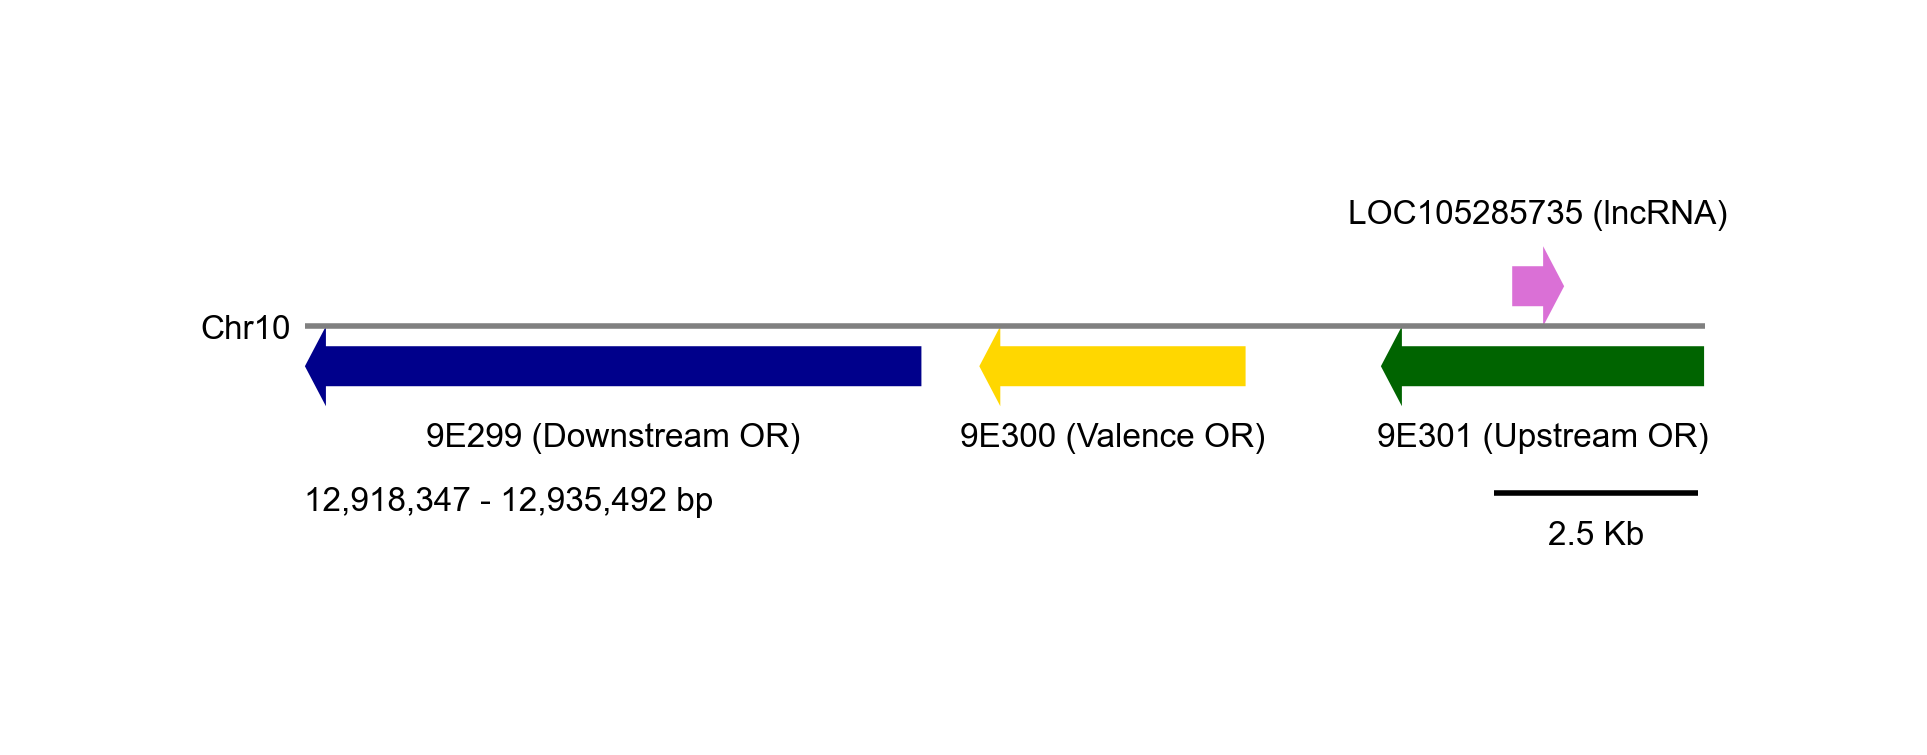

In [80]:
upstream_OR = cells['upstream_OR'].values[0]
downstream_OR = cells['downstream_OR'].values[0]
all_bounds = [tr.get_gene(gene).get_transcript_longest_bounds().get_bounds() for gene in [lncRNA, upstream_OR, valence_OR, downstream_OR]]
chromosome = tr.get_gene(lncRNA).chromosome
start = min([bounds[0] for bounds in all_bounds]) - 5
end = max([bounds[1] for bounds in all_bounds]) + 5
print(f"Chromosome: {chromosome}, Start: {start}, End: {end}")

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 

white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
gv = GenomeViz(track_align_type="center", theme="light", fig_width=3.5, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.5, labelsize=6)

fontsize=6 

# Get bounds 
track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=1)
import re 

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_bounds()
    if upstream_OR in gene: 
        color = 'darkgreen'
        gene = re.sub('Or5-','',gene)
        label = f'{gene} (Upstream OR)'
    elif downstream_OR in gene:
        color = 'darkblue'
        gene = re.sub('Or5-','',gene)
        label = f'{gene} (Downstream OR)'
    elif valence_OR in gene:
        gene = re.sub('Or5-','',gene)
        color = 'gold'
        label = f'{gene} (Valence OR)'
    elif lncRNA in gene: 
        color = 'orchid'
        label = f'{gene} (lncRNA)'
    else: 
        color = 'grey'
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        lw=0, 
        text_kws={'color': 'black', 
                  'rotation': 0, 
                  'vpos': vpos, 
                  'hpos': 'center', 
                  'size':fontsize}
    )

fig = gv.plotfig(dpi=200)
gv.savefig(f"../figures/9e299-example.pdf", pad_inches=0, dpi=200)
plt.show()

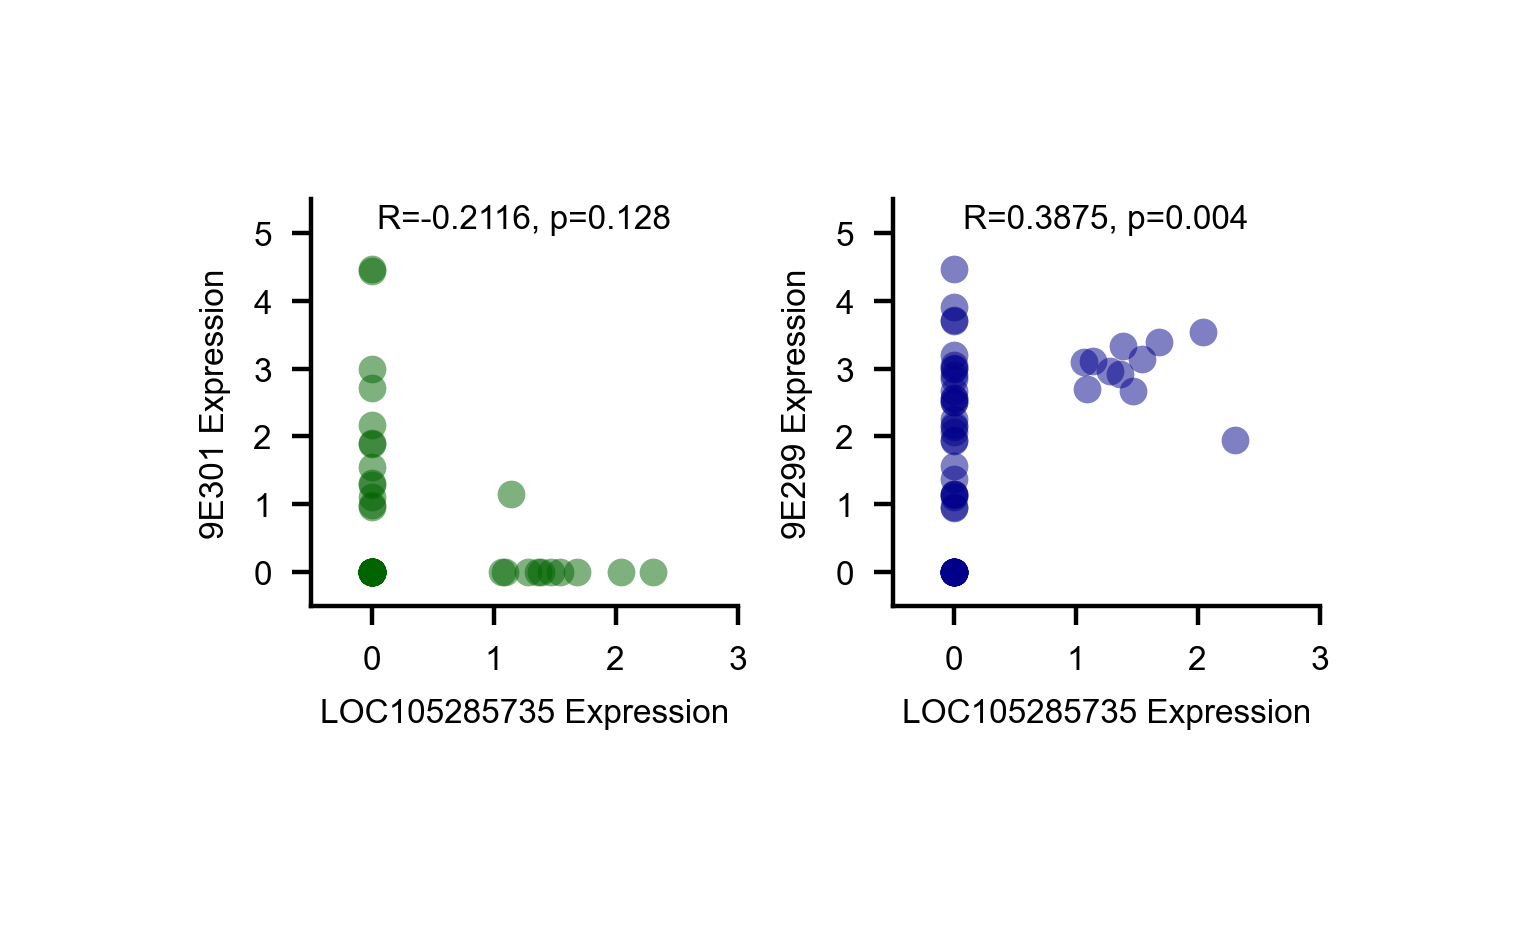

In [81]:
# Plot ustream OR expresion and downstream OR expression vs lncRNA expression bin 
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
f, ax = plt.subplots(1, 2, figsize=(3, 1.5), dpi=200)
colors = ['darkgreen', 'darkblue']
for i, OR in enumerate(['Upstream', 'Downstream']):
    sns.scatterplot(data=cells, x='lncRNA_expression', y=f'{OR.lower()}_OR_expression', ax=ax[i], color=colors[i], s=25, legend=False, lw=0, edgecolor='black', alpha=0.5)
    ax[i].set_xlabel(f'{lncRNA} Expression', fontsize=6)
    ax[i].set_ylabel(f'{re.sub("Or5-", "", cells.iloc[0][OR.lower() + "_OR"])} Expression', fontsize=6)
    r, p = pearsonr(cells['lncRNA_expression'], cells[f'{OR.lower()}_OR_expression'])
    p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
    ax[i].text(0.5, 0.95, f'R={r:.4f}, {p_value_str}', fontsize=6, ha='center', va='center', transform=ax[i].transAxes, color='black')
    ax[i].set_ylim(-0.5, 5.5)
    ax[i].set_yticks([0, 1, 2, 3, 4, 5], labels=['0', '1', '2', '3', '4', '5'], fontsize=6)
    ax[i].set_xlim(-0.5, 3)
    ax[i].set_xticks([0, 1, 2, 3], labels=['0', '1', '2', '3'], fontsize=6)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

#plt.suptitle(f"Valence OR {valence_OR} & lncRNA {lncRNA}", fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"../figures/9e299-9e301-lnc-expression.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## lncRNAs with 3' end close to OR TSS 

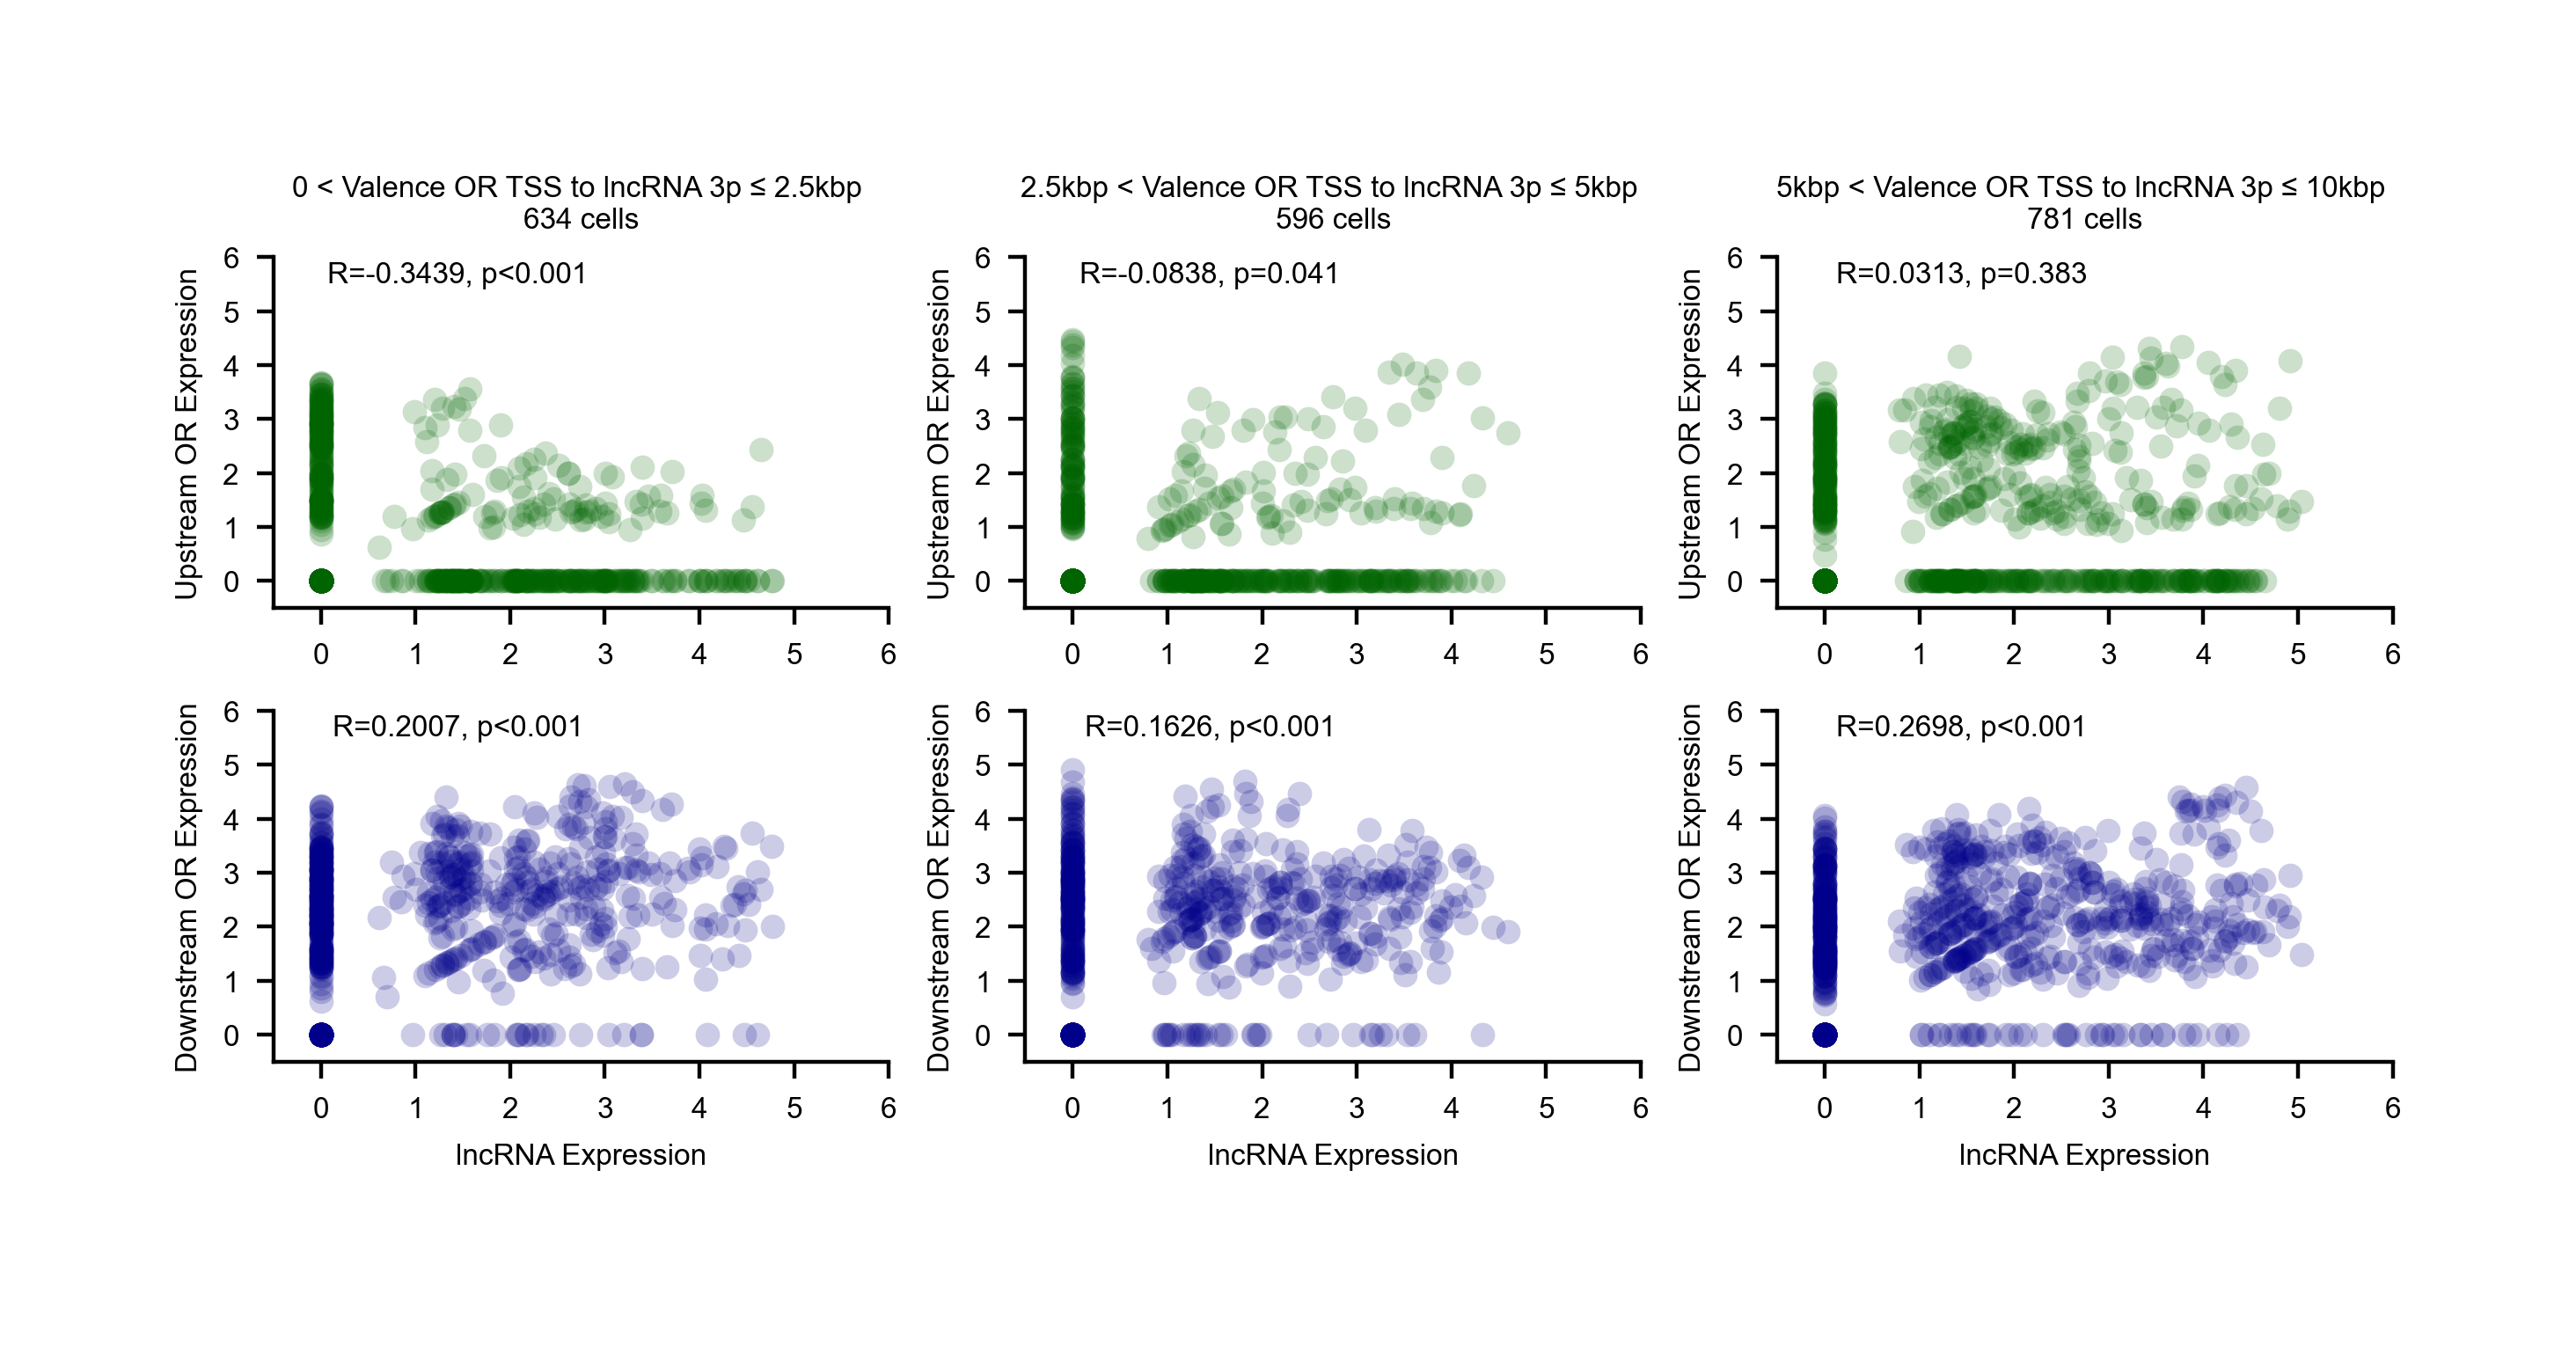

In [82]:
distances = [0, 2500, 5000, 10000] 
distance_bin_labels = ["0", "2.5kbp", "5kbp", "10kbp"]
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
# For each tss_2_lnc_end bin, plot a scatter plot of upstream OR expression vs lncRNA expression
f, ax = plt.subplots(2, len(distances)-1, figsize=(6.5, 3), dpi=200)
for i in range(len(distances)-1): 
    min_dist = distances[i]
    max_dist = distances[i+1]
    cell_valence_OR_close_bin = cell_valence_OR[(cell_valence_OR['tss_2_lnc_end'] > min_dist) & (cell_valence_OR['tss_2_lnc_end'] <= max_dist)]
    
    # Upstream 
    sns.scatterplot(data=cell_valence_OR_close_bin, x='lncRNA_expression', y='upstream_OR_expression', ax=ax[0, i], color='darkgreen', s=25, legend=False, alpha=0.2, lw=0, edgecolor='black')
    r, p = pearsonr(cell_valence_OR_close_bin['lncRNA_expression'], cell_valence_OR_close_bin['upstream_OR_expression'])
    p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
    ax[0, i].text(0.3, 0.95, f'R={r:.4f}, {p_value_str}', fontsize=6, ha='center', va='center', transform=ax[0, i].transAxes, color='black')
    ax[0, i].set_ylabel('Upstream OR Expression', fontsize=6)
    ax[0, i].set_xlabel('')
    ax[0, i].set_title(f'{distance_bin_labels[i]} < Valence OR TSS to lncRNA 3p ≤ {distance_bin_labels[i+1]} \n{cell_valence_OR_close_bin.shape[0]} cells', fontsize=6)
    ax[0, i].set_ylim(-0.5, 6)
    ax[0, i].set_xlim(-0.5, 6)
    ax[0, i].set_yticks([0, 1, 2, 3, 4, 5, 6], labels=['0', '1', '2', '3', '4', '5', '6'], fontsize=6)
    ax[0, i].set_xticks([0, 1, 2, 3, 4, 5, 6], labels=['0', '1', '2', '3', '4', '5', '6'], fontsize=6)
    ax[0, i].spines['right'].set_visible(False)
    ax[0, i].spines['top'].set_visible(False)

    # Downstream 
    sns.scatterplot(data=cell_valence_OR_close_bin, x='lncRNA_expression', y='downstream_OR_expression', ax=ax[1, i], color='darkblue', s=25, legend=False, alpha=0.2, lw=0, edgecolor='black')
    r, p = pearsonr(cell_valence_OR_close_bin['lncRNA_expression'], cell_valence_OR_close_bin['downstream_OR_expression'])
    p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
    ax[1, i].text(0.3, 0.95, f'R={r:.4f}, {p_value_str}', fontsize=6, ha='center', va='center', transform=ax[1, i].transAxes, color='black')
    ax[1, i].set_ylabel('Downstream OR Expression', fontsize=6)
    ax[1, i].set_xlabel('lncRNA Expression', fontsize=6)
    ax[1, i].set_ylim(-0.5, 6)
    ax[1, i].set_xlim(-0.5, 6)
    ax[1, i].set_title('')
    ax[1, i].set_yticks([0, 1, 2, 3, 4, 5, 6], labels=['0', '1', '2', '3', '4', '5', '6'], fontsize=6)
    ax[1, i].set_xticks([0, 1, 2, 3, 4, 5, 6], labels=['0', '1', '2', '3', '4', '5', '6'], fontsize=6)
    ax[1, i].spines['right'].set_visible(False)
    ax[1, i].spines['top'].set_visible(False)
    

plt.tight_layout()
plt.savefig(f"../figures/lnc-inhibits-upstream-obir.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

In [83]:
# Get the percent of cells in the first bin that have either 0 lncRNA or 0 upstream OR expression
cell_valence_OR_close_bin = cell_valence_OR[(cell_valence_OR['tss_2_lnc_end'] > 0) & (cell_valence_OR['tss_2_lnc_end'] <= 2500)]
cells_zero_lnc = cell_valence_OR_close_bin[cell_valence_OR_close_bin['lncRNA_expression'] == 0].shape[0] 
cells_zero_upstream = cell_valence_OR_close_bin[cell_valence_OR_close_bin['upstream_OR_expression'] == 0].shape[0]
cell_zero_lnc_or_upstream = cell_valence_OR_close_bin[(cell_valence_OR_close_bin['lncRNA_expression'] == 0) | (cell_valence_OR_close_bin['upstream_OR_expression'] == 0)].shape[0]
cells_total = cell_valence_OR_close_bin.shape[0]
print(f"Percent of cells with 0 lncRNA expression: {cells_zero_lnc / cells_total:.3f}")
print(f"Percent of cells with 0 upstream OR expression: {cells_zero_upstream / cells_total:.3f}")
print(f"Percent of cells with 0 lncRNA or 0 upstream OR expression: {cell_zero_lnc_or_upstream / cells_total:.3f}")

Percent of cells with 0 lncRNA expression: 0.454
Percent of cells with 0 upstream OR expression: 0.591
Percent of cells with 0 lncRNA or 0 upstream OR expression: 0.847


### Plot Correlations for each unique lncRNA

In [84]:
# Get unique lncRNAs 
lncRNAs = cell_valence_OR['lncRNA'].unique()

# For each lncRNA, get the Pearson correlation of lncRNA expression vs OR expression for upstream and downstream ORs
results = [] 
for lncRNA in lncRNAs: 
    # Get the valence OR with the smallest tss_2_lnc_end
    closest_valence, tss_2_lnc_end = cell_valence_OR.loc[cell_valence_OR['lncRNA'] == lncRNA].sort_values('tss_2_lnc_end').iloc[0][['valence_OR', 'tss_2_lnc_end']]
    cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA) & (cell_valence_OR['valence_OR'] == closest_valence)]
    if cells.shape[0] < 3: 
        # Skip if there are fewer than 3 cells, necessary for Pearson correlation
        continue
    r_up, p_up = pearsonr(cells['lncRNA_expression'], cells[f'upstream_OR_expression'])
    r_down, p_down = pearsonr(cells['lncRNA_expression'], cells[f'downstream_OR_expression'])
    r_valence, p_up = pearsonr(cells['lncRNA_expression'], cells['valence_OR_expression'])

    tss_2_lnc_end = cells['tss_2_lnc_end'].values[0]
    tss2tss = cells['tss2tss'].values[0]

    results.append({'lncRNA':lncRNA, 'valence': closest_valence, 'n_cells':cells.shape[0],  'tss_2_lnc_end': tss_2_lnc_end, 'tss2tss': tss2tss, 
                    'r_up': r_up, 'p_up': p_up, 'r_down': r_down, 'p_down': p_down, 'r_valence': r_valence, 'p_valence': p_up})

results = pd.DataFrame(results)
results

lncRNA    valence  n_cells  tss_2_lnc_end   tss2tss      r_up  \
0   LOC105279431  Or5-9E226       27         1482.0     335.0 -0.188291   
1   LOC113562279     Or5-H2        8         2445.0     843.0  0.053425   
2   LOC109611384  Or5-9E328       18          993.0     281.0 -0.179224   
3   LOC113562732  Or5-9E292       12          728.0    -352.0 -0.339513   
4   LOC113562632    Or5-E11       66         4355.0    4027.0  0.025571   
..           ...        ...      ...            ...       ...       ...   
43  LOC109611203  Or5-9E121       18         2770.0    1956.0 -0.441609   
44  LOC105285750  Or5-9E315        5         7477.0 -239947.0 -0.640949   
45  LOC105277175    Or5-V21       33         1594.0      10.0 -0.223290   
46  LOC109611015   Or5-9E50       21         2046.0     314.0  0.327459   
47  LOC113562248    Or5-U48        9         1957.0    1607.0 -0.928784   

        p_up    r_down    p_down  r_valence  p_valence  
0   0.171611  0.479052  0.011467   0.270957   0.171611  
1   0.739557  0.236443  0.572915   0.140751   0.739557  
2   0.441891  0.197291  0.432628   0.193420   0.441891  
3   0.299595  0.610302  0.035072   0.326949   0.299595  
4   0.242634  0.218361  0.078171   0.145840   0.242634  
..       ...       ...       ...        ...        ...  
43  0.870715  0.071765  0.777194  -0.041310   0.870715  
44  0.811522 -0.297357  0.627050   0.148579   0.811522  
45  0.387437  0.050696  0.779340   0.155529   0.387437  
46  0.170481  0.446020  0.042705   0.310663   0.170481  
47  0.492175  0.513377  0.157492  -0.264161   0.492175  

[48 rows x 11 columns]

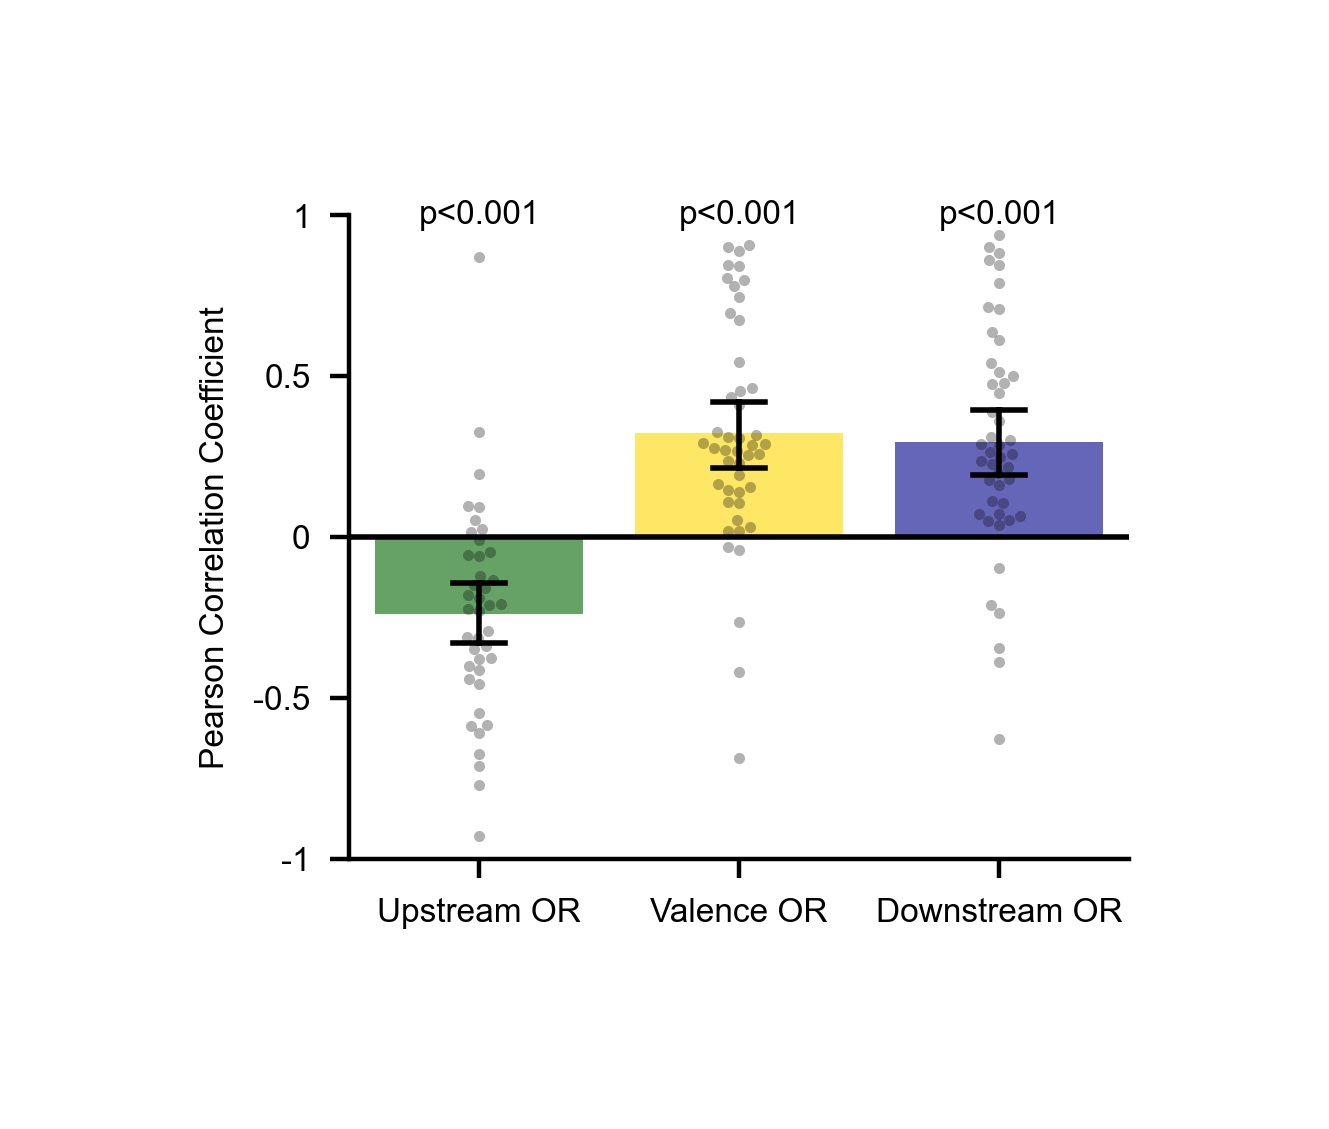

In [85]:
# Plot bar plot of unique lncRNAs with closest valence OR, r_up, r_valence, r_down
max_distance = 5_000 
results_subset = results[(results['tss_2_lnc_end'] < max_distance) & (results['tss_2_lnc_end'] > 0)]
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
f, ax = plt.subplots(1, 1, figsize=(2.5, 2), dpi=200)

sns.barplot(data=results_subset, x=0, y='r_up', ax=ax, color='darkgreen', alpha=0.6, label='Upstream', saturation=1, errcolor='black', capsize=0.2, errwidth=1)
sns.barplot(data=results_subset, x=1, y='r_valence', ax=ax, color='gold', alpha=0.6, label='Valence', saturation=1, errcolor='black', capsize=0.2, errwidth=1)
sns.barplot(data=results_subset, x=2, y='r_down', ax=ax, color='darkblue', alpha=0.6, label='Downstream', saturation=1, errcolor='black', capsize=0.2, errwidth=1)

sns.swarmplot(data=results_subset, x=0, y='r_up', ax=ax, color='black', size=2, alpha=0.3)
sns.swarmplot(data=results_subset, x=1, y='r_valence', ax=ax, color='black', size=2, alpha=0.3)
sns.swarmplot(data=results_subset, x=2, y='r_down', ax=ax, color='black', size=2, alpha=0.3)

ax.set_xticks([0, 1, 2], ['Upstream OR', 'Valence OR', 'Downstream OR'], fontsize=6)
ax.set_ylabel('Pearson Correlation Coefficient', fontsize=6)
#ax.set_title('lncRNA Expression vs OR Expression \n0 < Valence OR TSS to lncRNA 3p ≤ 5kbp', fontsize=6)
plt.legend([],[], frameon=False)
ax.set_ylim(-1, 1)
ax.set_yticks([-1, -0.5, 0, 0.5, 1], labels=['-1', '-0.5', '0', '0.5', '1'], fontsize=6)
# line at y=0
plt.axhline(0, color='black', lw=1)

# remove spines 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Add stats (different from 0) 
from scipy.stats import ttest_1samp
for i, or_ in enumerate(['up', 'valence', 'down']):
    r = results_subset[f'r_{or_}']
    t, p = ttest_1samp(r, 0)
    p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
    plt.text(i, 1, p_value_str, ha='center', va='center', transform=ax.transData, fontsize=6, color='black')

plt.tight_layout()
plt.savefig(f"../figures/Obir-lnc-inhibits-correlations.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## Ghost Effect

In [86]:
cell_valence_OR.loc[(cell_valence_OR['lncRNA_expression'] == 0) & (cell_valence_OR['tss_2_lnc_end'] < 2000), 'tandem_array'].value_counts()[0:20]

tandem_array
17    67
62    45
34    39
19    37
10    25
54    21
38     4
3      1
Name: count, dtype: int64

Valence OR: Or5-9E121
lncRNA: LOC109611203
tss2tss: 1956.0


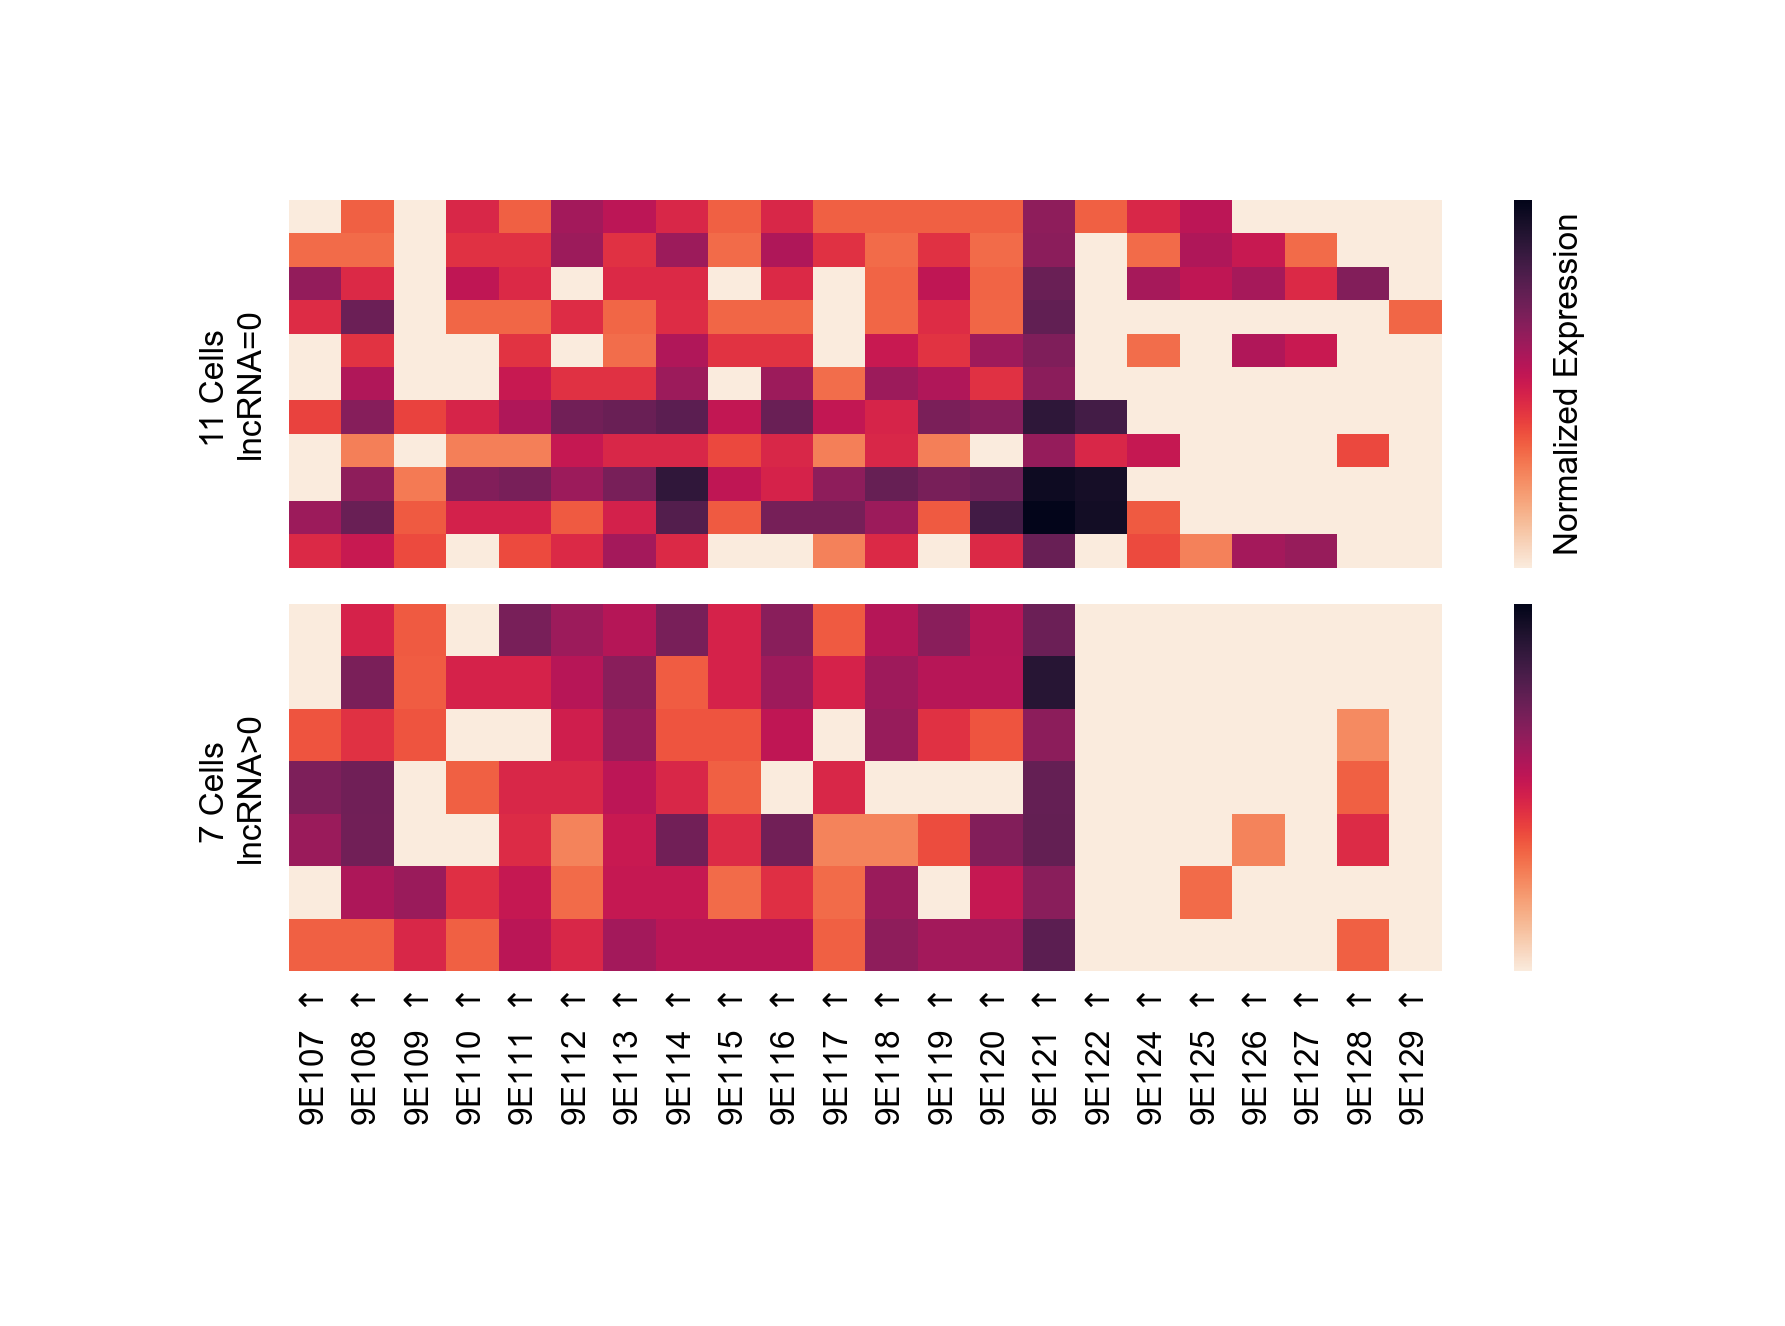

In [87]:
# Try showing the ghost effect 
# T3 is good (L25)
TA = 45
# Find cells with valence OR in this tandem array and zero lncRNA expression 
ghost_cells = cell_valence_OR.loc[(cell_valence_OR['tandem_array'] == TA) & (cell_valence_OR['lncRNA_expression'] == 0) & (cell_valence_OR['tss_2_lnc_end'] < 5000)]
top_valence_OR = ghost_cells['valence_OR'].value_counts().index[1]
print(f"Valence OR: {top_valence_OR}")
ghost_cells = ghost_cells.loc[ghost_cells['valence_OR'] == top_valence_OR]
non_ghost_cells = cell_valence_OR.loc[(cell_valence_OR['valence_OR'] == top_valence_OR) & (cell_valence_OR['lncRNA_expression'] > 0)]

combined = pd.concat([ghost_cells, non_ghost_cells])
lncs = combined['lncRNA'].value_counts() 
assert len(lncs) == 1
print(f"lncRNA: {lncs.index[0]}")

distance = combined['tss2tss'].value_counts()
assert len(distance) == 1
print(f"tss2tss: {distance.index[0]}")

# Retrieve expression data 

genes = or_db.loc[or_db['tandem_array'] == TA, 'gene_name'].values

ghost_cells_expression = adata[ghost_cells.cell_index.values] 
ghost_cell_expression = pd.DataFrame(ghost_cells_expression[:, genes].X.toarray(), columns=genes, index=ghost_cells_expression.obs_names)
ghost_cell_expression['top_or'] = ghost_cell_expression.idxmax(axis=1)
ghost_cell_expression['top_or'] = pd.Categorical(ghost_cell_expression['top_or'], categories=genes, ordered=True)
ghost_cell_expression = ghost_cell_expression.sort_values('top_or', ascending=True)

non_ghost_cells_expression = adata[non_ghost_cells.cell_index.values] 
non_ghost_cells_expression = pd.DataFrame(non_ghost_cells_expression[:, genes].X.toarray(), columns=genes, index=non_ghost_cells_expression.obs_names)
non_ghost_cells_expression['top_or'] = non_ghost_cells_expression.idxmax(axis=1)
non_ghost_cells_expression['top_or'] = pd.Categorical(non_ghost_cells_expression['top_or'], categories=genes, ordered=True)
non_ghost_cells_expression = non_ghost_cells_expression.sort_values('top_or', ascending=True)

# Plot a heatmap of the expression data, with or_db gene order on the x axis and expression on the y axis
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fig, axs = plt.subplots(2, 1, figsize=(4, 2.5), dpi=200) 
ax = axs[0]

vmin, vmax = 0, np.max([np.max(ghost_cell_expression.values[:, :-1]), np.max(ghost_cell_expression.values[:, :-1])])

sns.heatmap(ghost_cell_expression.iloc[:, :-1], 
            cmap=sns.color_palette("rocket_r", as_cmap=True), 
            ax=ax, 
            xticklabels=True, 
            yticklabels=False, 
            vmin=vmin, vmax=vmax, 
            cbar=True
            )

cbar = ax.collections[0].colorbar
cbar.set_ticks([])
cbar.set_label('Normalized Expression', fontsize=6) 
ax.set_ylabel(f'{ghost_cells.shape[0]} Cells \nlncRNA=0', fontsize=6)
ax.set_xlabel('')
ax.set_xticks([])

ax = axs[1]
sns.heatmap(non_ghost_cells_expression.iloc[:, :-1], 
            cmap=sns.color_palette("rocket_r", as_cmap=True), 
            ax=ax, 
            xticklabels=True, 
            yticklabels=False, 
            vmin=vmin, vmax=vmax, 
            cbar=True 
            )

cbar = ax.collections[0].colorbar
# set cbar to all white)
cbar.set_ticks([])
cbar.set_label('', fontsize=6) 
ax.set_ylabel(f'{non_ghost_cells.shape[0]} Cells \nlncRNA>0', fontsize=6)
ax.set_xlabel('')

# Modify the x-tick labels: Remove Or5- prefix and add orientation
xticks = ax.get_xticks()
xticklabels = [x.get_text() for x in ax.get_xticklabels()]
xticklabels = [f"{x} {tr.get_gene(x).strand}" for x in xticklabels]
xticklabels = [re.sub('Or5-','',x) for x in xticklabels]
xticklabels = [re.sub(r'(-)', r'$\\uparrow$', x) for x in xticklabels]
xticklabels = [re.sub(r'(\+)', r'$\\downarrow$', x) for x in xticklabels]
ax.set_xticklabels(xticklabels, fontsize=6, rotation=90)
ax.tick_params(axis='x', length=0)

plt.tight_layout()
plt.savefig(f"../figures/lnc_ghosting_heatmaps.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()
